# Face Model

Required modules Installation

In [1]:
!pip install opencv-python keras tensorflow librosa imbalanced-learn

Required Libraries for Face Model Imported

In [10]:
import os
import numpy as np
import pandas as pd
import cv2
from keras.applications import VGG16
from skimage.feature import hog
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import seaborn as sns
from pathlib import Path

In [11]:
# Dynamically get the project root
base_dir = Path().resolve().parent

# Directory and Data Information Karolinska Directed Emotional Faces (KDEF)
face_data_directory = base_dir / "data" / "processed" / "FaceData"



# Check if it exists
if not face_data_directory.exists():
    raise FileNotFoundError(f"❌ Face data folder not found: {face_data_directory}")
else:
    print(f"✅ Found face data in: {face_data_directory}")


✅ Found face data in: /Users/vinayadusumilli/Multimodal-Emotion-AI/data/processed/FaceData


Face Dataset Source: https://kdef.se/

In [13]:
# Emotion categories
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Feature and Label Storage
hog_features = []
vgg_features = []
image_labels = []
image_paths = []
failed_images = []


In [19]:
# Iterate Over Emotion Folders
for label in os.listdir(face_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(face_data_directory, label)
        
        # Check if the directory exists
        if os.path.isdir(emotion_dir):
            try:
                # Iterate over each file in the emotion folder
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    
                    # Process valid image files (.jpg, .jpeg, .png)
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        if os.path.getsize(file_path) > 0:  # Skiping empty files
                            image_paths.append(file_path)  # Storing image path
                            image_labels.append(label)     # Storing label
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in the emotions list.")

# Summary of Loaded Dataset
print("Face Dataset Loaded")
print(f"Total files: {len(image_paths)}")


Skipped .DS_Store, as it is not in the emotions list.
Face Dataset Loaded
Total files: 3495


In [ ]:
# Results directory path relative to project root
results_dir = base_dir / "results"
results_dir.mkdir(parents=True, exist_ok=True)

In [22]:
# Createing a DataFrame
image_df = pd.DataFrame({
    'image_paths': image_paths,  # Column for image file paths
    'image_label': image_labels  # Column for corresponding labels
})

# Display DataFrame
print(image_df.head())  # Display the first few rows for verification

# Validate Data Consistency
assert len(image_paths) == len(image_labels), "Mismatch between image paths and labels!"


# Save DataFrame to CSV

csv_path = results_dir / "image_data.csv"  
image_df.to_csv(csv_path, index=False) # Save DataFrame to a CSV file

# Summary Message
print(f"DataFrame created with {len(image_df)} records.")


                                         image_paths image_label
0  /Users/vinayadusumilli/Multimodal-Emotion-AI/d...       Happy
1  /Users/vinayadusumilli/Multimodal-Emotion-AI/d...       Happy
2  /Users/vinayadusumilli/Multimodal-Emotion-AI/d...       Happy
3  /Users/vinayadusumilli/Multimodal-Emotion-AI/d...       Happy
4  /Users/vinayadusumilli/Multimodal-Emotion-AI/d...       Happy
DataFrame created with 3495 records.


In [23]:
image_df.isnull().sum()

image_paths    0
image_label    0
dtype: int64

In [24]:
image_df['image_label'].value_counts()

image_label
Happy        700
Angry        700
Sad          699
Neutral      698
Surprised    698
Name: count, dtype: int64

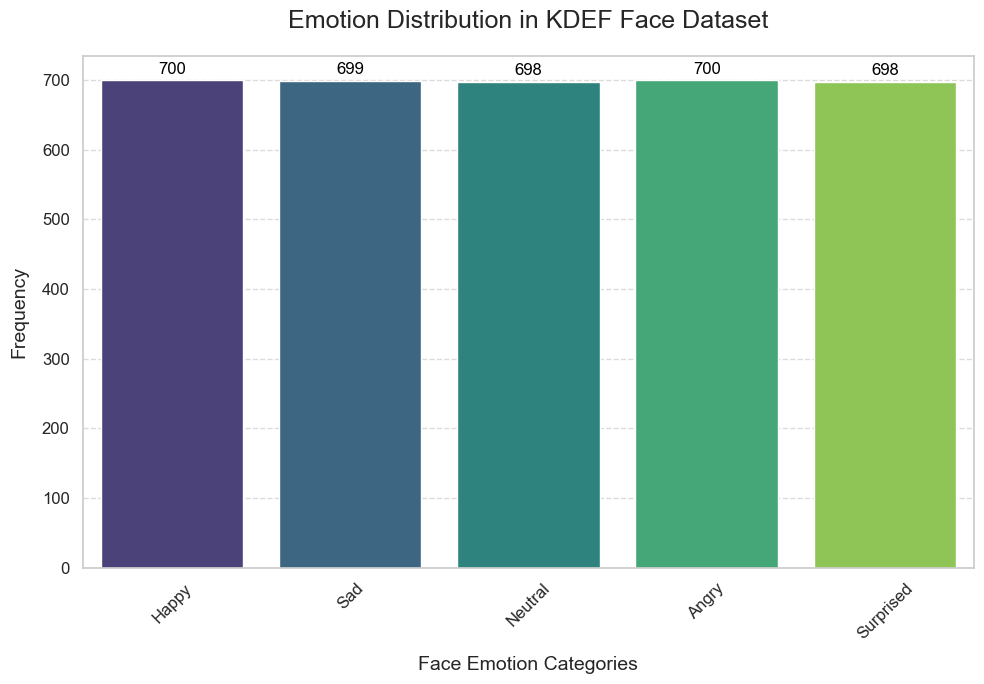

In [25]:
# Import Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set Visualization Style
sns.set_theme(style="whitegrid")

# Create the Count Plot
plt.figure(figsize=(10, 7))
ax = sns.countplot(
    data=image_df,  # Data source
    x='image_label',
    hue='image_label',
    palette="viridis",
    dodge=False,  # Disable bar separation
    legend=False
)

# Annotate Counts on Bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Add height value as text
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on top of bar
                ha='center', va='center',  # Center alignment
                fontsize=12, color='black',  # Font size and color
                xytext=(0, 8),  # Offset for better visibility
                textcoords='offset points')

# Customize Title and Axis Labels
plt.title('Emotion Distribution in KDEF Face Dataset', fontsize=18, pad=20)  # Add plot title
plt.xlabel('Face Emotion Categories', fontsize=14, labelpad=10)  # Label for x-axis
plt.ylabel('Frequency', fontsize=14, labelpad=10)  # Label for y-axis

# Enhance X-Axis Labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add Gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Optimize Layout
plt.tight_layout()

# Display the Plot
plt.show()


Preprocessing

In [26]:
# Import Required Libraries
from keras.applications import VGG16
from keras.models import Model

# Load Pre-trained VGG16 Model
vgg_model = VGG16(
    weights='imagenet',       # Load weights pre-trained on ImageNet
    include_top=False,        # Exclude the fully connected layers at the top
    input_shape=(224, 224, 3) # Define the input shape for the model
)

# Modify Model to Output Features from Block5 Pooling Layer
vgg_model = Model(
    inputs=vgg_model.input,  # Input remains the same
    outputs=vgg_model.get_layer('block5_pool').output  # Output from 'block5_pool' layer
)

# Freeze Layers in the Pre-trained Model
for layer in vgg_model.layers:
    layer.trainable = False  # Prevent updating weights during training

# Display Model Summary
print(vgg_model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [27]:
# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'visualize': True,
    'transform_sqrt': True,
}

In [28]:
def extract_hog_vgg(filename, emotion, vgg_model, hog_params, vgg_size=(224, 224), hog_size=(128, 128)):
    """
    Extract HOG and VGG16 features from an image.

    Args:
        filename (str): Path to the image file.
        emotion (str): Emotion label for the image.
        vgg_model: Pre-trained VGG16 model for feature extraction.
        hog_params (dict): Parameters for HOG feature extraction.
        vgg_size (tuple): Target size for VGG16 input (default: (224, 224)).
        hog_size (tuple): Target size for HOG input (default: (128, 128)).

    Returns:
        dict: Extracted features and the emotion label, or None in case of failure.
    """
    try:
        # Load the Image
        image = cv2.imread(filename)  # Loading the image using OpenCV
        if image is None:
            print(f"Failed to load image: {filename}")
            return None

        # Preprocess for VGG16
        vgg_image = cv2.resize(image, vgg_size)  # Resize image to VGG16 input size
        img_array = img_to_array(vgg_image)  # Convert to array format for Keras
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = preprocess_input(img_array)  # Normalize for VGG16
        vgg_feature = vgg_model.predict(img_array).flatten()  # Extract VGG16 features
        vgg_feature = (vgg_feature - np.mean(vgg_feature)) / np.std(vgg_feature)  # Standardize features

        # Extract HOG Features
        hog_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for HOG
        hog_image = cv2.resize(hog_image, hog_size)  # Resize for HOG input
        hog_feature, _ = hog(hog_image, **hog_params)  # Compute HOG features
        hog_feature = (hog_feature - np.mean(hog_feature)) / np.std(hog_feature)  # Standardize features

        # Return Combined Features
        return {
            "vgg_feature": vgg_feature,  # VGG16 features
            "hog_feature": hog_feature,  # HOG features
            "emotion": emotion,          # Emotion label
        }

    except Exception as e:
        # Handle Errors Gracefully
        print(f"Failed to extract features from {filename}: {e}")
        return None


In [ ]:
# Extract Features from Images
print("Extracting Features...")

# Loop over all images
for idx, (image_path, emotion) in enumerate(zip(image_paths, image_labels)):
    # Extract HOG and VGG16 features for the current image
    features = extract_hog_vgg(image_path, emotion, vgg_model, hog_params)
    
    if features:
        # Append extracted features to the respective lists
        vgg_features.append(features["vgg_feature"])  # Store VGG16 features
        hog_features.append(features["hog_feature"])  # Store HOG features
    else:
        # Track failed image paths
        failed_images.append(image_path)

    # Print progress for every 100 images or the last image
    if (idx + 1) % 100 == 0 or (idx + 1) == len(image_paths):
        print(f"Processed {idx + 1}/{len(image_paths)} images...")


Extracting Features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━

In [ ]:
# Face Results
print("\n=== Feature Extraction Summary ===")
print(f"Feature extraction completed. Number of VGG16 samples: {len(vgg_features)}")
print(f"Feature extraction completed. Number of HOG samples: {len(hog_features)}")
print(f"Feature extraction completed. Number of Labels: {len(image_labels)}")
if failed_images:
    print(f"\nNumber of failed images: {len(failed_images)}")
    print(f"Failed image paths: {failed_images}")
else:
    print("\nNo failed images.")

Visualization

In [ ]:
import random
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2

def visualize_features_for_emotion(emotion, image_paths, image_labels, hog_features, vgg_features, hog_params):
    """
    Visualizes the original image, HOG visualization, and VGG16 input for a randomly selected image of a specific emotion.

    Args:
        emotion (str): The emotion to visualize.
        image_paths (list): List of file paths to the original images.
        image_labels (list): List of emotion labels corresponding to images.
        hog_features (list): List of HOG feature arrays.
        vgg_features (list): List of VGG16 feature arrays.
        hog_params (dict): Parameters for HOG feature extraction.

    Returns:
        None
    """
    # Find Indices for the Specified Emotion
    indices = [i for i, label in enumerate(image_labels) if label == emotion]
    if not indices:
        print(f"No images found for the specified emotion: {emotion}.")
        return

    # Randomly Select One Image
    random_index = random.choice(indices)
    image_path = image_paths[random_index]

    # Load the Original Image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization

    # Regenerate HOG Visualization
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    gray_resized = cv2.resize(gray_image, (128, 128))  # Resize for HOG extraction
    _, hog_visualization = hog(
        gray_resized,
        orientations=hog_params['orientations'],
        pixels_per_cell=hog_params['pixels_per_cell'],
        cells_per_block=hog_params['cells_per_block'],
        block_norm=hog_params['block_norm'],
        visualize=True,  # Generate the HOG visualization
        transform_sqrt=hog_params['transform_sqrt']
    )

    # Resize Image for VGG16 Input
    vgg_resized = cv2.resize(image, (224, 224))  # Resize for VGG16 input size

    # Plot the Results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image ({emotion})")
    axs[0].axis('off')
    
    axs[1].imshow(hog_visualization, cmap='gray')
    axs[1].set_title("HOG Visualization")
    axs[1].axis('off')
    
    axs[2].imshow(vgg_resized)
    axs[2].set_title("VGG Input (Resized)")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

    # Print Additional Details
    print(f"Emotion: {emotion}")
    print(f"Random Index: {random_index}")
    print(f"Selected Image Path: {image_path}")
    print(f"Original Image Shape: {image.shape}")
    print(f"Gray Image Shape: {gray_resized.shape}")
    print(f"VGG Resized Shape: {vgg_resized.shape}")


Visualization for Happy Face

In [ ]:
visualize_features_for_emotion(
    emotion="Happy",
    image_paths=image_paths,
    image_labels=image_labels,
    hog_features=hog_features,
    vgg_features=vgg_features,
    hog_params=hog_params
)


Visualization for Angry Face

In [ ]:
visualize_features_for_emotion(
    emotion="Angry",
    image_paths=image_paths,
    image_labels=image_labels,
    hog_features=hog_features,
    vgg_features=vgg_features,
    hog_params=hog_params
)


Visualization for Sad Face

In [ ]:
visualize_features_for_emotion(
    emotion="Sad",
    image_paths=image_paths,
    image_labels=image_labels,
    hog_features=hog_features,
    vgg_features=vgg_features,
    hog_params=hog_params
)


Visualization for Surprised Face

In [ ]:
visualize_features_for_emotion(
    emotion="Surprised",
    image_paths=image_paths,
    image_labels=image_labels,
    hog_features=hog_features,
    vgg_features=vgg_features,
    hog_params=hog_params
)


Visualization for Neutral Face

In [ ]:
visualize_features_for_emotion(
    emotion="Neutral",
    image_paths=image_paths,
    image_labels=image_labels,
    hog_features=hog_features,
    vgg_features=vgg_features,
    hog_params=hog_params
)


In [ ]:
import numpy as np

# Convert Features to NumPy Arrays
vgg_features = np.array(vgg_features)
hog_features = np.array(hog_features)

# Validate Shapes of Features and Labels
if vgg_features.shape[0] == hog_features.shape[0] == len(image_labels):
    print(f"VGG features shape: {vgg_features.shape}")  # Print VGG16 features shape
    print(f"HOG features shape: {hog_features.shape}")  # Print HOG features shape

    # Combine Features
    face_features = np.hstack((vgg_features, hog_features))  # Horizontally stack features
    print(f"Combined features shape: {face_features.shape}")  # Print combined features shape
    
else:
    # Handle Mismatch in Features or Labels
    print("Mismatch in feature or label lengths. Cannot combine features.")


In [ ]:
assert face_features.shape[0] == len(image_labels), "Mismatch between features and labels!"

In [ ]:
# Save Combined Features and Labels
np.savez(
    "results/face_combined_features.npz",  # Filepath to save the .npz file
    face_features=face_features,          # Combined features (VGG + HOG)
    face_labels=image_labels              # Corresponding emotion labels
)


In [ ]:
import numpy as np

# Load Combined Features and Labels
data = np.load("results/face_combined_features.npz")  # Load the .npz file containing features and labels

# Access Features and Labels
face_features = data['face_features']  # Extract the combined features array
face_labels = data['face_labels']      # Extract the labels array

# Print Shapes of Loaded Data
print(f"Loaded features shape: {face_features.shape}")  # Print the shape of the features array
print(f"Loaded labels shape: {face_labels.shape}")      # Print the shape of the labels array


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode String Labels into Integers
le = LabelEncoder()  # Initialize the LabelEncoder
face_labels_encoded = le.fit_transform(face_labels)

# Check the Mapping of Labels
print("\n=== Class Mapping ===")
for idx, label in enumerate(le.classes_):
    print(f"{idx}: {label}")  # Print the mapping of integers to original labels

# Optional: Print a Few Encoded Labels
print("\nEncoded Labels Example:", face_labels_encoded[:10])  # Display first 10 encoded labels


In [ ]:
import joblib

# Save the Fitted LabelEncoder
joblib.dump(le, "results/face_label_encoder.pkl")  # Save the LabelEncoder instance to a file


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Class Frequencies
unique, counts = np.unique(face_labels_encoded, return_counts=True)  # Get unique labels and their frequencies

# Plot Class Distribution
plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(unique, counts, color="skyblue")  # Create a bar plot for class frequencies
plt.xlabel("Classes")  # X-axis label
plt.ylabel("Frequency")  # Y-axis label
plt.title("Class Distribution")  # Title of the plot
plt.xticks(unique, le.classes_, rotation=45)  # Using original class names as x-ticks, rotate for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines for better visualization

# Annotate Counts Above Bars
for i, count in enumerate(counts):  # Iterate through each class and its count
    plt.text(i, count + 5, str(count), ha='center', fontsize=10)  # Place text above each bar

# Adjust Layout and Display the Plot
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()


Data Split for Training 80-20

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    face_features,            # Input features (combined VGG + HOG features)
    face_labels_encoded,      # Target labels (encoded emotions)
    test_size=0.2,            # Fraction of the data to allocate for testing (20%)
    random_state=42           # Ensures reproducibility of the split
)


In [ ]:
# Checking Split Shapes
print(f"Training features shape: {X_train.shape}")  # Number of samples and features in training set
print(f"Testing features shape: {X_test.shape}")    # Number of samples and features in testing set
print(f"Training labels shape: {y_train.shape}")    # Number of labels in training set
print(f"Testing labels shape: {y_test.shape}")      # Number of labels in testing set

# Verify Label Distribution in Training and Testing Sets
unique_train, counts_train = np.unique(y_train, return_counts=True)  # Unique labels and their counts in training set
unique_test, counts_test = np.unique(y_test, return_counts=True)     # Unique labels and their counts in testing set

print("Training Label Distribution:", dict(zip(unique_train, counts_train)))  # Print training label distribution
print("Testing Label Distribution:", dict(zip(unique_test, counts_test)))    # Print testing label distribution


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import json

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',             # Using the 'balanced' strategy to compute weights
    classes=np.unique(y_train),          # Unique classes in the training set
    y=y_train                            # Training labels
)

# Convert to Dictionary
class_weights_dict = dict(enumerate(class_weights))  # Convert the weights array to a dictionary for readability

# Print Class Distribution and Weights
unique, counts = np.unique(y_train, return_counts=True)  # Get unique classes and their counts
print("Class Distribution:", dict(zip(unique, counts)))  # Print class distribution
print("Class Weights:", class_weights_dict)              # Print computed class weights


Face Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l2

model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Use X_train.shape[1]
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Number of classes
])


In [ ]:
from tensorflow.keras.optimizers import Adam
# Compileing the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('results/face_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [lr_scheduler, early_stopping, model_checkpoint]


In [ ]:
# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print loss and accuracy
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

In [ ]:
# Class-wise metrics
y_test_pred = model.predict(X_test).argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report
# Classification report
print("\nFace Emotion Classification Report:\n")
print(classification_report(y_test, y_test_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt

# Ensure the results directory exists
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "facial_training_validation_metrics.png")

# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.title('Training and Validation Loss')

# Save and Show
plt.tight_layout()
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Training and validation metrics plot saved as {output_file}")


In [ ]:
# Define the folder path
model_dir = Path("models")
model_dir.mkdir(parents=True, exist_ok=True)

# Save model
model.save(model_dir / "face_emotion_recognition_model.h5")

print(f"✅ Model saved to: {model_dir / 'face_model.h5'}")

# LIVE FACE EMOTION DETECTION

In [ ]:
import cv2
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from skimage.feature import hog

# Load trained emotion recognition model and label encoder
model = load_model("results/face_best_model.keras")
label_encoder = joblib.load("results/face_label_encoder.pkl")

# Load pre-trained VGG16 model for feature extraction
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("block5_pool").output)

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True,
    'visualize': False,  # Set to False to avoid unpacking errors
}

def preprocess_frame(frame, vgg_model, hog_params):
    """
    Extract HOG and VGG features from a single frame.
    Args:
        frame: Single frame from video.
        vgg_model: Pre-trained VGG16 model.
        hog_params: Parameters for HOG feature extraction.
    Returns:
        Combined feature array.
    """
    try:
        # Resize for VGG16
        vgg_image = cv2.resize(frame, (224, 224))
        img_array = np.expand_dims(vgg_image, axis=0)
        img_array = preprocess_input(img_array)
        vgg_feature = vgg_model.predict(img_array).flatten()
        vgg_feature = (vgg_feature - np.mean(vgg_feature)) / np.std(vgg_feature)

        # Convert to grayscale and resize for HOG
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        hog_image = cv2.resize(gray_frame, (128, 128))
        hog_feature = hog(hog_image, **hog_params)  # Only one output is returned
        hog_feature = (hog_feature - np.mean(hog_feature)) / np.std(hog_feature)

        # Combine features
        combined_features = np.hstack((vgg_feature, hog_feature))
        return combined_features

    except Exception as e:
        print(f"Error in preprocessing frame: {e}")
        return None

# Initialize webcam video capture
cap = cv2.VideoCapture(0)

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

print("Starting live emotion detection. Press 'q' to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame.")
        break

    # Detect faces
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        # Extract face ROI
        face_roi = frame[y:y + h, x:x + w]
        # Preprocess face ROI
        features = preprocess_frame(face_roi, vgg_model, hog_params)
        if features is not None:
            features = np.expand_dims(features, axis=0)  # Add batch dimension
            prediction = model.predict(features)
            emotion_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
            confidence = np.max(prediction)

            # Annotate the frame
            label = f"{emotion_label} ({confidence*100:.1f}%)"
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow("Live Emotion Detection", frame)

    # Break loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


# Speech Model

Required Libraries for Speech Model Imported

In [49]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Source for Speech Model: https://github.com/HLTSingapore/Emotional-Speech-Data?tab=readme-ov-file

In [50]:
import os
from collections import Counter

# *** Dataset Directory Setup ***
# Speech data directory
data_directory = "/Users/vinayadusumilli/MastersProject/SpeechData"

# Lists to store file paths and labels
speech_paths = []  # Stores paths of .wav files
speech_labels = []  # Stores corresponding emotion labels

# *** Data Loading and Processing ***
# Iterate over each emotion folder and process the audio files
for label in os.listdir(data_directory):  # Outer loop to go through emotion directories
    emotion_dir = os.path.join(data_directory, label)  # Full path to the emotion folder
    
    if os.path.isdir(emotion_dir):  # Check if it is a directory
        file_count = 0  # Counter for files in the current emotion folder
        
        # Iterate through files in the current emotion directory
        for file in os.listdir(emotion_dir):  
            if file.lower().endswith('.wav'):  # Check for .wav files (case insensitive)
                file_path = os.path.join(emotion_dir, file)  # Get the full file path
                speech_paths.append(file_path)  # Append file path to the list
                speech_labels.append(label)  # Append label (folder name) to the list
                file_count += 1  # Increment file counter
        
        # Print progress for the current folder
        print(f"Processed folder: {label}, Files found: {file_count}")
    else:
        # Skip non-directory items in the dataset root
        print(f"Skipping {label}: Not a directory.")

# *** Summary of the Dataset ***
print("\nDataset is Loaded")  # Inform the user that data loading is complete
print(f"Total files: {len(speech_paths)}")  # Total number of .wav files
print(f"Label distribution: {Counter(speech_labels)}")  # Show distribution of labels


Processed folder: Happy, Files found: 3500
Skipping .DS_Store: Not a directory.
Processed folder: Sad, Files found: 3500
Processed folder: Neutral, Files found: 3500
Processed folder: Angry, Files found: 3500
Processed folder: Surprised, Files found: 3500

Dataset is Loaded
Total files: 17500
Label distribution: Counter({'Happy': 3500, 'Sad': 3500, 'Neutral': 3500, 'Angry': 3500, 'Surprised': 3500})


In [51]:
# *** Create a DataFrame ***
# Combine file paths and labels into a Pandas DataFrame
speech_df = pd.DataFrame({
    'speech_paths': speech_paths,  # Column for audio file paths
    'speech_label': speech_labels  # Column for corresponding labels (emotions)
})

# Display the first few rows of the DataFrame to verify its structure
print(speech_df.head())

# *** Validate Data Consistency ***
# Ensure that the number of file paths matches the number of labels
assert len(speech_paths) == len(speech_labels), "Mismatch between audio paths and labels!"

# *** Save DataFrame to a CSV File ***
# Save the DataFrame to a CSV file for later use
speech_df.to_csv('results/speech_data.csv', index=False)  # Save without the index column

# Confirm successful creation and saving of the DataFrame
print(f"DataFrame created with {len(speech_df)} records.")


                                        speech_paths speech_label
0  /Users/vinayadusumilli/MastersProject/SpeechDa...        Happy
1  /Users/vinayadusumilli/MastersProject/SpeechDa...        Happy
2  /Users/vinayadusumilli/MastersProject/SpeechDa...        Happy
3  /Users/vinayadusumilli/MastersProject/SpeechDa...        Happy
4  /Users/vinayadusumilli/MastersProject/SpeechDa...        Happy
DataFrame created with 17500 records.


In [52]:
speech_df.isnull().sum()

speech_paths    0
speech_label    0
dtype: int64

In [53]:
speech_df['speech_label'].value_counts()

speech_label
Happy        3500
Sad          3500
Neutral      3500
Angry        3500
Surprised    3500
Name: count, dtype: int64

Visualisation of Speech DataFrame

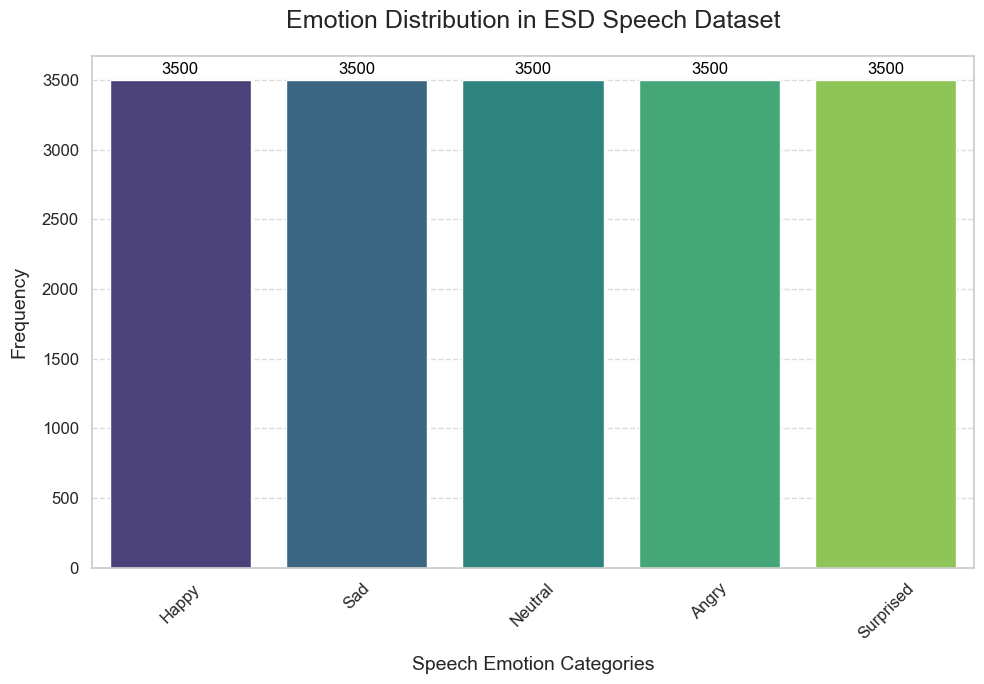

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# *** Set Plot Style ***
# Applying theme to the plot
sns.set_theme(style="whitegrid")

# *** Create the Count Plot ***
# Initializing the plot with a specific figure size
plt.figure(figsize=(10, 7))

# Generate a count plot for speech emotion categories
ax = sns.countplot(
    data=speech_df,
    x='speech_label',
    hue='speech_label',
    palette="viridis",
    dodge=False,
    legend=False
)

# *** Add Counts Above Bars ***
# Annotate each bar with its corresponding count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Add the count value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position above the bar
                ha='center', va='center',  # Center-align the text
                fontsize=12, color='black',  # Set font size and color
                xytext=(0, 8), textcoords='offset points')  # Offset for better readability

# *** Customize Titles and Labels ***
# Add a meaningful title to the plot
plt.title('Emotion Distribution in ESD Speech Dataset', fontsize=18, pad=20)

# Add labels for the x-axis and y-axis with custom font size
plt.xlabel('Speech Emotion Categories', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# *** Improve Readability ***
# Rotate x-axis labels for better readability (especially for long category names)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add horizontal gridlines for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)

# *** Adjust Layout and Display ***
# Automatically adjust spacing to prevent label overlap
plt.tight_layout()

# Display the finalized plot
plt.show()


Preprocessing

In [55]:
import librosa
import numpy as np
import os

def extract_mfcc(filename, sr=16000, n_mfcc=40, max_length=174, verbose=False):
    """
    Extract MFCC features, delta, and delta-delta from an audio file.

    Args:
        filename (str): Path to the audio file.
        sr (int): Sampling rate for audio loading (default: 16000).
        n_mfcc (int): Number of MFCC coefficients (default: 40).
        max_length (int): Maximum length of the feature sequence (default: 174).
        verbose (bool): If True, prints progress information (default: False).

    Returns:
        np.ndarray: Feature matrix of shape (max_length, n_mfcc * 3).
    """
    # *** Check if the file exists ***
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File not found: {filename}")
    
    try:
        # *** Load audio file ***
        # Load the audio file using Librosa with the specified sampling rate
        y, sr = librosa.load(filename, sr=sr)

        # *** Check for short audio ***
        # Raise an error if the audio file is shorter than half a second
        if len(y) < sr // 2:  # Less than half a second
            raise ValueError(f"Audio too short: {filename}")
        
        # *** Extract MFCC features ***
        # Compute the Mel-frequency cepstral coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # *** Compute delta and delta-delta features ***
        # Calculate the first derivative (delta) of the MFCCs
        mfccs_delta = librosa.feature.delta(mfccs)
        # Calculate the second derivative (delta-delta) of the MFCCs
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
        
        # *** Stack MFCC, delta, and delta-delta features ***
        # Combine all three features into a single matrix
        feature = np.vstack([mfccs, mfccs_delta, mfccs_delta2])
        
        # *** Pad or truncate feature sequence ***
        if feature.shape[1] > max_length:
            # Truncate the feature sequence to the specified maximum length
            feature = feature[:, :max_length]
        else:
            # Pad the feature sequence with zeros to the specified maximum length
            pad_width = max_length - feature.shape[1]
            feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        
        # *** Normalize features ***
        # Standardize the feature matrix (zero mean, unit variance)
        feature = (feature - np.mean(feature, axis=1, keepdims=True)) / (np.std(feature, axis=1, keepdims=True) + 1e-6)
        
        # *** Print progress if verbose ***
        if verbose:
            print(f"Processed {filename}: Shape {feature.T.shape}")
        
        # Return the transposed feature matrix
        return feature.T

    except Exception as e:
        # *** Handle errors during processing ***
        raise RuntimeError(f"An error occurred while processing {filename}: {e}")


Feature Extraction

In [56]:
speech_features = []  # *** Initialize a list to store extracted features ***

# *** Feature Extraction Loop ***
print("Extracting Features...")

# Iterate over each audio file path in the DataFrame
for path in speech_df['speech_paths']:
    features = extract_mfcc(path)  # *** Extract MFCC features *** using the previously defined `extract_mfcc` function
    speech_features.append(features)  # *** Append the extracted features *** for each file to the list

# *** Convert Features to NumPy Array ***
# Convert the list of feature matrices into a NumPy array for easier manipulation in later stages
speech_features = np.array(speech_features)

# *** Verify and Display Feature Dimensions ***
print(f"Extracted Features: {speech_features.shape}")  # *** Print the shape of the resulting feature array ***


Extracting Features...
Extracted Features: (17500, 174, 120)


In [57]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

def waveplot(data, sr, emotion, save_path=None):
    """
    Visualizes the waveform of an audio signal.

    Args:
        data (np.ndarray): Audio signal data.
        sr (int): Sampling rate of the audio signal.
        emotion (str): Emotion label associated with the audio.
        save_path (str, optional): File path to save the plot. Default is None.
    """
    if data.ndim != 1:
        raise ValueError("Input audio data must be a 1D array.")
    
    plt.figure(figsize=(10, 4))
    plt.title(f"Waveform: {emotion}", size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

def spectrogram(data, sr, emotion, save_path=None):
    """
    Visualizes the spectrogram of an audio signal.

    Args:
        data (np.ndarray): Audio signal data.
        sr (int): Sampling rate of the audio signal.
        emotion (str): Emotion label associated with the audio.
        save_path (str, optional): File path to save the plot. Default is None.
    """
    if data.ndim != 1:
        raise ValueError("Input audio data must be a 1D array.")
    
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(f"Spectrogram: {emotion}", size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


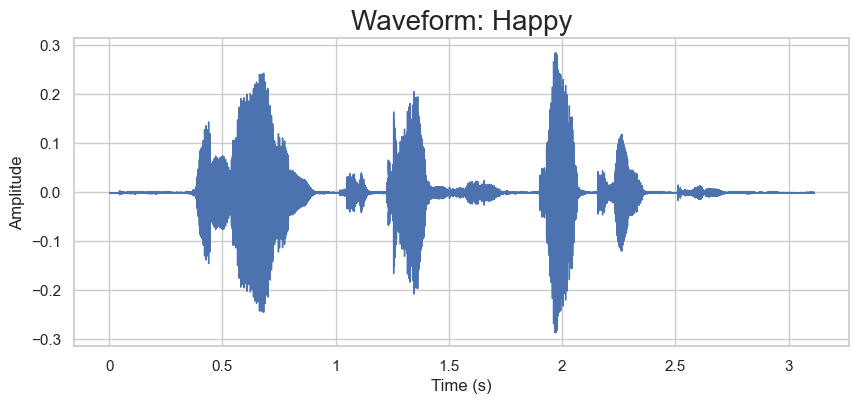

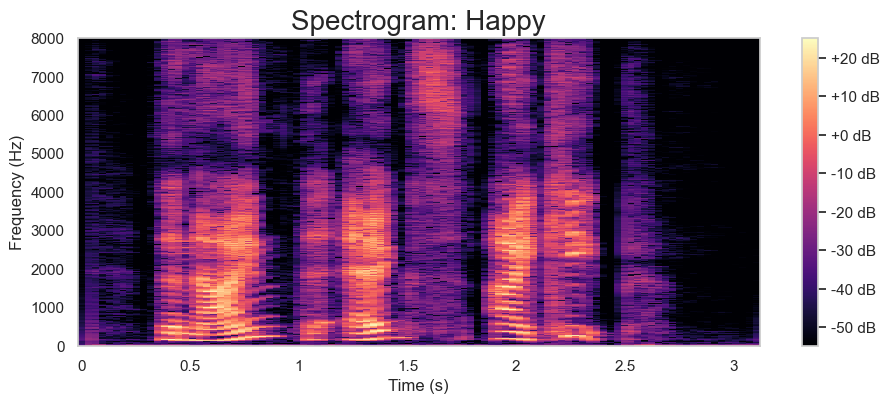

In [58]:
import librosa
from IPython.display import Audio

# Filter for a specific emotion
emotion = 'Happy'
path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]  # Get the first file path for the emotion

# Load the audio data
data, sampling_rate = librosa.load(path, sr=16000)

# Plot waveform and spectrogram
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


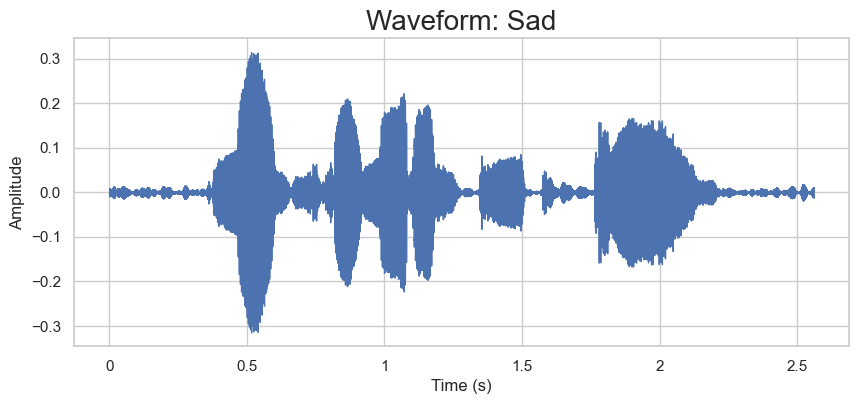

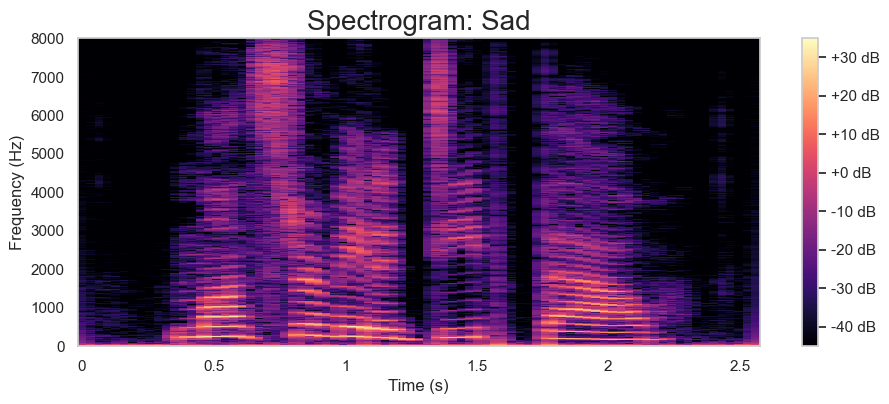

In [59]:
import librosa
from IPython.display import Audio

# Filter for a specific emotion
emotion = 'Sad'
path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]

# Load the audio data
data, sampling_rate = librosa.load(path, sr=16000)

# Plot waveform and spectrogram
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


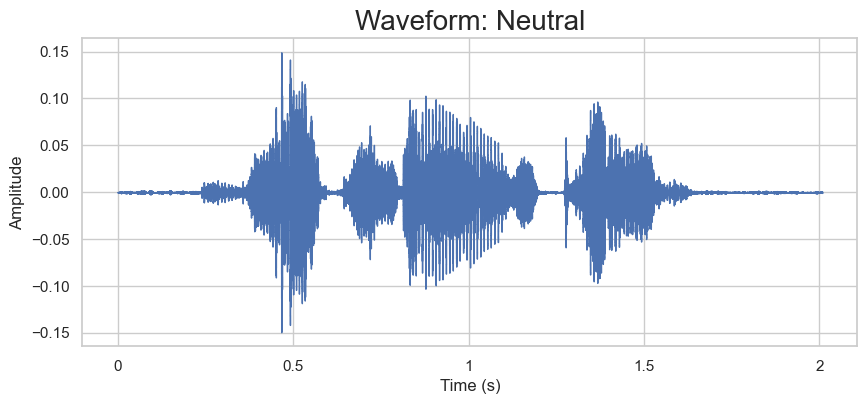

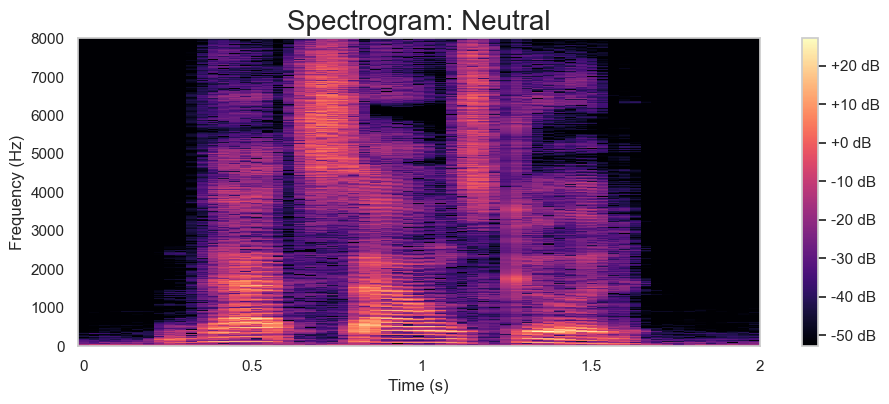

In [60]:
import librosa
from IPython.display import Audio

# Filter for a specific emotion
emotion = 'Neutral'
path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]

# Load the audio data
data, sampling_rate = librosa.load(path, sr=16000)

# Plot waveform and spectrogram
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


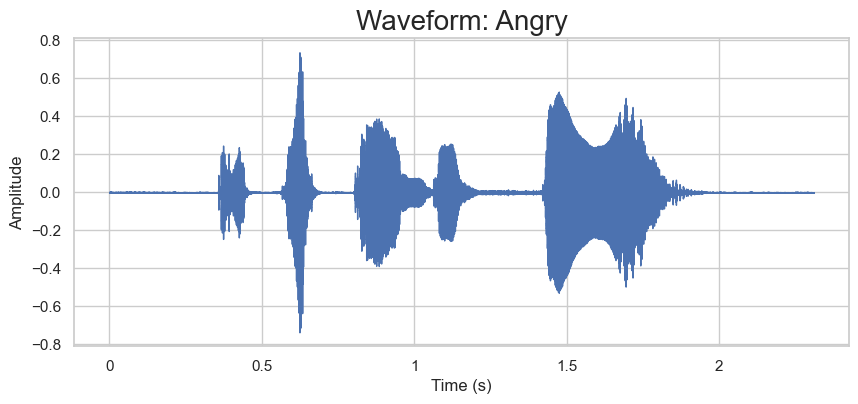

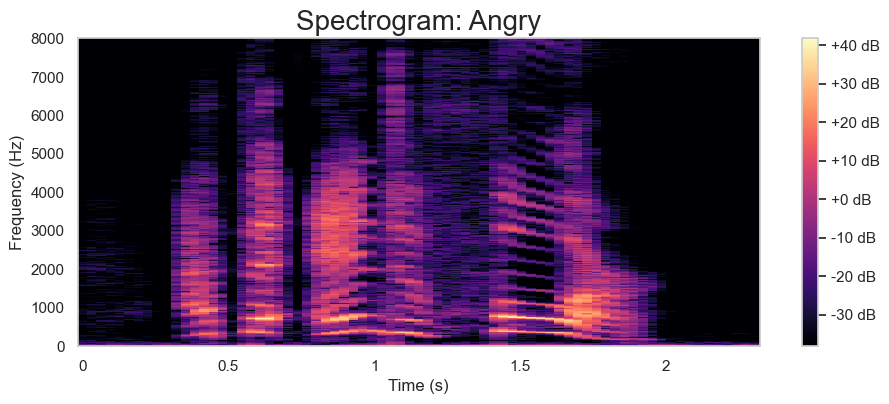

In [61]:
import librosa
from IPython.display import Audio

# Filter for a specific emotion
emotion = 'Angry'
path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]

# Loading the audio data
data, sampling_rate = librosa.load(path, sr=16000)

# Plot waveform and spectrogram
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


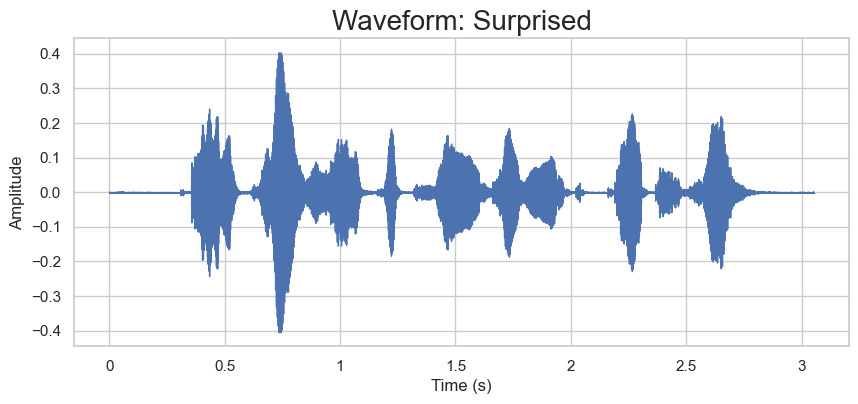

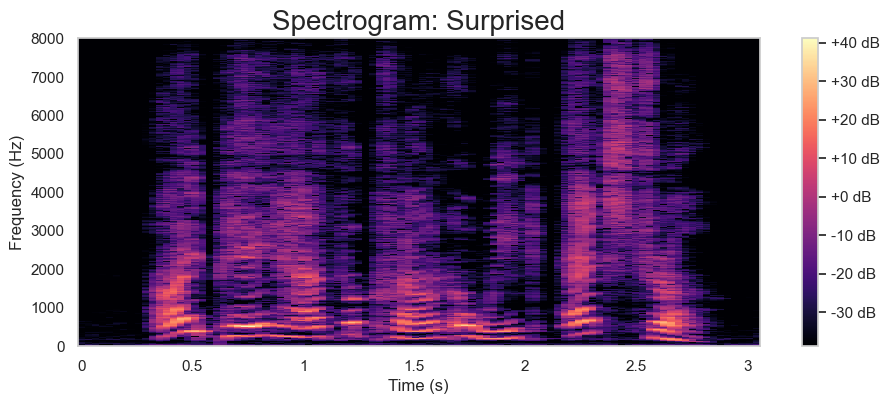

In [62]:
import librosa
from IPython.display import Audio

# Filter for a specific emotion
emotion = 'Surprised'
path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]

# Load the audio data
data, sampling_rate = librosa.load(path, sr=16000)

# Plot waveform and spectrogram
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

# Play the audio
Audio(path)


In [67]:
import os
import numpy as np

# *** Create Results Directory ***
# Ensure the "results" directory exists; create it if necessary
os.makedirs("results", exist_ok=True)

# *** Verify Consistency ***
# Check that the number of features matches the number of labels
assert len(speech_features) == len(speech_labels), "Mismatch between features and labels!"

# *** Save Features and Labels ***
# Save the features and labels as a compressed .npz file
np.savez("results/speech_features.npz", speech_features=speech_features, speech_labels=speech_labels)

# *** Confirmation Message ***
# Print a success message to confirm saving
print("Features Saved")


Features Saved


In [68]:
import numpy as np

# *** Load Combined Features and Labels ***
# Load the .npz file containing the saved features and labels
data = np.load("results/speech_features.npz")

# *** Access Features and Labels ***
# Extract features and labels from the loaded data
speech_features = data['speech_features']  # Extract the feature array
speech_labels = data['speech_labels']      # Extract the label array

# *** Display Loaded Data Shapes ***
# Print the shapes of the loaded arrays to confirm successful loading
print(f"Loaded features shape: {speech_features.shape}")
print(f"Loaded labels shape: {speech_labels.shape}")


Loaded features shape: (17500, 174, 120)
Loaded labels shape: (17500,)


In [69]:
from sklearn.preprocessing import LabelEncoder

# Encodeing string labels into integers
le = LabelEncoder()
speech_encoded_labels = le.fit_transform(speech_labels)  # Convert ['Angry', 'Happy'] to [0, 1, ...]

# Check the mapping of labels
print("\n=== Class Mapping ===")
for idx, label in enumerate(le.classes_):
    print(f"{idx}: {label}")

# Optional: Print a few encoded labels
print("\nEncoded Labels Example:", speech_encoded_labels[:10])



=== Class Mapping ===
0: Angry
1: Happy
2: Neutral
3: Sad
4: Surprised

Encoded Labels Example: [1 1 1 1 1 1 1 1 1 1]


In [66]:
import joblib
joblib.dump(le, "results/speech_label_encoder.pkl")

['results/speech_label_encoder.pkl']

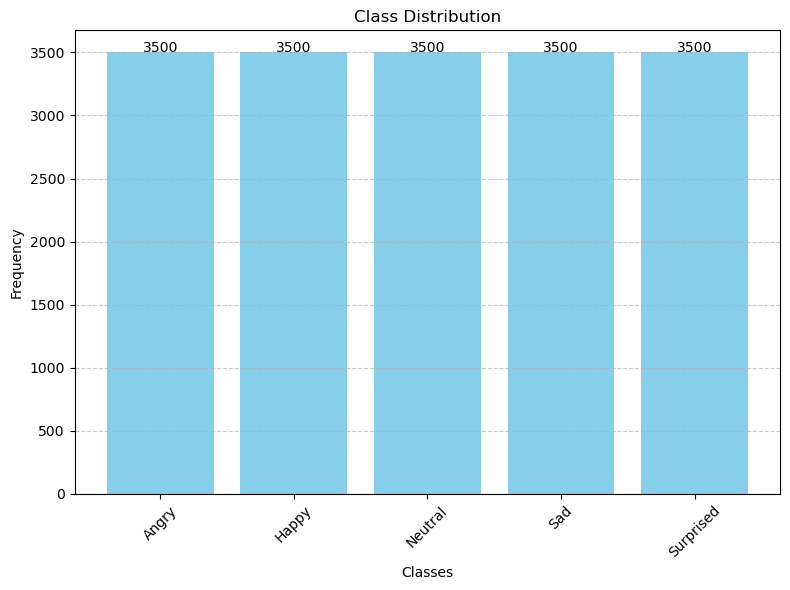

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate class frequencies
unique, counts = np.unique(speech_encoded_labels, return_counts=True)

# Plot class distribution
plt.figure(figsize=(8, 6))  # Adjust figure size
plt.bar(unique, counts, color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution")
plt.xticks(unique, le.classes_, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate counts above bars
for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


Data Split of model train 80-20

In [70]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(speech_features, speech_encoded_labels, test_size=0.2, random_state=42)

# Verify split
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Check label distribution
print(f"Training label distribution: {Counter(y_train)}")
print(f"Testing label distribution: {Counter(y_test)}")


Training features shape: (14000, 174, 120)
Testing features shape: (3500, 174, 120)
Training labels shape: (14000,)
Testing labels shape: (3500,)
Training label distribution: Counter({4: 2816, 2: 2808, 1: 2801, 0: 2798, 3: 2777})
Testing label distribution: Counter({3: 723, 0: 702, 1: 699, 2: 692, 4: 684})


In [71]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

# Print class distribution and weights
unique, counts = np.unique(y_train, return_counts=True)
print("Class Distribution:", dict(zip(unique, counts)))
print("Class Weights:", class_weights_dict)


Class Distribution: {0: 2798, 1: 2801, 2: 2808, 3: 2777, 4: 2816}
Class Weights: {0: 1.0007147962830594, 1: 0.9996429846483399, 2: 0.9971509971509972, 3: 1.0082823190493337, 4: 0.9943181818181818}


In [72]:
from tensorflow.keras import models, layers
model = models.Sequential([
    layers.InputLayer(shape=X_train.shape[1:]),
    
    # CNN layers with Batch Normalization
    layers.Conv1D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    layers.Dropout(0.3),
    
    # Flatten and Fully Connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [73]:
from tensorflow.keras.optimizers import Adam

# Compiling the Model
model.compile(
    optimizer=Adam(learning_rate=0.001),   # Adam optimizer with a learning rate of 0.001
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Metric to track during training
)


In [74]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 174, 32)        │        11,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 174, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 87, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 87, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 87, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 87, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 43, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 43, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       344,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,197 (1.48 MB)

 Trainable params: 387,749 (1.48 MB)

 Non-trainable params: 448 (1.75 KB)

In [75]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('results/speech_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [lr_scheduler, early_stopping, model_checkpoint]

In [76]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2589 - loss: 1.7733
Epoch 1: val_loss improved from inf to 1.24968, saving model to results/speech_best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2591 - loss: 1.7727 - val_accuracy: 0.4843 - val_loss: 1.2497 - learning_rate: 0.0010
Epoch 2/50
432/438 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4860 - loss: 1.1949
Epoch 2: val_loss improved from 1.24968 to 1.01196, saving model to results/speech_best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4865 - loss: 1.1940 - val_accuracy: 0.6226 - val_loss: 1.0120 - learning_rate: 0.0010
Epoch 3/50
436/438 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6241 - loss: 0.9456
Epoch 3: val_loss improved from 1.01196 to 0.84908, saving model to results/speech_best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6242 - loss: 0.9453 - val_accuracy: 0.7046 - val_loss: 0.8491 - learning_rate: 0.0010
Epoch 4/50
433/438 

In [77]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Print loss and accuracy
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Training Loss: 0.2600, Training Accuracy: 0.9027
Test Loss: 0.4090, Test Accuracy: 0.8660


In [78]:
# Class-wise metrics
y_test_pred = model.predict(X_test).argmax(axis=1)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [79]:
from sklearn.metrics import classification_report
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       702
           1       0.88      0.76      0.82       699
           2       0.94      0.84      0.89       692
           3       0.84      0.97      0.90       723
           4       0.94      0.84      0.89       684

    accuracy                           0.87      3500
   macro avg       0.87      0.87      0.87      3500
weighted avg       0.87      0.87      0.87      3500



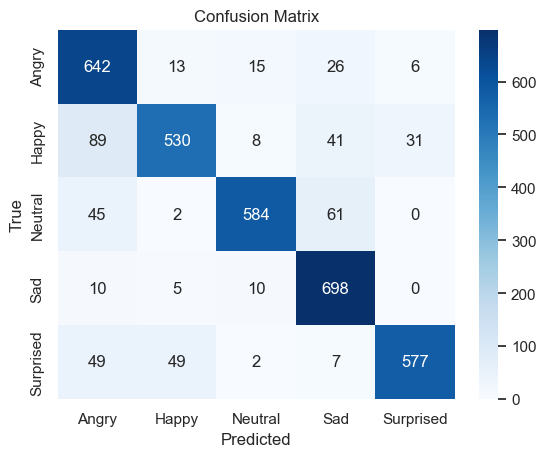

In [80]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

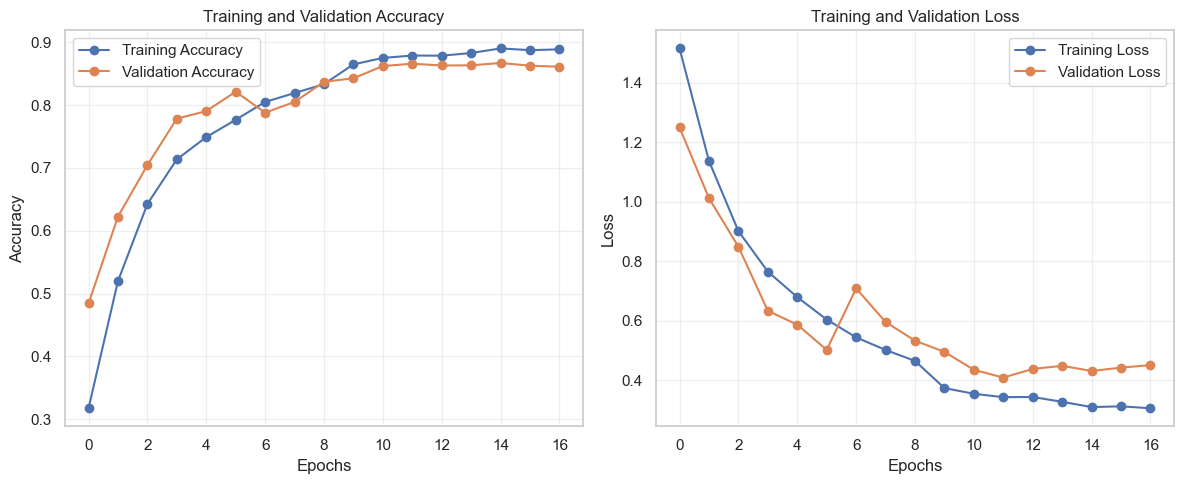

In [81]:
import matplotlib.pyplot as plt

# Plot Training and Validation Metrics
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend(loc='best')
plt.title('Training and Validation Loss')

# Save and Show
plt.tight_layout()
plt.savefig('results/training_validation_metrics.png', dpi=300)
plt.show()


In [82]:
import os

# Ensure the results directory exists
os.makedirs("results", exist_ok=True)

# Save the trained model
model.save("results/speech_emotion_recognition_model.h5")
print("Model saved as 'speech_emotion_recognition_model.h5' in results.")


Model saved as 'speech_emotion_recognition_model.h5' in results.


# Live Speech Emotion Recognition

In [83]:
!pip install sounddevice

In [ ]:
import sounddevice as sd
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import joblib
import time

# Load the pre-trained model and label encoder
model = load_model("results/speech_best_model.keras")
label_encoder = joblib.load("results/speech_label_encoder.pkl")

# Audio configuration
SAMPLE_RATE = 16000  # Sample rate for audio recording
DURATION = 5         # Duration of each recording (in seconds)
SILENCE_THRESHOLD = 1e-4  # Threshold for detecting silence (RMS energy)

# Function to extract MFCC features
def extract_mfcc_live(audio, sr=16000, n_mfcc=40, max_length=174):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Combine features
    feature = np.vstack([mfccs, mfccs_delta, mfccs_delta2])
    
    # Pad or truncate to max_length
    if feature.shape[1] > max_length:
        feature = feature[:, :max_length]
    else:
        pad_width = max_length - feature.shape[1]
        feature = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
    
    # Normalize
    feature = (feature - np.mean(feature, axis=1, keepdims=True)) / \
              (np.std(feature, axis=1, keepdims=True) + 1e-6)
    
    return feature.T

# Function to check if audio is silent
def is_audio_silent(audio, threshold=SILENCE_THRESHOLD):
    rms = np.sqrt(np.mean(audio**2))  # Calculate Root Mean Square (RMS) energy
    return rms < threshold

# Live prediction function
def predict_emotion_live():
    print("Listening... Speak for 3 seconds.")
    
    # Record audio for the specified duration
    audio = sd.rec(int(SAMPLE_RATE * DURATION), samplerate=SAMPLE_RATE, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is complete
    audio = audio.flatten()  # Flatten the audio array

    # Check if audio is silent
    if is_audio_silent(audio):
        print("No audio detected. Please speak louder or check your microphone.")
        return

    print("Processing audio...")
    # Extract MFCC features
    try:
        features = extract_mfcc_live(audio, sr=SAMPLE_RATE)
        features = np.expand_dims(features, axis=0)  # Add batch dimension

        # Predict emotion
        predictions = model.predict(features)
        predicted_index = np.argmax(predictions)
        emotion = label_encoder.inverse_transform([predicted_index])[0]
        confidence = np.max(predictions) * 100

        # Display the result
        print(f"Predicted Emotion: {emotion} (Confidence: {confidence:.2f}%)")
    except Exception as e:
        print(f"Error during prediction: {e}")

# Runing live predictions continuously
if __name__ == "__main__":
    while True:
        predict_emotion_live()
        time.sleep(1)
        print("\nPress Ctrl+C to stop.\n")


Listening... Speak for 3 seconds.
Processing audio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Emotion: Sad (Confidence: 100.00%)

Press Ctrl+C to stop.

Listening... Speak for 3 seconds.
Processing audio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: Sad (Confidence: 99.99%)

Press Ctrl+C to stop.

Listening... Speak for 3 seconds.
Processing audio...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion: Sad (Confidence: 99.99%)

Press Ctrl+C to stop.

Listening... Speak for 3 seconds.


# MultiModel Model

Required Libraries for MultiModel Imported

In [88]:
import os
import cv2
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.feature import hog
from tensorflow.keras.models import Model

Source Dataset for MultiModel: https://zenodo.org/records/1188976

In [89]:
# multi data directory
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"
# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']
# Lists to store paths and labels
true_labels = []  # To store the true emotion labels for each video
video_paths = []  # To store the file paths of the video files

In [90]:
# Iterate over each emotion folder
for label in os.listdir(video_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(video_data_directory, label)
        
        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process image files for face data
                    if file.lower().endswith(('.mp4')):
                        if os.path.getsize(file_path) > 0:
                            video_paths.append(file_path)
                            true_labels.append(label)
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

print("Dataset Loaded")
print(f"Total files: {len(video_paths)}")

Skipped .DS_Store, as it is not in emotions list.
Dataset Loaded
Total files: 240


In [91]:
# Create a DataFrame
multimodel_df = pd.DataFrame({
    'video_paths': video_paths,
    'true_labels': true_labels
})

# Display the first few rows
print(multimodel_df.head())

# Validate length consistency
assert len(video_paths) == len(true_labels), "Mismatch between video paths and labels!"

# Save DataFrame to a CSV file
image_df.to_csv('results/multimodel_df.csv', index=False)

print(f"DataFrame created with {len(multimodel_df)} records.")


                                         video_paths true_labels
0  /Users/vinayadusumilli/MastersProject/multimod...       Happy
1  /Users/vinayadusumilli/MastersProject/multimod...       Happy
2  /Users/vinayadusumilli/MastersProject/multimod...       Happy
3  /Users/vinayadusumilli/MastersProject/multimod...       Happy
4  /Users/vinayadusumilli/MastersProject/multimod...       Happy
DataFrame created with 240 records.


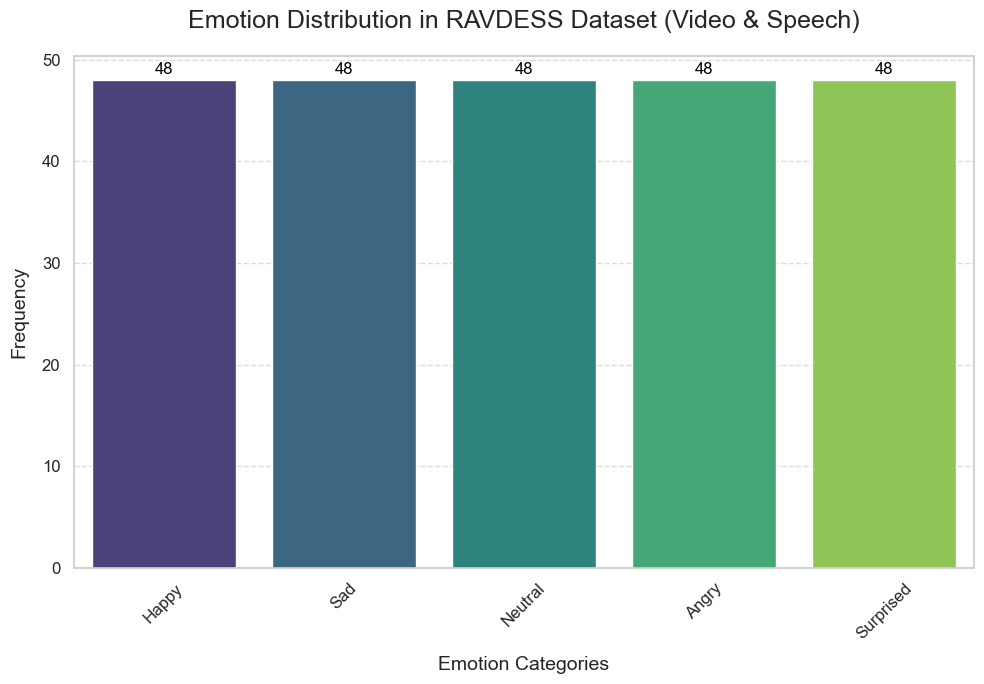

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a more modern style for the plot
sns.set_theme(style="whitegrid")

# Create the count plot
plt.figure(figsize=(10, 7))
ax = sns.countplot(
    data=multimodel_df, 
    x='true_labels', 
    hue='true_labels', 
    palette="viridis", 
    dodge=False, 
    legend=False
)

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), 
                textcoords='offset points')

# Add title and labels with larger fonts
plt.title('Emotion Distribution in RAVDESS Dataset (Video & Speech)', fontsize=18, pad=20)
plt.xlabel('Emotion Categories', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines with a subtle style
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust spacing and layout
plt.tight_layout()

# Display the plot
plt.show()


Loading Pre-trained Face and Speech Models

In [93]:
# Load pre-trained models
facial_model = load_model("/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5")
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')

# Recompile models with metrics to resolve warnings
facial_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
speech_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [94]:
from keras.applications import VGG16
from keras.models import Model

# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_pool').output)

# Freeze layers
for layer in vgg_model.layers:
    layer.trainable = False

print(vgg_model.summary())


Model: "functional_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [115]:
# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True,
    'visualize': True
}

Label Decoder

In [116]:
# Load label encoder
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')
print("Loaded classes:", le.classes_)

Loaded classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprised']


In [117]:
# Extract frames from video
def extract_frames(video_path, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = fps // frame_rate

    while cap.isOpened():
        frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_interval == 0:
            frames.append(frame)
    cap.release()
    return frames

In [118]:
# Preprocess frames for facial model
def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.resize(frame, target_size)
    frame = np.expand_dims(frame, axis=0)
    return frame

In [119]:
# # Extract audio from video
# def extract_audio(video_path, sr=16000):
#     y, sr = librosa.load(video_path, sr=sr)
#     return y, sr

import os
import librosa
import soundfile as sf

def extract_audio(video_path, output_audio_path=None, sr=16000, duration=None):
    """
    Extract and optionally save audio from a video file.

    Args:
        video_path (str): Path to the video file.
        output_audio_path (str, optional): Path to save the extracted audio as a `.wav` file. Default is None.
        sr (int): Target sampling rate for the audio (default: 16,000 Hz).
        duration (float, optional): Maximum duration (in seconds) to load from the audio. Default is None (entire audio).

    Returns:
        tuple: A tuple (audio, sampling_rate) where:
            - audio (np.ndarray): The extracted audio signal.
            - sampling_rate (int): The sampling rate of the audio.
    """
    try:
        # Check if the video file exists
        if not os.path.exists(video_path):
            raise FileNotFoundError(f"Video file not found: {video_path}")
        
        # Load the audio from the video file
        print(f"Extracting audio from: {video_path}")
        audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
        print(f"Audio extracted successfully. Duration: {len(audio) / sampling_rate:.2f} seconds, Sampling Rate: {sampling_rate} Hz")

        # Save the extracted audio as a .wav file if output_audio_path is specified
        if output_audio_path:
            os.makedirs(os.path.dirname(output_audio_path), exist_ok=True)  # Create directories if needed
            sf.write(output_audio_path, audio, sampling_rate)
            print(f"Audio saved to: {output_audio_path}")

        return audio, sampling_rate

    except Exception as e:
        print(f"Error extracting audio: {e}")
        return None, None


In [120]:
import numpy as np
import librosa

def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174, normalize=True, verbose=False):
    """
    Extract MFCC, delta, and delta-delta features from audio.

    Args:
        audio (np.ndarray): 1D array of the audio signal.
        sr (int): Sampling rate of the audio signal (default: 16000).
        n_mfcc (int): Number of MFCC coefficients to extract (default: 40).
        max_length (int): Maximum number of time steps (default: 174).
        normalize (bool): Whether to normalize the features (default: True).
        verbose (bool): If True, prints additional debug information (default: False).

    Returns:
        np.ndarray: Preprocessed MFCC feature array of shape (1, max_length, 3 * n_mfcc).
    """
    try:
        # Check for valid audio
        if audio is None or len(audio) == 0:
            raise ValueError("Audio input is empty or invalid.")

        if verbose:
            print(f"Audio shape: {audio.shape}, Sampling rate: {sr}")

        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Combine features
        combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])
        if verbose:
            print(f"Combined features shape before padding: {combined_features.shape}")

        # Adjust feature length (Padding or Truncation)
        if combined_features.shape[1] < max_length:
            padding = max_length - combined_features.shape[1]
            combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
            if verbose:
                print(f"Features padded to shape: {combined_features.shape}")
        else:
            combined_features = combined_features[:, :max_length]
            if verbose:
                print(f"Features truncated to shape: {combined_features.shape}")

        # Normalize features if requested
        if normalize:
            combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                                (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
            if verbose:
                print(f"Features normalized: mean={np.mean(combined_features):.4f}, std={np.std(combined_features):.4f}")

        # Add batch and time-step dimensions
        preprocessed_features = np.expand_dims(combined_features.T, axis=0)
        if verbose:
            print(f"Final feature shape: {preprocessed_features.shape}")

        return preprocessed_features

    except Exception as e:
        print(f"Error in extracting MFCC features: {e}")
        return None


In [121]:
# Extract HOG features
def extract_hog_features(frame, target_size=(128, 128), hog_params=hog_params):
    """
    Extract HOG features from an image frame.

    Args:
        frame (np.ndarray): Input image frame (BGR format).
        target_size (tuple): Target size for resizing the frame (default: (128, 128)).
        hog_params (dict): Parameters for HOG feature extraction.

    Returns:
        tuple: A tuple containing:
            - hog_features (np.ndarray): Extracted HOG features.
            - hog_image (np.ndarray): HOG visualization image (grayscale).
    """
    try:
        # Convert frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Resize frame to the target size
        resized_frame = cv2.resize(gray_frame, target_size)

        # Extract HOG features
        hog_features, hog_image = hog(resized_frame, **hog_params)

        return hog_features, hog_image

    except Exception as e:
        print(f"Error extracting HOG features: {e}")
        return None, None

In [129]:
import numpy as np

def predict_facial_emotions(frames, vgg_model, facial_model, hog_params, target_size=(224, 224)):
    """
    Predict facial emotions from a list of video frames.

    Args:
        frames (list of np.ndarray): List of video frames (BGR format).
        vgg_model (Model): Pre-trained VGG16 model for feature extraction.
        facial_model (Model): Pre-trained facial emotion recognition model.
        hog_params (dict): Parameters for HOG feature extraction.
        target_size (tuple): Target size for resizing frames for VGG16 input (default: (224, 224)).

    Returns:
        np.ndarray: Averaged predictions across the frames.
    """
    predictions = []
    try:
        for frame in frames:
            # Preprocess frame for VGG16
            preprocessed_frame = preprocess_frame(frame, target_size)

            # Extract VGG16 features
            vgg_features = vgg_model.predict(preprocessed_frame).flatten()

            # Extract HOG features
            hog_features, _ = extract_hog_features(frame, target_size=(128, 128), hog_params=hog_params)

            # Combine features (ensure proper shape)
            combined_features = np.hstack((vgg_features, hog_features)).reshape(1, -1)

            # Predict emotion
            pred = facial_model.predict(combined_features)
            predictions.append(pred)

        # Return the average prediction across frames
        return np.mean(predictions, axis=0)

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None


In [130]:
import numpy as np

def predict_speech_emotions(audio, sr, segment_duration=2, speech_model=None):
    """
    Predict speech emotions from an audio signal.

    Args:
        audio (np.ndarray): 1D array of the audio signal.
        sr (int): Sampling rate of the audio signal.
        segment_duration (float): Duration (in seconds) of each audio segment (default: 2 seconds).
        speech_model (Model): Pre-trained speech emotion recognition model.

    Returns:
        np.ndarray: Averaged predictions across all audio segments.
    """
    try:
        if audio is None or len(audio) == 0:
            raise ValueError("Invalid or empty audio signal.")
        
        if speech_model is None:
            raise ValueError("Speech model is not provided.")

        # Calculate segment length in samples
        segment_length = int(sr * segment_duration)

        predictions = []

        # Iterate through audio segments
        for i in range(0, len(audio), segment_length):
            segment = audio[i:i + segment_length]

            # Skip segments shorter than required duration
            if len(segment) < segment_length:
                continue

            # Extract MFCC features for the segment
            mfcc_features = extract_mfcc_features(segment, sr=sr)

            # Predict emotion for the segment
            pred = speech_model.predict(mfcc_features)
            predictions.append(pred)

        # Check if any predictions were made
        if not predictions:
            raise ValueError("No valid audio segments found for prediction.")

        # Average predictions across all segments
        averaged_prediction = np.mean(predictions, axis=0)

        return averaged_prediction

    except Exception as e:
        print(f"Error during speech emotion prediction: {e}")
        return None


In [131]:
def fuse_predictions(face_probs, speech_probs, weights=(0.6, 0.4)):
    """
    Fuse predictions from facial and speech modalities.

    Args:
        face_probs (np.ndarray): Probabilities from the facial emotion model.
        speech_probs (np.ndarray): Probabilities from the speech emotion model.
        weights (tuple): Weights for the facial and speech predictions (default: (0.6, 0.4)).

    Returns:
        np.ndarray: Combined probabilities after applying weighted fusion.
    """
    # Ensure weights sum to 1 for normalized fusion
    weights = np.array(weights) / sum(weights)

    # Weighted sum of probabilities
    fused_probs = weights[0] * face_probs + weights[1] * speech_probs

    return fused_probs


In [132]:
def predict_facial_emotion_only(video_path, vgg_model, facial_model, le, hog_params):
    """
    Predict the dominant emotion from a video using only the facial model.

    Args:
        video_path (str): Path to the video file.
        vgg_model (Model): Pre-trained VGG16 model for feature extraction.
        facial_model (Model): Pre-trained facial emotion recognition model.
        le (LabelEncoder): Label encoder for decoding predicted labels.
        hog_params (dict): Parameters for HOG feature extraction.

    Returns:
        str: The predicted dominant emotion.
    """
    try:
        # Extract frames from the video
        frames = extract_frames(video_path)
        if not frames:
            raise ValueError("No frames extracted from the video.")

        # Predict probabilities for each emotion
        face_probs = predict_facial_emotions(frames, vgg_model, facial_model, hog_params)

        # Determine the dominant emotion
        final_emotion_idx = np.argmax(face_probs)
        final_emotion = le.inverse_transform([final_emotion_idx])[0]

        return final_emotion

    except FileNotFoundError:
        print(f"Error: Video file not found at path {video_path}")
        return None

    except Exception as e:
        print(f"Error during facial emotion prediction: {e}")
        return None


In [133]:
def predict_speech_emotion_only(video_path, speech_model, le, segment_duration=2):
    """
    Predict the dominant emotion from a video using only the speech model.

    Args:
        video_path (str): Path to the video file.
        speech_model (Model): Pre-trained speech emotion recognition model.
        le (LabelEncoder): Label encoder for decoding predicted labels.
        segment_duration (float): Duration of each audio segment for emotion prediction (default: 2 seconds).

    Returns:
        str: The predicted dominant emotion.
    """
    try:
        # Extract audio from the video
        audio, sr = extract_audio(video_path)
        if audio is None or len(audio) == 0:
            raise ValueError("No valid audio extracted from the video.")

        # Predict probabilities for the speech model
        speech_probs = predict_speech_emotions(audio, sr, segment_duration=segment_duration, speech_model=speech_model)
        if speech_probs is None:
            raise ValueError("Failed to generate speech predictions.")

        # Determine the dominant emotion
        final_emotion_idx = np.argmax(speech_probs)
        final_emotion = le.inverse_transform([final_emotion_idx])[0]

        return final_emotion

    except FileNotFoundError:
        print(f"Error: Video file not found at path {video_path}")
        return None

    except Exception as e:
        print(f"Error during speech emotion prediction: {e}")
        return None


In [134]:
def predict_video_emotion(video_path, vgg_model, facial_model, speech_model, le, hog_params, weights=(0.6, 0.4)):
    """
    Predict the dominant emotion from a video using multimodal fusion (facial and speech models).

    Args:
        video_path (str): Path to the video file.
        vgg_model (Model): Pre-trained VGG16 model for feature extraction.
        facial_model (Model): Pre-trained facial emotion recognition model.
        speech_model (Model): Pre-trained speech emotion recognition model.
        le (LabelEncoder): Label encoder for decoding predicted labels.
        hog_params (dict): Parameters for HOG feature extraction.
        weights (tuple): Weights for facial and speech predictions (default: (0.7, 0.3)).

    Returns:
        tuple: A tuple containing:
            - final_probs (np.ndarray): Fused probabilities for each emotion.
            - final_emotion_idx (int): Index of the predicted dominant emotion.
            - final_emotion (str): Label of the predicted dominant emotion.
    """
    try:
        # Extract frames and audio from the video
        frames = extract_frames(video_path)
        if not frames:
            raise ValueError("No frames extracted from the video.")

        audio, sr = extract_audio(video_path)
        if audio is None or len(audio) == 0:
            raise ValueError("No valid audio extracted from the video.")

        # Predict probabilities from facial and speech models
        face_probs = predict_facial_emotions(frames, vgg_model, facial_model, hog_params)
        if face_probs is None:
            raise ValueError("Failed to generate facial predictions.")

        speech_probs = predict_speech_emotions(audio, sr, speech_model=speech_model)
        if speech_probs is None:
            raise ValueError("Failed to generate speech predictions.")

        # Fuse predictions
        final_probs = fuse_predictions(face_probs, speech_probs, weights=weights)

        # Determine the dominant emotion
        final_emotion_idx = np.argmax(final_probs)
        final_emotion = le.inverse_transform([final_emotion_idx])[0]

        # Print debug information
        print(f"Face Predictions: {face_probs}")
        print(f"Speech Predictions: {speech_probs}")
        print(f"Fused Predictions: {final_probs}")

        return final_probs, final_emotion_idx, final_emotion

    except FileNotFoundError:
        print(f"Error: Video file not found at path {video_path}")
        return None, None, None

    except Exception as e:
        print(f"Error during multimodal emotion prediction: {e}")
        return None, None, None


In [137]:
# Initialize lists to store predictions
facial_predictions = []
speech_predictions = []
fusion_predictions = []

# Generate predictions for each video
for video in video_paths:
    try:
        print(f"Processing video: {video}")

        # Predict emotion using the facial model
        facial_pred = predict_facial_emotion_only(video, vgg_model, facial_model, le, hog_params)
        facial_predictions.append(facial_pred)

        # Predict emotion using the speech model
        speech_pred = predict_speech_emotion_only(video, speech_model, le)
        speech_predictions.append(speech_pred)

        # Predict emotion using multimodal fusion
        _, _, fusion_pred = predict_video_emotion(
            video, vgg_model, facial_model, speech_model, le, hog_params, weights=(0.6, 0.4)
        )
        fusion_predictions.append(fusion_pred)

        print(f"Facial Prediction: {facial_pred}, Speech Prediction: {speech_pred}, Fused Prediction: {fusion_pred}")

    except Exception as e:
        print(f"Error processing video {video}: {e}")
        facial_predictions.append(None)
        speech_predictions.append(None)
        fusion_predictions.append(None)

print("\n=== Prediction Summary ===")
print(f"Facial Predictions: {facial_predictions}")
print(f"Speech Predictions: {speech_predictions}")
print(f"Fusion Predictions: {fusion_predictions}")


Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-07.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-07.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[8.8496573e-02 5.6424332e-01 9.7274005e-02 2.4998619e-01 1.2936161e-08]]
Speech Predictions: [[4.0569529e-03 9.6048126e-03 3.3460546e-01 6.5172607e-01 6.6558700e-06]]
Fused Predictions: [[5.4720726e-02 3.4238794e-01 1.9220659e-01 4.1068214e-01 2.6701098e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-13.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Face Predictions: [[4.9269253e-01 5.0033039e-01 5.2648314e-08 6.9770827e-03 7.8972295e-09]]
Speech Predictions: [[4.6612772e-06 2.1090251e-07 2.5465297e-06 9.9999261e-01 1.8317430e-09]]
Fused Predictions: [[2.9561740e-01 3.0019835e-01 1.0502009e-06 4.0418330e-01 5.4710347e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-12.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[3.0452338e-09 1.4316389e-05 2.9687422e-05 9.9995577e-01 2.6570851e-07]]
Speech Predictions: [[6.7861450e-01 3.1903416e-01 2.2537342e-06 2.0587463e-03 2.9034264e-04]]
Fused Predictions: [[2.71445811e-01 1.27622247e-01 1.87139467e-05 6.00796998e-01
  1.16296476e-04]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-06.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[9.5000345e-08 6.1592162e-01 3.8356254e-01 5.1582308e-04 3.6093177e-11]]
Speech Predictions: [[9.4367540e-01 5.2084766e-02 4.7595822e-05 9.4840559e-04 3.2437821e-03]]
Fused Predictions: [[0.37747023 0.39038688 0.23015657 0.00068886 0.00129751]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-10.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.2346203e-04 6.6269946e-01 4.8178318e-03 3.3235285e-01 6.3328544e-06]]
Speech Predictions: [[1.77303910e-01 5.00158846e-01 1.05608283e-02 3.11864316e-01
  1.12016845e-04]]
Fused Predictions: [[7.0995636e-02 5.9768325e-01 7.1150307e-03 3.2415745e-01 4.8606453e-05]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-04.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[1.2295735e-11 1.0000000e+00 9.3609520e-09 3.8486620e-11 3.5055598e-13]]
Speech Predictions: [[0.15576251 0.80796313 0.03293268 0.00166729 0.00167434]]
Fused Predictions: [[6.2305003e-02 9.2318529e-01 1.3173076e-02 6.6691422e-04 6.6973676e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-24.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[2.1024678e-09 2.7643010e-09 2.5502800e-07 9.9999976e-01 2.4203933e-14]]
Speech Predictions: [[2.37513464e-02 8.53138685e-01 7.90151898e-06 1.22869596e-01
  2.32373131e-04]]
Fused Predictions: [[9.5005399e-03 3.4125549e-01 3.3136243e-06 6.4914775e-01 9.2949253e-05]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-18.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.04224227e-05 4.40637559e-01 1.21264845e-01 4.38086659e-01
  5.23414428e-07]]
Speech Predictions: [[8.8704155e-06 9.9588859e-10 7.4112863e-09 9.9999118e-01 5.3869940e-11]]
Fused Predictions: [[9.8016208e-06 2.6438254e-01 7.2758913e-02 6.6284847e-01 3.1407021e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-19.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[5.9977414e-12 1.0000000e+00 1.6717987e-17 4.1949382e-09 2.1303851e-20]]
Speech Predictions: [[8.2001883e-10 3.9582144e-12 1.9544326e-10 1.0000000e+00 2.2078420e-14]]
Fused Predictions: [[3.316062e-10 6.000000e-01 7.817731e-11 4.000000e-01 8.831381e-15]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-05.mp4
Audio extracted successfully. Duration: 4.01 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face Predictions: [[2.7461600e-04 9.9965936e-01 8.9252921e-13 6.6014451e-05 6.3742796e-12]]
Speech Predictions: [[8.0318364e-07 4.8350717e-08 7.4059749e-06 9.9999177e-01 2.5251716e-11]]
Fused Predictions: [[1.6509088e-04 5.9979564e-01 2.9623905e-06 4.0003633e-01 1.3925255e-11]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-11.mp4
Audio extracted successfully. Duration: 3.11 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[6.9551754e-07 9.9741507e-01 7.9370324e-08 2.5840953e-03 3.3805802e-11]]
Speech Predictions: [[3.9446456e-03 8.1026065e-04 4.7273827e-03 9.9050611e-01 1.1639539e-05]]
Fused Predictions: [[1.5782756e-03 5.9877318e-01 1.8910007e-03 3.9775291e-01 4.6558362e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-15.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.9722680e-07 8.9281178e-01 1.0718797e-01 9.8470501e-08 8.4110967e-09]]
Speech Predictions: [[1.0190854e-02 2.5172010e-03 7.4464172e-02 9.1282648e-01 1.2992834e-06]]
Fused Predictions: [[4.0764599e-03 5.3669399e-01 9.4098456e-02 3.6513066e-01 5.2476008e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-01.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.9180903e-03 9.9740392e-01 2.7105438e-07 6.7759340e-04 1.1421088e-07]]
Speech Predictions: [[6.1592084e-01 1.4414664e-04 1.8218752e-02 3.6571550e-01 7.4176700e-07]]
Fused Predictions: [[2.4751920e-01 5.9850001e-01 7.2876634e-03 1.4669277e-01 3.6523335e-07]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-09.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.7712982e-07 9.2166698e-01 1.7187347e-11 7.8332819e-02 6.0755663e-09]]
Speech Predictions: [[3.1392579e-03 1.9059420e-04 8.1452376e-01 1.8214634e-01 1.2623008e-07]]
Fused Predictions: [[1.2558094e-03 5.5307645e-01 3.2580951e-01 1.1985823e-01 5.4137370e-08]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-21.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[6.7753594e-05 2.0745033e-01 4.7486042e-06 7.9132235e-01 1.1547449e-03]]
Speech Predictions: [[9.1514218e-01 1.5228809e-03 7.2684558e-03 7.6061256e-02 5.1947936e-06]]
Fused Predictions: [[0.36609754 0.12507936 0.00291023 0.5052179  0.00069492]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-20.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.2408863e-06 3.2037306e-01 1.4114514e-01 5.3847957e-01 3.8333741e-09]]
Speech Predictions: [[7.8663152e-07 7.4041377e-09 2.4725779e-07 9.9999893e-01 3.1822557e-14]]
Fused Predictions: [[1.6591845e-06 1.9222385e-01 8.4687181e-02 7.2308731e-01 2.3000373e-09]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-08.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[2.6122052e-03 4.7988844e-01 4.0959285e-06 5.1749527e-01 1.2990124e-08]]
Speech Predictions: [[2.9648605e-04 2.0950543e-05 8.3292164e-03 9.9135333e-01 2.0670875e-08]]
Fused Predictions: [[1.6859176e-03 2.8794146e-01 3.3341441e-03 7.0703852e-01 1.6062426e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-14.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[9.3672603e-10 7.5592744e-01 2.4406359e-01 8.9437781e-06 3.3264769e-11]]
Speech Predictions: [[3.7284897e-04 9.8893005e-01 7.6124348e-07 3.6227154e-03 7.0735752e-03]]
Fused Predictions: [[1.4914016e-04 8.4912848e-01 1.4643845e-01 1.4544524e-03 2.8294302e-03]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-02.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[6.6570269e-06 3.4345940e-04 4.9982271e-01 4.9982721e-01 1.0022231e-09]]
Speech Predictions: [[5.5758110e-03 9.2213464e-01 5.4872144e-05 7.2218835e-02 1.5882240e-05]]
Fused Predictions: [[2.2343188e-03 3.6905995e-01 2.9991558e-01 3.2878387e-01 6.3534976e-06]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-16.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Face Predictions: [[1.9579143e-07 7.4545074e-01 2.5000009e-01 4.5490023e-03 8.8872798e-11]]
Speech Predictions: [[9.7001779e-01 2.6126655e-02 5.9523500e-06 2.8573556e-03 9.9228928e-04]]
Fused Predictions: [[3.8800725e-01 4.5772111e-01 1.5000245e-01 3.8723438e-03 3.9691577e-04]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-22.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Face Predictions: [[3.9504425e-07 2.1467502e-01 7.3547214e-01 4.9852457e-02 2.6887639e-10]]
Speech Predictions: [[1.2193676e-05 1.2550072e-08 3.9702876e-08 9.9998784e-01 1.6368230e-11]]
Fused Predictions: [[5.1144971e-06 1.2880503e-01 4.4128335e-01 4.2990664e-01 1.6787313e-10]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[1.6312778e-06 1.2520659e-01 1.9538925e-06 8.7478977e-01 5.5212229e-10]]
Speech Predictions: [[9.9999976e-01 2.3642475e-08 1.3276598e-07 8.1300975e-08 1.6666540e-08]]
Fused Predictions: [[4.0000090e-01 7.5123966e-02 1.2254419e-06 5.2487397e-01 6.9978894e-09]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-17.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Face Predictions: [[3.5429917e-10 4.2028040e-01 1.6613267e-08 5.7971960e-01 1.2588427e-11]]
Speech Predictions: [[3.8391151e-04 2.5081608e-04 4.8423591e-01 5.1512933e-01 2.1209368e-08]]
Fused Predictions: [[1.5356482e-04 2.5226855e-01 1.9369438e-01 5.5388355e-01 8.4913010e-09]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[7.5145601e-07 9.9999845e-01 6.2604206e-12 8.4278867e-07 1.5621279e-11]]
Speech Predictions: [[1.7737794e-04 8.7590352e-06 1.3984031e-04 9.9967396e-01 1.3715587e-07]]
Fused Predictions: [[7.140205e-05 6.000026e-01 5.593613e-05 3.998701e-01 5.487172e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-12.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.6374501e-08 5.2162017e-07 2.1719135e-02 8.1387585e-01 1.6440450e-01]]
Speech Predictions: [[5.8805366e-04 5.8581412e-05 2.0980698e-07 9.9935287e-01 2.4891733e-07]]
Fused Predictions: [[2.3523728e-04 2.3745537e-05 1.3031566e-02 8.8806665e-01 9.8642796e-02]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-06.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.9141871e-07 1.4818658e-01 7.1846044e-01 1.3335283e-01 4.8450105e-10]]
Speech Predictions: [[0.6591788  0.04743553 0.00276082 0.2871817  0.00344316]]
Fused Predictions: [[0.26367164 0.10788617 0.4321806  0.19488439 0.00137727]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-07.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[2.677803e-01 7.316246e-01 4.543442e-04 1.406578e-04 6.106416e-08]]
Speech Predictions: [[1.8006180e-04 7.0979288e-05 3.3610795e-02 9.6613806e-01 3.9693596e-08]]
Fused Predictions: [[1.6074021e-01 4.3900317e-01 1.3716925e-02 3.8653964e-01 5.2515936e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-13.mp4
Audio extracted successfully. Duration: 3.13 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Face Predictions: [[2.3188700e-01 6.9468981e-01 1.7264018e-07 7.3422961e-02 3.3639736e-08]]
Speech Predictions: [[2.9450520e-03 1.9222041e-05 3.6814027e-03 9.9335432e-01 8.0239886e-08]]
Fused Predictions: [[1.4031023e-01 4.1682160e-01 1.4726646e-03 4.4139552e-01 5.2279795e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-19.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.3573690e-07 9.9995232e-01 5.8293044e-11 4.7536851e-05 1.1546330e-12]]
Speech Predictions: [[2.0134510e-03 7.0731672e-05 1.0183437e-02 9.8773205e-01 2.4070124e-07]]
Fused Predictions: [[8.0546184e-04 5.9999973e-01 4.0733749e-03 3.9512134e-01 9.6281191e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[8.5259926e-06 9.9998128e-01 8.8567044e-13 1.0284049e-05 8.7795795e-12]]
Speech Predictions: [[2.2170347e-05 8.9076209e-05 1.2914626e-03 9.9859720e-01 5.2088711e-09]]
Fused Predictions: [[1.3983735e-05 6.0002446e-01 5.1658502e-04 3.9944506e-01 2.0888162e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-11.mp4
Audio extracted successfully. Duration: 3.18 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Face Predictions: [[2.3184781e-05 7.5282085e-01 8.7193136e-10 2.4715602e-01 1.0128715e-10]]
Speech Predictions: [[3.6625746e-03 3.7754635e-05 3.7482162e-03 9.9255121e-01 1.8685674e-07]]
Fused Predictions: [[1.4789407e-03 4.5170763e-01 1.4992870e-03 5.4531407e-01 7.4803467e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-10.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.8695123e-04 5.3781778e-01 1.6966766e-05 4.5953685e-01 2.4413762e-03]]
Speech Predictions: [[1.1447561e-04 9.7837502e-01 1.2775372e-07 3.5727944e-03 1.7937576e-02]]
Fused Predictions: [[1.57960996e-04 7.14040637e-01 1.02311615e-05 2.77151227e-01
  8.63985624e-03]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-04.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[1.6474918e-12 9.9999982e-01 1.7540714e-07 3.3249560e-12 1.6123152e-13]]
Speech Predictions: [[0.22109912 0.30684754 0.0008367  0.47027662 0.00094002]]
Fused Predictions: [[8.8439651e-02 7.2273892e-01 3.3478465e-04 1.8811065e-01 3.7600854e-04]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-18.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[2.6593459e-09 4.9389198e-01 2.4999988e-01 2.5610813e-01 1.8865147e-09]]
Speech Predictions: [[9.4408438e-02 1.1944000e-02 5.2892382e-04 8.9240760e-01 7.1110367e-04]]
Fused Predictions: [[3.7763376e-02 3.0111280e-01 1.5021150e-01 5.1062793e-01 2.8444262e-04]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-24.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[3.1988352e-09 1.0281677e-07 1.8313283e-05 9.9998152e-01 2.4579136e-14]]
Speech Predictions: [[8.2055521e-01 1.7576429e-01 2.0749484e-04 2.6858628e-03 7.8716257e-04]]
Fused Predictions: [[3.2822210e-01 7.0305780e-02 9.3985909e-05 6.0106331e-01 3.1486503e-04]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[5.0199404e-04 3.2462430e-01 8.9450843e-08 6.7487359e-01 6.3711703e-09]]
Speech Predictions: [[9.8065382e-01 4.3153291e-04 1.7401861e-02 1.5077867e-03 5.0166359e-06]]
Fused Predictions: [[3.9256272e-01 1.9494720e-01 6.9607981e-03 4.0552729e-01 2.0104769e-06]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-20.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.91111167e-06 5.08807413e-02 3.93991500e-01 5.55125713e-01
  1.16803704e-07]]
Speech Predictions: [[1.6211935e-03 9.9251866e-01 1.5605731e-07 5.7686153e-03 9.1350463e-05]]
Fused Predictions: [[6.4962410e-04 4.2753592e-01 2.3639497e-01 3.3538288e-01 3.6610269e-05]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-14.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[1.6823924e-08 7.5912189e-01 2.4087802e-01 9.9220216e-08 1.3948941e-10]]
Speech Predictions: [[2.5243382e-04 9.7119147e-01 5.1963088e-06 1.7236832e-04 2.8378556e-02]]
Fused Predictions: [[1.0098362e-04 8.4394974e-01 1.4452888e-01 6.9006863e-05 1.1351422e-02]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-15.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face Predictions: [[3.59889292e-08 8.26031566e-01 1.73968315e-01 3.34289787e-08
  1.02489736e-07]]
Speech Predictions: [[7.4962401e-09 8.5011926e-09 7.1565005e-08 9.9999988e-01 6.0726077e-13]]
Fused Predictions: [[2.45918539e-08 4.95618969e-01 1.04381025e-01 3.99999976e-01
  6.14940845e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-01.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.3729581e-02 9.8603415e-01 1.4435789e-06 2.3380465e-04 9.8532223e-07]]
Speech Predictions: [[4.0462218e-02 6.2829036e-05 5.4628897e-02 9.0484607e-01 2.4671942e-09]]
Fused Predictions: [[2.4422634e-02 5.9164566e-01 2.1852426e-02 3.6207873e-01 5.9218024e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.84 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[4.8211767e-04 4.7038215e-01 5.5295613e-06 5.2892315e-01 2.0710027e-04]]
Speech Predictions: [[1.81489813e-04 1.75889659e-06 9.50425892e-05 9.99721706e-01
  1.11510495e-10]]
Fused Predictions: [[3.6186655e-04 2.8223002e-01 4.1334773e-05 7.1724260e-01 1.2426022e-04]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-09.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Face Predictions: [[2.3897410e-05 9.9504298e-01 5.2214746e-11 4.9331333e-03 5.1604125e-09]]
Speech Predictions: [[1.2909237e-03 1.0233895e-03 2.9242565e-03 9.9475986e-01 1.4897935e-06]]
Fused Predictions: [[5.3070794e-04 5.9743518e-01 1.1697026e-03 4.0086383e-01 5.9901367e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-23.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[7.7993917e-07 4.5529428e-01 3.4026282e-06 5.4470152e-01 2.0203124e-09]]
Speech Predictions: [[8.5960433e-02 2.5817024e-02 1.2367129e-03 8.8695431e-01 3.1550015e-05]]
Fused Predictions: [[3.4384642e-02 2.8350338e-01 4.9672677e-04 6.8160260e-01 1.2621218e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-17.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[2.5220395e-09 9.8042237e-04 5.5805788e-07 9.9901903e-01 2.2769464e-12]]
Speech Predictions: [[6.8070374e-02 1.1364038e-03 2.2747314e-01 7.0331621e-01 3.8929675e-06]]
Fused Predictions: [[2.7228152e-02 1.0428149e-03 9.0989590e-02 8.8073790e-01 1.5571884e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-03.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Face Predictions: [[1.9720231e-07 9.9999928e-01 9.7189921e-12 4.7110194e-07 1.8703776e-11]]
Speech Predictions: [[8.3162063e-01 2.0117983e-03 6.1602169e-03 1.6017337e-01 3.3966862e-05]]
Fused Predictions: [[3.3264837e-01 6.0080433e-01 2.4640867e-03 6.4069636e-02 1.3586756e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-02.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[3.6773858e-06 6.7281377e-05 7.4659836e-01 2.5333071e-01 1.1496961e-09]]
Speech Predictions: [[9.5224649e-02 2.4738693e-01 1.1814375e-05 6.5735751e-01 1.9103611e-05]]
Fused Predictions: [[3.8092066e-02 9.8995142e-02 4.4796377e-01 4.1494143e-01 7.6421338e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-02-01-16.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[2.2732968e-06 3.4791109e-01 4.9697649e-01 1.5511020e-01 8.0081444e-09]]
Speech Predictions: [[2.2042944e-04 2.4622027e-08 3.8528412e-07 9.9977916e-01 6.3369915e-10]]
Fused Predictions: [[8.9535759e-05 2.0874667e-01 2.9818606e-01 4.9297780e-01 5.0583662e-09]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Happy/01-01-03-01-01-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[7.5267621e-07 2.3955865e-01 5.0376439e-01 2.5667617e-01 1.8027271e-10]]
Speech Predictions: [[5.2054667e-01 1.8238018e-01 2.2795901e-04 2.9674596e-01 9.9229655e-05]]
Fused Predictions: [[2.0821913e-01 2.1668728e-01 3.0234984e-01 2.7270409e-01 3.9691971e-05]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-03.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.3121131e-02 9.6277088e-01 9.9647761e-05 2.4002168e-02 6.1881965e-06]]
Speech Predictions: [[7.1407335e-06 2.9794810e-06 5.9072886e-06 9.9998391e-01 1.5216552e-08]]
Fused Predictions: [[7.8755356e-03 5.7766372e-01 6.2151572e-05 4.1439486e-01 3.7190046e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-17.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[4.6194607e-08 6.3805950e-01 3.4678242e-13 3.6194044e-01 8.4299793e-13]]
Speech Predictions: [[3.0603191e-02 1.2057717e-02 9.4782567e-01 9.4631631e-03 5.0322411e-05]]
Fused Predictions: [[1.2241305e-02 3.8765880e-01 3.7913027e-01 2.2094955e-01 2.0128964e-05]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Face Predictions: [[1.4842834e-05 9.9625349e-01 6.3999341e-06 3.7252083e-03 3.0562372e-08]]
Speech Predictions: [[2.7501017e-05 9.9445942e-06 9.5797714e-04 9.9900466e-01 4.2743005e-09]]
Fused Predictions: [[1.9906107e-05 5.9775609e-01 3.8703083e-04 4.0183699e-01 2.0047144e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-22.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.16203304e-10 4.24857490e-07 9.99999583e-01 1.38755540e-08
  2.56529173e-13]]
Speech Predictions: [[5.2653409e-08 3.6403058e-09 7.1099354e-10 1.0000000e+00 1.2772302e-11]]
Fused Predictions: [[2.1131086e-08 2.5637064e-07 5.9999979e-01 4.0000001e-01 5.2628388e-12]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-16.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[7.7321241e-03 7.1386117e-01 2.5051835e-01 2.7886977e-02 1.3978649e-06]]
Speech Predictions: [[6.9955786e-05 7.0141425e-07 2.9698504e-05 9.9989963e-01 1.7059455e-11]]
Fused Predictions: [[4.6672570e-03 4.2831698e-01 1.5032290e-01 4.1669205e-01 8.3872584e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-02.mp4
Audio extracted successfully. Duration: 3.84 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.1366045e-06 2.3602706e-05 9.9997103e-01 3.2399005e-06 2.7408621e-08]]
Speech Predictions: [[5.5806329e-03 9.7243777e-03 8.4759988e-05 9.8460877e-01 1.4386541e-06]]
Fused Predictions: [[2.2335353e-03 3.9039128e-03 6.0001653e-01 3.9384544e-01 5.9190683e-07]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-14.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Face Predictions: [[8.9831982e-04 1.3299418e-03 9.9764800e-01 8.7877488e-05 3.5855075e-05]]
Speech Predictions: [[0.10960013 0.8174735  0.01665464 0.04823127 0.0080404 ]]
Fused Predictions: [[0.04437905 0.32778734 0.60525066 0.01934523 0.00323767]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-08.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[3.9643352e-03 7.5750217e-02 4.9435210e-05 9.2023605e-01 2.9242981e-09]]
Speech Predictions: [[5.3188300e-01 4.3358954e-04 4.0280643e-01 6.4874053e-02 3.0097406e-06]]
Fused Predictions: [[2.1513180e-01 4.5623567e-02 1.6115224e-01 5.7809126e-01 1.2056507e-06]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-20.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[5.9923664e-04 1.6467305e-04 9.2929530e-01 6.9618329e-02 3.2243936e-04]]
Speech Predictions: [[2.9436097e-04 1.3296292e-07 1.8633721e-06 9.9970359e-01 3.2388086e-09]]
Fused Predictions: [[4.7728640e-04 9.8857025e-05 5.5757797e-01 4.4165245e-01 1.9346492e-04]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-21.mp4
Audio extracted successfully. Duration: 4.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.9941610e-05 1.8393275e-01 4.5963593e-06 8.1598473e-01 5.7963316e-05]]
Speech Predictions: [[1.2246569e-07 1.4150979e-08 9.5061034e-07 9.9999893e-01 4.5794705e-12]]
Fused Predictions: [[1.2013953e-05 1.1035966e-01 3.1380598e-06 8.8959044e-01 3.4777993e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-09.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face Predictions: [[5.2102027e-06 5.0377429e-01 7.6808837e-10 4.9622050e-01 1.0677989e-08]]
Speech Predictions: [[1.8336000e-04 1.3617511e-05 1.5445481e-02 9.8435748e-01 6.8918991e-09]]
Fused Predictions: [[7.6470125e-05 3.0227003e-01 6.1781928e-03 6.9147533e-01 9.1635535e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-01.mp4
Audio extracted successfully. Duration: 3.84 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Face Predictions: [[2.9274090e-12 1.0000000e+00 3.0015383e-12 1.3426249e-08 1.1239179e-12]]
Speech Predictions: [[4.8880971e-05 3.7060236e-06 1.5605496e-04 9.9979144e-01 2.6841390e-10]]
Fused Predictions: [[1.9552390e-05 6.0000151e-01 6.2421983e-05 3.9991659e-01 1.0803991e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-15.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Face Predictions: [[6.7636154e-07 2.5383154e-01 7.4616063e-01 6.4030551e-06 7.4257514e-07]]
Speech Predictions: [[3.2945041e-10 2.6134500e-10 5.0718136e-09 1.0000000e+00 5.7705619e-15]]
Fused Predictions: [[4.0594873e-07 1.5229893e-01 4.4769639e-01 4.0000385e-01 4.4554511e-07]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-11.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[5.1511164e-05 7.6342463e-01 1.4295960e-04 2.3638089e-01 6.1618483e-10]]
Speech Predictions: [[2.6110790e-06 9.4271934e-07 3.3667163e-04 9.9965978e-01 2.5432698e-10]]
Fused Predictions: [[3.1951131e-05 4.5805520e-01 2.2044440e-04 5.4169250e-01 4.7144166e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-05.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.8655096e-07 6.4198864e-01 3.7170855e-09 3.5801113e-01 1.1068018e-08]]
Speech Predictions: [[1.4406338e-06 2.3215553e-07 4.6227807e-03 9.9537551e-01 1.4665148e-11]]
Fused Predictions: [[6.8818412e-07 3.8519329e-01 1.8491145e-03 6.1295688e-01 6.6466770e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-19.mp4
Audio extracted successfully. Duration: 3.18 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[1.9707900e-06 9.5861387e-01 1.4934155e-08 4.1384164e-02 1.2239630e-08]]
Speech Predictions: [[4.1640490e-08 8.7468868e-09 2.5634886e-06 9.9999738e-01 1.4619751e-12]]
Fused Predictions: [[1.1991302e-06 5.7516837e-01 1.0343559e-06 4.2482945e-01 7.3443629e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-18.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[2.52455010e-07 7.53841232e-05 9.93210673e-01 6.70239795e-03
  1.12945145e-05]]
Speech Predictions: [[5.8181718e-04 1.5114184e-04 3.9335052e-04 9.9886948e-01 4.3421605e-06]]
Fused Predictions: [[2.3287834e-04 1.0568721e-04 5.9608376e-01 4.0356922e-01 8.5135734e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-24.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Face Predictions: [[1.5335206e-07 2.8431779e-04 2.3230020e-06 9.9971318e-01 3.4982638e-11]]
Speech Predictions: [[1.0867168e-03 9.4813740e-01 1.2974599e-06 5.0772186e-02 2.3674413e-06]]
Fused Predictions: [[4.3477872e-04 3.7942556e-01 1.9127854e-06 6.2013680e-01 9.4699749e-07]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-04.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[1.0205686e-10 9.9997437e-01 2.5634727e-05 2.7681904e-10 8.0022357e-11]]
Speech Predictions: [[8.3934093e-01 1.0090011e-01 1.3447414e-03 5.8413044e-02 1.1765127e-06]]
Fused Predictions: [[3.3573636e-01 6.4034468e-01 5.5327744e-04 2.3365218e-02 4.7065308e-07]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-10.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face Predictions: [[1.2176378e-05 2.8302780e-01 2.4970031e-01 4.6724984e-01 9.8490109e-06]]
Speech Predictions: [[6.2789504e-06 1.3661275e-06 4.0972765e-05 9.9995136e-01 4.0206471e-10]]
Fused Predictions: [[9.8174069e-06 1.6981724e-01 1.4983658e-01 6.8033046e-01 5.9095678e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-06.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.0162852e-10 3.6564263e-04 9.9962467e-01 9.7075254e-06 5.9773013e-11]]
Speech Predictions: [[5.1303105e-03 3.9485926e-04 9.7782451e-01 1.6650248e-02 2.4905024e-08]]
Fused Predictions: [[2.0521246e-03 3.7732930e-04 9.9090469e-01 6.6659241e-03 9.9978736e-09]]
Facial Prediction: Neutral, Speech Prediction: Neutral, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-12.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.3158895e-07 1.0926648e-06 1.5499452e-04 9.9671984e-01 3.1239067e-03]]
Speech Predictions: [[2.2544923e-04 1.9515805e-03 1.9371477e-05 9.9780089e-01 2.6921125e-06]]
Fused Predictions: [[9.0258647e-05 7.8128779e-04 1.0074530e-04 9.9715233e-01 1.8754209e-03]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-13.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[9.5636204e-02 7.7371001e-01 3.6724032e-06 1.3065010e-01 1.7487379e-08]]
Speech Predictions: [[1.375865e-08 6.906813e-09 5.099776e-06 9.999949e-01 1.402075e-13]]
Fused Predictions: [[5.7381727e-02 4.6422604e-01 4.2433521e-06 4.7838801e-01 1.0492483e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[3.1050381e-06 3.0906554e-03 9.9690372e-01 2.3538473e-06 1.6847366e-07]]
Speech Predictions: [[9.8106498e-01 2.7479806e-05 1.4563494e-02 4.3429909e-03 1.0704454e-06]]
Fused Predictions: [[3.9242786e-01 1.8653852e-03 6.0396767e-01 1.7386087e-03 5.2926237e-07]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-22.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[8.7313309e-11 3.0470869e-07 9.9999702e-01 2.7052636e-06 2.0964574e-13]]
Speech Predictions: [[2.5595946e-04 1.0426884e-04 1.4424553e-05 9.9962533e-01 3.1678226e-08]]
Fused Predictions: [[1.02383834e-04 4.18903619e-05 6.00004017e-01 3.99851739e-01
  1.26714168e-08]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-16.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[2.5147352e-01 1.6226931e-02 5.0005740e-01 2.3224048e-01 1.7132438e-06]]
Speech Predictions: [[3.5960849e-03 2.4459297e-07 1.2872033e-05 9.9639076e-01 8.5520739e-08]]
Fused Predictions: [[1.5232256e-01 9.7362567e-03 3.0003962e-01 5.3790063e-01 1.0621546e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-02.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[1.0249650e-05 1.8948396e-01 8.0973804e-01 7.2392030e-04 4.3834010e-05]]
Speech Predictions: [[6.9995701e-01 3.7447676e-02 2.5864041e-01 3.9535048e-03 1.4050947e-06]]
Fused Predictions: [[2.7998894e-01 1.2866944e-01 5.8929902e-01 2.0157541e-03 2.6862446e-05]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-03.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[1.2440283e-03 9.3546450e-01 4.7874168e-02 1.5395379e-02 2.1883647e-05]]
Speech Predictions: [[9.0720403e-01 2.7616794e-04 4.8317488e-02 4.4199016e-02 3.2008672e-06]]
Fused Predictions: [[3.6362806e-01 5.6138915e-01 4.8051499e-02 2.6916835e-02 1.4410535e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-17.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[4.0663345e-10 2.4145327e-03 4.6954888e-11 9.9758548e-01 7.1783492e-13]]
Speech Predictions: [[5.91929653e-04 3.08906951e-04 4.70263362e-02 9.52072740e-01
  1.03000396e-07]]
Fused Predictions: [[2.3677212e-04 1.5722824e-03 1.8810535e-02 9.7938043e-01 4.1200590e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-23.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[1.3621873e-03 7.4562931e-01 1.3794175e-04 2.5287059e-01 5.2229852e-09]]
Speech Predictions: [[9.4520307e-01 3.6902050e-04 1.5848832e-02 3.8577352e-02 1.8077393e-06]]
Fused Predictions: [[3.7889853e-01 4.4752520e-01 6.4222980e-03 1.6715330e-01 7.2622953e-07]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-09.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[2.4871445e-01 7.5111067e-01 7.6938619e-08 1.7459392e-04 2.3816035e-07]]
Speech Predictions: [[1.4187781e-08 5.9846230e-09 4.3914162e-05 9.9995613e-01 3.1024293e-14]]
Fused Predictions: [[1.4922868e-01 4.5066643e-01 1.7611828e-05 4.0008721e-01 1.4289623e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-21.mp4
Audio extracted successfully. Duration: 4.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[0.00350675 0.37908715 0.00070778 0.6124837  0.00421463]]
Speech Predictions: [[1.3637424e-06 8.4256293e-08 1.9479323e-05 9.9997908e-01 2.4604980e-12]]
Fused Predictions: [[2.1045981e-03 2.2745232e-01 4.3245775e-04 7.6748186e-01 2.5287794e-03]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-01.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Face Predictions: [[1.5570970e-04 9.6097380e-01 2.0798108e-02 1.8038826e-02 3.3546716e-05]]
Speech Predictions: [[1.8754806e-06 8.7610886e-08 3.9577130e-06 9.9999416e-01 8.8421165e-13]]
Fused Predictions: [[9.4176015e-05 5.7658434e-01 1.2480448e-02 4.1082099e-01 2.0128031e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-15.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[4.45683739e-08 5.10565102e-01 4.89430457e-01 1.21702435e-08
  4.42802866e-06]]
Speech Predictions: [[3.4729013e-04 1.7718630e-04 2.8892490e-01 7.1055055e-01 6.6220092e-09]]
Fused Predictions: [[1.3894281e-04 3.0640996e-01 4.0922827e-01 2.8422022e-01 2.6594662e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-14.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Face Predictions: [[4.2594666e-06 6.1636023e-02 9.3550032e-01 2.8593708e-03 6.8834659e-08]]
Speech Predictions: [[0.01843065 0.12218107 0.00115973 0.85728884 0.00093968]]
Fused Predictions: [[7.3748156e-03 8.5854046e-02 5.6176412e-01 3.4463117e-01 3.7591325e-04]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-20.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[5.1215530e-04 2.9181320e-02 4.3151119e-01 5.3877228e-01 2.3058736e-05]]
Speech Predictions: [[0.38224044 0.4905267  0.00141096 0.00122186 0.12460012]]
Fused Predictions: [[0.15320347 0.21371947 0.25947112 0.32375214 0.04985388]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-08.mp4
Audio extracted successfully. Duration: 4.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.7198132e-04 3.2902551e-01 5.5253375e-03 6.6527718e-01 5.0009268e-09]]
Speech Predictions: [[7.7556126e-04 2.0672097e-04 3.0064538e-02 9.6895313e-01 6.4261641e-08]]
Fused Predictions: [[4.1341331e-04 1.9749799e-01 1.5341018e-02 7.8674757e-01 2.8705212e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-24.mp4
Audio extracted successfully. Duration: 4.09 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[7.9758138e-05 2.2212796e-01 1.9930468e-01 5.7848758e-01 6.3424965e-10]]
Speech Predictions: [[4.9135918e-03 1.6148766e-03 6.4250416e-06 9.9341452e-01 5.0605686e-05]]
Fused Predictions: [[2.0132917e-03 1.3392273e-01 1.1958539e-01 7.4445838e-01 2.0242655e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-18.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[4.9556924e-08 1.3886995e-05 2.4786858e-01 7.5211746e-01 9.8011725e-08]]
Speech Predictions: [[4.7030380e-07 2.0598043e-07 9.8740287e-09 9.9999928e-01 3.8983566e-11]]
Fused Predictions: [[2.1785567e-07 8.4145895e-06 1.4872116e-01 8.5127020e-01 5.8822629e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-04.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.7087167e-12 9.9999958e-01 4.5220406e-07 1.4229357e-12 3.1258288e-12]]
Speech Predictions: [[4.2724045e-04 9.5921373e-01 3.5219566e-06 3.7506126e-02 2.8493986e-03]]
Fused Predictions: [[1.7089618e-04 9.8368526e-01 1.6801050e-06 1.5002451e-02 1.1397594e-03]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-10.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[4.9788337e-06 2.6240912e-01 2.3699546e-01 5.0049007e-01 1.0033363e-04]]
Speech Predictions: [[1.6639343e-03 1.4396319e-05 2.8748646e-01 7.1083516e-01 1.0666517e-09]]
Fused Predictions: [[6.6856103e-04 1.5745123e-01 2.5719187e-01 5.8462811e-01 6.0200604e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-11.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[1.0002615e-05 6.4670587e-01 7.6438591e-06 3.5327649e-01 3.4766107e-10]]
Speech Predictions: [[1.5675870e-07 1.0758569e-07 1.3415338e-04 9.9986553e-01 2.8599625e-12]]
Fused Predictions: [[6.0642728e-06 3.8802356e-01 5.8247668e-05 6.1191213e-01 2.0974064e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-05.mp4
Audio extracted successfully. Duration: 3.11 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.2348672e-06 5.9363538e-01 1.2746322e-09 4.0636334e-01 1.1576651e-08]]
Speech Predictions: [[3.4818019e-08 8.9936281e-09 3.8937756e-05 9.9996102e-01 2.4773101e-13]]
Fused Predictions: [[7.5484758e-07 3.5618123e-01 1.5575866e-05 6.4380240e-01 6.9460899e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-01-01-19.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[9.9871201e-08 2.5748965e-01 1.5195056e-10 7.4251020e-01 2.0451674e-08]]
Speech Predictions: [[1.7560943e-09 5.7161209e-10 2.7155019e-07 9.9999976e-01 6.8358608e-14]]
Fused Predictions: [[6.0625162e-08 1.5449379e-01 1.0871125e-07 8.4550607e-01 1.2271032e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-13.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[8.4890903e-04 9.5229185e-01 1.7638934e-07 4.6859074e-02 6.5563677e-10]]
Speech Predictions: [[4.3093702e-09 5.1048471e-10 1.4415130e-07 9.9999988e-01 2.5274291e-14]]
Fused Predictions: [[5.0934718e-04 5.7137513e-01 1.6349412e-07 4.2811540e-01 3.9339218e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-07.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Face Predictions: [[8.7308536e-06 9.9342883e-01 6.2930724e-03 2.6908377e-04 2.6864294e-07]]
Speech Predictions: [[1.2534532e-01 1.7185552e-05 8.7188590e-01 2.7516440e-03 6.6976655e-09]]
Fused Predictions: [[5.0143365e-02 5.9606415e-01 3.5253021e-01 1.2621079e-03 1.6386484e-07]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-06.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.1072882e-09 4.4915188e-04 9.9955058e-01 2.8515265e-07 5.4459767e-11]]
Speech Predictions: [[9.4637090e-01 2.1079995e-02 3.4049698e-03 2.9120488e-02 2.3574607e-05]]
Fused Predictions: [[3.7854835e-01 8.7014893e-03 6.0109234e-01 1.1648367e-02 9.4298757e-06]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Sad/01-01-04-01-02-01-12.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.0141814e-09 1.3310193e-10 1.4028213e-07 9.9961084e-01 3.8902619e-04]]
Speech Predictions: [[1.7006954e-05 5.1772929e-07 3.8123813e-05 9.9994433e-01 1.2920685e-11]]
Fused Predictions: [[6.8033901e-06 2.0717158e-07 1.5333695e-05 9.9974430e-01 2.3341572e-04]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[3.2321404e-06 8.9581059e-03 9.9103844e-01 1.6153297e-07 1.6467728e-09]]
Speech Predictions: [[1.14675164e-02 1.04250785e-05 9.87813473e-01 7.08562962e-04
  5.09927600e-10]]
Fused Predictions: [[4.5889462e-03 5.3790337e-03 9.8974848e-01 2.8352209e-04 1.1920348e-09]]
Facial Prediction: Neutral, Speech Prediction: Neutral, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-13.mp4
Audio extracted successfully. Duration: 3.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[8.3798632e-02 8.4679633e-01 6.7693436e-06 6.9398291e-02 4.9407486e-08]]
Speech Predictions: [[9.5504731e-07 1.5296094e-07 2.3167327e-06 9.9999666e-01 1.7221452e-10]]
Fused Predictions: [[5.0279565e-02 5.0807786e-01 4.9882997e-06 4.4163764e-01 2.9713378e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-12.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.1770659e-09 2.1731113e-07 6.6745604e-05 9.9979067e-01 1.4242034e-04]]
Speech Predictions: [[9.0197980e-05 2.4813213e-04 2.9970548e-04 9.9936193e-01 1.1598240e-08]]
Fused Predictions: [[3.6080499e-05 9.9383236e-05 1.5992956e-04 9.9961925e-01 8.5456850e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-06.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Face Predictions: [[2.5553037e-10 1.4830541e-04 9.9985152e-01 1.5284444e-07 1.5468685e-11]]
Speech Predictions: [[9.9999523e-01 5.8532868e-07 4.0575806e-06 6.9218139e-08 2.5576699e-09]]
Fused Predictions: [[3.9999810e-01 8.9217378e-05 5.9991252e-01 1.1939392e-07 1.0323492e-09]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-10.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[4.0313612e-06 7.6374948e-02 9.2114627e-01 2.4636856e-03 1.0987017e-05]]
Speech Predictions: [[5.8025648e-06 8.3386021e-06 5.0290124e-05 9.9993551e-01 6.1089350e-10]]
Fused Predictions: [[4.7398426e-06 4.5828305e-02 5.5270785e-01 4.0145242e-01 6.5924546e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[5.5888838e-10 9.9622130e-01 3.7787154e-03 6.3527841e-09 1.2930610e-09]]
Speech Predictions: [[2.7447306e-02 9.2770302e-01 2.4563073e-07 5.4805512e-03 3.9368872e-02]]
Fused Predictions: [[0.01097892 0.968814   0.00226733 0.00219222 0.01574755]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[1.00512825e-05 1.91369720e-04 9.95108306e-01 4.42888355e-03
  2.61419307e-04]]
Speech Predictions: [[4.7894176e-03 6.6938455e-04 3.4601313e-01 6.4852720e-01 8.5218016e-07]]
Fused Predictions: [[1.9217979e-03 3.8257564e-04 7.3547029e-01 2.6206821e-01 1.5719247e-04]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-24.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[6.2698258e-10 1.1083589e-08 2.7385975e-06 9.9999726e-01 3.8104290e-15]]
Speech Predictions: [[2.1401610e-02 1.5586790e-01 1.9218109e-03 8.2080513e-01 3.5051166e-06]]
Fused Predictions: [[8.5606445e-03 6.2347170e-02 7.7036751e-04 9.2832041e-01 1.4020467e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-19.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[6.0758837e-10 9.9997115e-01 8.7534140e-08 2.8744107e-05 1.4812538e-11]]
Speech Predictions: [[1.0525215e-07 7.3201853e-08 4.6639736e-05 9.9995327e-01 4.5105377e-13]]
Fused Predictions: [[4.2465416e-08 5.9998274e-01 1.8708415e-05 3.9999858e-01 9.0679452e-12]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-05.mp4
Audio extracted successfully. Duration: 3.11 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[7.9968856e-08 5.2228862e-01 4.6222809e-10 4.7771132e-01 1.4615207e-08]]
Speech Predictions: [[3.0452538e-06 2.8256354e-06 2.3645052e-04 9.9975771e-01 1.3193337e-10]]
Fused Predictions: [[1.2660829e-06 3.1337431e-01 9.4580486e-05 6.8652987e-01 8.8218979e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-11.mp4
Audio extracted successfully. Duration: 3.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.0732423e-03 8.2762617e-01 8.9478763e-06 1.7029166e-01 1.0906865e-09]]
Speech Predictions: [[4.0610344e-06 2.2953006e-06 3.3690236e-04 9.9965680e-01 1.4203554e-10]]
Fused Predictions: [[1.2455699e-03 4.9657664e-01 1.4012968e-04 5.0203776e-01 7.1122619e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-15.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[8.0019123e-07 2.7615596e-02 9.7238338e-01 8.5460250e-08 1.0874665e-07]]
Speech Predictions: [[4.7415895e-07 1.3954040e-07 3.9012371e-05 9.9996042e-01 8.0127016e-12]]
Fused Predictions: [[6.6977833e-07 1.6569413e-02 5.8344567e-01 3.9998424e-01 6.5251193e-08]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-01.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.1902255e-06 9.9860352e-01 1.2832668e-03 1.1190473e-04 1.7054029e-07]]
Speech Predictions: [[2.1911720e-07 6.0752257e-08 6.4695769e-07 9.9999917e-01 8.4854389e-13]]
Fused Predictions: [[8.0178216e-07 5.9916216e-01 7.7021890e-04 4.0006682e-01 1.0232452e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-21.mp4
Audio extracted successfully. Duration: 3.84 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.5490306e-07 5.2206999e-01 1.1064863e-06 4.7780967e-01 1.1911582e-04]]
Speech Predictions: [[6.2190879e-06 4.0730941e-07 4.7632471e-05 9.9994564e-01 2.3388338e-11]]
Fused Predictions: [[2.5805771e-06 3.1324217e-01 1.9716879e-05 6.8666410e-01 7.1469505e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-09.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Face Predictions: [[1.9755842e-02 7.1677905e-01 1.2217720e-01 1.4124756e-01 4.0421484e-05]]
Speech Predictions: [[2.2294463e-08 3.5161928e-08 3.4362808e-04 9.9965632e-01 1.2635552e-13]]
Fused Predictions: [[1.1853515e-02 4.3006745e-01 7.3443770e-02 4.8461106e-01 2.4252891e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-08.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.1678015e-05 1.6481167e-01 3.6173080e-06 8.3517301e-01 1.0398665e-09]]
Speech Predictions: [[8.3473296e-06 2.5259633e-06 4.2141373e-03 9.9577492e-01 3.0085048e-10]]
Fused Predictions: [[1.03457405e-05 9.88880172e-02 1.68782531e-03 8.99413824e-01
  7.44260098e-10]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-20.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[4.4042457e-11 5.1141376e-09 9.9999750e-01 2.5206343e-06 3.8036694e-09]]
Speech Predictions: [[2.2443457e-01 2.8263759e-02 9.2223473e-04 7.4637395e-01 5.5590158e-06]]
Fused Predictions: [[8.9773826e-02 1.1305506e-02 6.0036743e-01 2.9855111e-01 2.2258885e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-14.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[6.2277536e-08 6.2290172e-04 9.9936163e-01 1.5387728e-05 6.5363373e-08]]
Speech Predictions: [[4.6277680e-03 2.5278332e-02 2.5841885e-07 7.9013832e-02 8.9107978e-01]]
Fused Predictions: [[0.00185114 0.01048507 0.5996171  0.03161477 0.35643196]]
Facial Prediction: Neutral, Speech Prediction: Surprised, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-02.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[1.7904073e-05 1.0477423e-05 9.9994951e-01 2.2116796e-05 1.7842283e-09]]
Speech Predictions: [[7.5555337e-04 9.9656469e-01 2.2961776e-06 2.5918172e-03 8.5650565e-05]]
Fused Predictions: [[3.1296382e-04 3.9863217e-01 5.9997064e-01 1.0499969e-03 3.4261295e-05]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-16.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[3.0632687e-09 3.0390536e-06 9.9993104e-01 6.5911183e-05 1.4649325e-10]]
Speech Predictions: [[7.6355648e-01 2.1581602e-01 6.0742695e-05 2.0016659e-02 5.5009127e-04]]
Fused Predictions: [[3.054226e-01 8.632824e-02 5.999830e-01 8.046211e-03 2.200366e-04]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-22.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Face Predictions: [[2.3442476e-10 7.0143507e-08 9.9999982e-01 1.2094934e-07 2.9663411e-13]]
Speech Predictions: [[1.4157529e-06 5.4098290e-08 1.7373400e-06 9.9999678e-01 3.8094874e-11]]
Fused Predictions: [[5.6644177e-07 6.3725423e-08 6.0000062e-01 3.9999878e-01 1.5415931e-11]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-23.mp4
Audio extracted successfully. Duration: 3.80 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[7.2262706e-06 9.8657811e-01 1.1563434e-02 1.8508998e-03 3.9463515e-07]]
Speech Predictions: [[9.9607867e-01 7.4575881e-05 1.0822838e-03 2.7633265e-03 1.2010371e-06]]
Fused Predictions: [[3.9843580e-01 5.9197670e-01 7.3709744e-03 2.2158707e-03 7.1719592e-07]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-17.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[4.1179478e-09 1.8901049e-01 8.6404192e-08 8.1098938e-01 2.2120101e-12]]
Speech Predictions: [[5.6807301e-05 1.9656001e-05 5.0693594e-02 9.4922996e-01 6.0507011e-10]]
Fused Predictions: [[2.2725391e-05 1.1341415e-01 2.0277491e-02 8.6628562e-01 2.4335525e-10]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-03.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[6.6879343e-06 9.9819648e-01 9.0875710e-06 1.7876357e-03 3.4489332e-08]]
Speech Predictions: [[9.7832412e-02 1.0451541e-04 1.1779546e-01 7.8426760e-01 4.0020282e-08]]
Fused Predictions: [[3.9136976e-02 5.9895968e-01 4.7123637e-02 3.1477964e-01 3.6701714e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-12.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[2.4945528e-04 1.0948423e-02 3.6237799e-02 8.2887930e-01 1.2368512e-01]]
Speech Predictions: [[2.1392638e-03 6.4888680e-03 4.2164896e-04 9.9094945e-01 8.6352628e-07]]
Fused Predictions: [[0.00100538 0.0091646  0.02191134 0.8937074  0.07421142]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-06.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[2.0488144e-11 5.1965864e-05 9.9994802e-01 1.4762032e-08 4.0977234e-13]]
Speech Predictions: [[9.9969065e-01 6.2443520e-05 3.4009707e-05 1.9930198e-04 1.3564765e-05]]
Fused Predictions: [[3.9987627e-01 5.6156925e-05 5.9998244e-01 7.9729652e-05 5.4259067e-06]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-07.mp4
Audio extracted successfully. Duration: 3.90 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[1.2209321e-05 4.4622336e-04 9.9953300e-01 8.5502988e-06 6.7788717e-09]]
Speech Predictions: [[4.3185946e-02 3.2700027e-05 4.5596965e-02 9.1118431e-01 1.2263597e-07]]
Fused Predictions: [[1.7281704e-02 2.8081404e-04 6.1795861e-01 3.6447886e-01 5.3121713e-08]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.18 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[1.27655670e-01 7.56868601e-01 1.83944607e-07 1.15475535e-01
  1.70403567e-08]]
Speech Predictions: [[8.2190390e-08 1.3187322e-08 1.2203877e-06 9.9999869e-01 8.9273277e-13]]
Fused Predictions: [[7.6593436e-02 4.5412117e-01 5.9852186e-07 4.6928480e-01 1.0224571e-08]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-19.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[4.4968040e-11 9.9950457e-01 8.7400336e-09 4.9541576e-04 4.2632913e-14]]
Speech Predictions: [[6.0486292e-07 1.0649385e-07 4.4641781e-04 9.9955291e-01 1.1562393e-12]]
Fused Predictions: [[2.4197215e-07 5.9970284e-01 1.7857236e-04 4.0011841e-01 4.8807545e-13]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[5.6543115e-08 8.0413467e-01 1.6838717e-09 1.9586523e-01 3.1971688e-09]]
Speech Predictions: [[3.8749207e-05 2.8564436e-05 3.5728253e-02 9.6420437e-01 6.8974537e-10]]
Fused Predictions: [[1.5533609e-05 4.8249224e-01 1.4291302e-02 5.0320089e-01 2.1941995e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.13 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[2.1087694e-04 8.8243705e-01 4.2311123e-07 1.1735163e-01 6.8532624e-10]]
Speech Predictions: [[4.0371376e-07 2.3823088e-07 4.5491193e-04 9.9954444e-01 4.8770345e-12]]
Fused Predictions: [[1.2668765e-04 5.2946240e-01 1.8221865e-04 4.7022879e-01 4.1314657e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-10.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Face Predictions: [[2.0490428e-04 4.9177237e-02 7.9374331e-01 1.5683778e-01 3.6749756e-05]]
Speech Predictions: [[1.9166902e-01 3.7465233e-03 2.6344064e-01 5.4113978e-01 4.0269488e-06]]
Fused Predictions: [[7.6790549e-02 3.1004952e-02 5.8162224e-01 3.1055859e-01 2.3660634e-05]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-04.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.0186034e-08 9.9996966e-01 2.7743436e-05 2.5876532e-06 1.7590931e-10]]
Speech Predictions: [[2.1324685e-02 9.0023428e-01 6.5514510e-06 7.7694833e-02 7.3958962e-04]]
Fused Predictions: [[8.5298866e-03 9.6007556e-01 1.9266641e-05 3.1079488e-02 2.9583598e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-24.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.1134402e-09 3.1686785e-08 2.4826982e-06 9.9999750e-01 8.6136203e-15]]
Speech Predictions: [[3.4203069e-04 3.2946124e-04 1.1546744e-07 9.9932432e-01 4.0383720e-06]]
Fused Predictions: [[1.3681295e-04 1.3180351e-04 1.5358059e-06 9.9972826e-01 1.6153489e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-18.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[6.3518843e-12 1.1646208e-10 9.9999994e-01 6.0403713e-09 7.4572029e-08]]
Speech Predictions: [[4.3924391e-02 8.2774716e-04 4.1827729e-01 5.3697008e-01 4.6650445e-07]]
Fused Predictions: [[1.7569756e-02 3.3109894e-04 7.6731086e-01 2.1478803e-01 2.3134500e-07]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-20.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Face Predictions: [[6.7401493e-07 2.3926573e-01 7.6011008e-01 6.2310888e-04 3.7546619e-07]]
Speech Predictions: [[8.8369503e-04 1.4508438e-02 1.1140843e-04 9.8408407e-01 4.1232817e-04]]
Fused Predictions: [[3.5388241e-04 1.4936282e-01 4.5611063e-01 3.9400750e-01 1.6515655e-04]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-08.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[5.4438355e-05 2.5799656e-01 1.0998816e-04 7.4183899e-01 2.5668058e-08]]
Speech Predictions: [[3.5619558e-04 4.6683675e-05 1.2949479e-01 8.7010235e-01 7.1073116e-09]]
Fused Predictions: [[1.7514125e-04 1.5481661e-01 5.1863909e-02 7.9314435e-01 1.8243760e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-14.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.0451873e-06 1.7940815e-03 9.9817783e-01 2.6839707e-05 2.5709565e-07]]
Speech Predictions: [[0.02455033 0.04256764 0.00378867 0.9134919  0.01560157]]
Fused Predictions: [[0.00982076 0.0181035  0.60042214 0.36541286 0.00624078]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-15.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.6248932e-05 1.2384463e-02 9.8747379e-01 8.5023858e-05 3.0494892e-05]]
Speech Predictions: [[1.8532116e-02 1.4679730e-02 1.4329109e-01 8.2349247e-01 4.5968704e-06]]
Fused Predictions: [[7.4285958e-03 1.3302570e-02 6.4980072e-01 3.2944801e-01 2.0135685e-05]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-01.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[9.96273244e-04 5.07471085e-01 1.73371863e-02 4.74082172e-01
  1.13256836e-04]]
Speech Predictions: [[3.5773992e-05 1.4376052e-07 2.8979543e-06 9.9996126e-01 5.3087420e-11]]
Fused Predictions: [[6.1207358e-04 3.0448273e-01 1.0403472e-02 6.8443382e-01 6.7954126e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-09.mp4
Audio extracted successfully. Duration: 3.33 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[4.1908580e-03 5.3901923e-01 3.2969460e-01 1.2706262e-01 3.2707030e-05]]
Speech Predictions: [[6.4498728e-08 6.1814842e-09 2.4644253e-06 9.9999738e-01 3.1034940e-13]]
Fused Predictions: [[2.5145407e-03 3.2341155e-01 1.9781776e-01 4.7623652e-01 1.9624218e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-21.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.4826819e-06 3.6294413e-01 9.4331590e-06 6.3703662e-01 8.3133909e-06]]
Speech Predictions: [[4.0019401e-08 9.1509108e-08 8.0921325e-08 9.9999976e-01 1.9501822e-11]]
Fused Predictions: [[9.0561696e-07 2.1776651e-01 5.6922640e-06 7.8222191e-01 4.9880423e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-23.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[4.8330962e-06 9.9403208e-01 4.2600087e-03 1.7029860e-03 1.0464702e-07]]
Speech Predictions: [[9.9918967e-01 2.0464735e-07 3.1141780e-04 4.9863022e-04 9.1145367e-09]]
Fused Predictions: [[3.9967877e-01 5.9641933e-01 2.6805724e-03 1.2212436e-03 6.6434033e-08]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-17.mp4
Audio extracted successfully. Duration: 3.84 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Face Predictions: [[3.0497670e-08 4.9389470e-01 2.3092863e-08 5.0610530e-01 5.0776779e-12]]
Speech Predictions: [[1.2251681e-05 6.3460889e-06 1.1052355e-02 9.8892897e-01 2.5612210e-10]]
Fused Predictions: [[4.91897117e-06 2.96339363e-01 4.42095613e-03 6.99234784e-01
  1.05495446e-10]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-03.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[2.3084445e-07 9.9995071e-01 1.9345784e-06 4.5949775e-05 1.1191643e-06]]
Speech Predictions: [[3.71811800e-02 7.52404658e-03 9.53380823e-01 1.90181099e-03
  1.21159865e-05]]
Fused Predictions: [[1.4872611e-02 6.0298008e-01 3.8135350e-01 7.8829430e-04 5.5178934e-06]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-02.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[2.6122732e-03 2.4754019e-03 9.8887527e-01 6.0370308e-03 4.7643887e-08]]
Speech Predictions: [[3.5912050e-03 9.8200798e-01 3.9943303e-03 1.0206516e-02 1.9990630e-04]]
Fused Predictions: [[3.0038459e-03 3.9428842e-01 5.9492290e-01 7.7048251e-03 7.9991107e-05]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-01-01-16.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Face Predictions: [[5.6231973e-05 7.4194163e-06 9.9959487e-01 3.4150202e-04 3.5898280e-09]]
Speech Predictions: [[9.9476576e-01 6.3293689e-04 2.0905610e-03 2.5083215e-03 2.4740891e-06]]
Fused Predictions: [[3.9794004e-01 2.5762644e-04 6.0059321e-01 1.2082298e-03 9.9178953e-07]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Neutral/01-01-01-01-02-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[3.8094063e-11 1.1949030e-05 9.9998796e-01 1.0393925e-07 1.0548680e-12]]
Speech Predictions: [[8.1479746e-05 2.4509412e-04 8.6993606e-07 9.9966466e-01 7.9942538e-06]]
Fused Predictions: [[3.25919209e-05 1.05207066e-04 5.99993169e-01 3.99865925e-01
  3.19770220e-06]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-11.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[4.5391158e-03 8.0038983e-01 3.1462264e-06 1.9506796e-01 3.7574681e-09]]
Speech Predictions: [[0.14922756 0.00842186 0.01733354 0.8236477  0.00136927]]
Fused Predictions: [[0.06241449 0.48360264 0.0069353  0.44649985 0.00054771]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-05.mp4
Audio extracted successfully. Duration: 3.86 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Face Predictions: [[1.19030575e-11 9.99999642e-01 9.12926351e-15 3.55503886e-07
  1.64656930e-13]]
Speech Predictions: [[7.8658713e-04 3.8569542e-03 1.1773455e-04 9.9495643e-01 2.8222962e-04]]
Fused Predictions: [[3.1463485e-04 6.0154259e-01 4.7093821e-05 3.9798278e-01 1.1289185e-04]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-19.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[5.2198266e-06 9.9947846e-01 1.5840026e-04 3.5788212e-04 2.7329912e-09]]
Speech Predictions: [[2.5178280e-04 2.7327481e-04 1.9649637e-03 9.9750793e-01 1.9996107e-06]]
Fused Predictions: [[1.0384502e-04 5.9979641e-01 8.8102568e-04 3.9921790e-01 8.0148413e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-24.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[1.5656403e-07 1.6441430e-08 3.4692874e-07 9.9999946e-01 1.9697746e-12]]
Speech Predictions: [[8.7294030e-01 1.0886257e-02 1.8528710e-03 1.1432007e-01 3.7997324e-07]]
Fused Predictions: [[3.4917623e-01 4.3545123e-03 7.4135658e-04 6.4572775e-01 1.5199048e-07]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-18.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[0.00080083 0.46456337 0.30320197 0.23081174 0.0006221 ]]
Speech Predictions: [[1.2973228e-01 8.4071255e-01 1.0661790e-08 7.0293345e-03 2.2525819e-02]]
Fused Predictions: [[0.05237341 0.615023   0.18192118 0.14129879 0.00938359]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-04.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.1331427e-08 9.9961591e-01 3.1521567e-04 6.8896697e-05 1.7389643e-09]]
Speech Predictions: [[2.0668009e-02 9.2769659e-01 2.5796862e-06 5.0576009e-02 1.0568707e-03]]
Fused Predictions: [[8.2672173e-03 9.7084820e-01 1.9016128e-04 2.0271741e-02 4.2274932e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-10.mp4
Audio extracted successfully. Duration: 3.90 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[3.2510311e-06 3.7458515e-01 3.9376312e-01 2.2622676e-01 5.4217014e-03]]
Speech Predictions: [[9.9281865e-01 2.5905408e-03 4.1891709e-03 2.5997675e-04 1.4166375e-04]]
Fused Predictions: [[0.39712942 0.22578731 0.23793355 0.13584006 0.00330969]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-06.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.6207454e-06 3.7408050e-04 9.9961370e-01 9.8274159e-06 7.6567318e-07]]
Speech Predictions: [[9.9776924e-01 1.8235932e-03 2.5285010e-06 1.6214771e-04 2.4249849e-04]]
Fused Predictions: [[3.9910868e-01 9.5388561e-04 5.9976923e-01 7.0755537e-05 9.7458797e-05]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-12.mp4
Audio extracted successfully. Duration: 4.27 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[3.0734604e-08 8.0505387e-08 1.2090115e-06 8.0695379e-01 1.9304487e-01]]
Speech Predictions: [[4.9991751e-01 3.4127039e-05 3.7207417e-05 5.0001109e-01 3.9117431e-08]]
Fused Predictions: [[1.9996703e-01 1.3699119e-05 1.5608373e-05 6.8417674e-01 1.1582694e-01]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-13.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[9.9379718e-02 7.0172596e-01 1.8830081e-08 1.9889428e-01 4.5579973e-10]]
Speech Predictions: [[3.8544563e-06 1.0791614e-08 7.2812912e-07 9.9999547e-01 1.5420439e-11]]
Fused Predictions: [[5.9629377e-02 4.2103559e-01 3.0254972e-07 5.1933473e-01 2.7964803e-10]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-07.mp4
Audio extracted successfully. Duration: 4.01 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[2.7994452e-06 9.9973214e-01 2.6038333e-04 4.7284811e-06 9.4539931e-09]]
Speech Predictions: [[5.0001067e-01 3.1186441e-06 3.7457776e-06 4.9998233e-01 1.9193855e-07]]
Fused Predictions: [[2.0000595e-01 5.9984058e-01 1.5772831e-04 1.9999577e-01 8.2447819e-08]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-03.mp4
Audio extracted successfully. Duration: 4.01 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[8.0568479e-06 9.8685378e-01 1.9802306e-08 1.3132408e-02 5.7717507e-06]]
Speech Predictions: [[2.4242969e-05 3.8870330e-05 9.7889540e-05 9.9983901e-01 5.5366600e-09]]
Fused Predictions: [[1.4531297e-05 5.9212786e-01 3.9167699e-05 4.0781504e-01 3.4652651e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-17.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[3.8886839e-08 9.4594300e-01 1.5123120e-13 5.4057002e-02 6.6265861e-14]]
Speech Predictions: [[1.4171812e-04 4.8186550e-05 2.0050263e-02 9.7975987e-01 2.3133973e-08]]
Fused Predictions: [[5.6710578e-05 5.6758505e-01 8.0201058e-03 4.2433816e-01 9.2536290e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-23.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[2.7812745e-05 9.0920919e-01 1.7582707e-07 9.0762801e-02 1.2083007e-09]]
Speech Predictions: [[6.5868482e-04 1.2860952e-05 4.8392104e-07 9.9932647e-01 1.5316303e-06]]
Fused Predictions: [[2.8016156e-04 5.4553068e-01 2.9906468e-07 4.5418829e-01 6.1337715e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-22.mp4
Audio extracted successfully. Duration: 3.86 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[6.0332163e-11 3.8857175e-07 9.9999952e-01 7.3485509e-08 7.9723820e-13]]
Speech Predictions: [[5.1534855e-01 2.3901726e-01 4.2745167e-05 2.4500437e-01 5.8700074e-04]]
Fused Predictions: [[2.0613943e-01 9.5607139e-02 6.0001683e-01 9.8001793e-02 2.3480030e-04]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-16.mp4
Audio extracted successfully. Duration: 3.97 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.8500214e-07 6.4586782e-01 1.9994244e-01 1.5418941e-01 1.2746654e-07]]
Speech Predictions: [[9.8787040e-01 7.2529371e-04 1.1277143e-02 1.0315893e-04 2.4066818e-05]]
Fused Predictions: [[3.9514828e-01 3.8781083e-01 1.2447633e-01 9.2554912e-02 9.7032080e-06]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-02.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[5.2960075e-02 4.8701237e-03 6.4358389e-01 2.9855078e-01 3.5100380e-05]]
Speech Predictions: [[7.3420973e-03 9.8932797e-01 9.2809001e-05 2.6820020e-03 5.5517518e-04]]
Fused Predictions: [[3.4712888e-02 3.9865327e-01 3.8618749e-01 1.8020327e-01 2.4313030e-04]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-14.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[3.0941306e-02 4.1064277e-01 5.1010919e-01 4.8304234e-02 2.4604587e-06]]
Speech Predictions: [[8.8483291e-03 9.8873281e-01 3.5610417e-06 6.5182656e-04 1.7635449e-03]]
Fused Predictions: [[0.02210412 0.6418788  0.30606696 0.02924327 0.00070689]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-20.mp4
Audio extracted successfully. Duration: 3.67 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[1.7951824e-09 1.6067345e-03 9.9838471e-01 8.5367437e-06 6.7586406e-08]]
Speech Predictions: [[9.3649644e-01 6.3095368e-02 3.3358874e-06 3.2323285e-04 8.1632897e-05]]
Fused Predictions: [[3.7459859e-01 2.6202187e-02 5.9903216e-01 1.3441518e-04 3.2693712e-05]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[4.6917130e-06 2.5279284e-01 1.0546950e-04 7.4709702e-01 4.9398025e-10]]
Speech Predictions: [[2.5306738e-04 1.8877888e-06 5.8497040e-04 9.9916005e-01 1.3320085e-09]]
Fused Predictions: [[1.0404199e-04 1.5167646e-01 2.9726987e-04 8.4792221e-01 8.2919160e-10]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-09.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Face Predictions: [[2.2556557e-09 9.9997336e-01 1.4683577e-10 2.6563377e-05 5.3946163e-08]]
Speech Predictions: [[4.9177506e-03 7.8860428e-03 9.8303670e-01 4.1582910e-03 1.2538420e-06]]
Fused Predictions: [[1.9671016e-03 6.0313845e-01 3.9321467e-01 1.6792545e-03 5.3390454e-07]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-21.mp4
Audio extracted successfully. Duration: 4.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[8.9926016e-06 3.2399811e-02 8.7128984e-07 7.9981953e-01 1.6777080e-01]]
Speech Predictions: [[5.1843268e-01 4.3450182e-05 8.7807690e-05 4.8143396e-01 2.1451713e-06]]
Fused Predictions: [[2.0737846e-01 1.9457268e-02 3.5645851e-05 6.7246532e-01 1.0066334e-01]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-01.mp4
Audio extracted successfully. Duration: 3.86 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.6379326e-04 7.6860476e-01 3.2457052e-04 2.3090622e-01 5.7762736e-07]]
Speech Predictions: [[8.97721827e-01 1.93744490e-04 1.21305638e-03 1.00859575e-01
  1.19289052e-05]]
Fused Predictions: [[3.5918704e-01 4.6124035e-01 6.7996490e-04 1.7888758e-01 5.1181387e-06]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-15.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[3.73177755e-07 5.44712305e-01 4.55271333e-01 1.79580741e-06
  1.42064755e-05]]
Speech Predictions: [[0.9025285  0.0840795  0.00721115 0.00458733 0.00159355]]
Fused Predictions: [[0.36101165 0.3604592  0.27604726 0.00183601 0.00064594]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-18.mp4
Audio extracted successfully. Duration: 3.90 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Face Predictions: [[3.4087083e-05 1.3875023e-01 2.2130978e-01 6.3956672e-01 3.3925119e-04]]
Speech Predictions: [[5.0010699e-01 3.8192147e-01 4.0649543e-06 8.6623922e-02 3.1343505e-02]]
Fused Predictions: [[0.20006326 0.23601873 0.1327875  0.41838962 0.01274095]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-24.mp4
Audio extracted successfully. Duration: 4.09 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.6849348e-05 1.3799424e-06 1.1521060e-05 9.9997026e-01 3.2480157e-10]]
Speech Predictions: [[4.7822863e-01 3.0300269e-01 2.3892980e-04 1.9419910e-01 2.4330696e-02]]
Fused Predictions: [[1.91301554e-01 1.21201903e-01 1.02484555e-04 6.77661836e-01
  9.73227900e-03]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-04.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[1.3592243e-08 9.2695713e-01 7.3042266e-02 5.9871775e-07 1.1087742e-08]]
Speech Predictions: [[2.5760382e-04 9.9600345e-01 4.1599257e-09 1.6315865e-03 2.1073220e-03]]
Fused Predictions: [[1.03049686e-04 9.54575658e-01 4.38253619e-02 6.52993855e-04
  8.42935464e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-10.mp4
Audio extracted successfully. Duration: 4.09 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[0.00390183 0.5512515  0.06987334 0.3257912  0.04918218]]
Speech Predictions: [[9.9863636e-01 5.1004954e-05 1.2109774e-03 8.4561732e-05 1.7072880e-05]]
Fused Predictions: [[0.40179566 0.3307713  0.0424084  0.19550855 0.02951614]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-11.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Face Predictions: [[6.9133262e-04 8.2564488e-02 1.2965593e-05 9.1673124e-01 4.8786897e-10]]
Speech Predictions: [[0.6977041  0.0363941  0.15131101 0.11321215 0.00137867]]
Fused Predictions: [[2.7949643e-01 6.4096332e-02 6.0532182e-02 5.9532362e-01 5.5146764e-04]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-05.mp4
Audio extracted successfully. Duration: 4.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Face Predictions: [[8.0314713e-11 9.9999964e-01 4.4637918e-13 3.7555782e-07 5.8337932e-11]]
Speech Predictions: [[4.9265519e-01 4.5714734e-04 5.6774996e-02 4.5011240e-01 2.2846103e-07]]
Fused Predictions: [[1.9706208e-01 6.0018265e-01 2.2709999e-02 1.8004519e-01 9.1419416e-08]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-19.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[7.3892892e-11 9.9999601e-01 1.6127590e-06 2.3731463e-06 3.0497744e-12]]
Speech Predictions: [[0.69616115 0.04805958 0.02448354 0.18684345 0.04445228]]
Fused Predictions: [[0.27846447 0.61922145 0.00979439 0.07473881 0.01778091]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-13.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[3.3239269e-01 4.0415281e-01 3.2527896e-05 2.6342151e-01 5.5823477e-07]]
Speech Predictions: [[5.1585044e-05 6.9707440e-08 4.2788529e-06 9.9994409e-01 2.6100158e-10]]
Fused Predictions: [[1.9945626e-01 2.4249172e-01 2.1228279e-05 5.5803055e-01 3.3504526e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-07.mp4
Audio extracted successfully. Duration: 4.01 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.3117810e-06 9.9992561e-01 5.1940995e-05 2.1149013e-05 1.1545637e-09]]
Speech Predictions: [[4.0155998e-01 1.8355658e-04 6.9636501e-02 5.2861923e-01 7.1415798e-07]]
Fused Predictions: [[1.6062479e-01 6.0002881e-01 2.7885765e-02 2.1146040e-01 2.8635594e-07]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-06.mp4
Audio extracted successfully. Duration: 4.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.08743742e-08 3.52745689e-03 9.96472478e-01 2.80578973e-08
  1.05751084e-07]]
Speech Predictions: [[9.7908366e-01 1.9506872e-02 3.0683953e-04 7.5950893e-04 3.4306201e-04]]
Fused Predictions: [[3.9163348e-01 9.9192224e-03 5.9800625e-01 3.0382039e-04 1.3728825e-04]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-12.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[3.8125316e-09 1.8876156e-08 4.2790450e-08 9.9989414e-01 1.0580819e-04]]
Speech Predictions: [[3.6519799e-02 2.2206660e-03 9.2753712e-03 9.5197934e-01 4.8532816e-06]]
Fused Predictions: [[1.4607922e-02 8.8827778e-04 3.7101742e-03 9.8072827e-01 6.5426233e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-22.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[2.9812126e-09 1.4102845e-04 9.9984324e-01 1.5786605e-05 1.4052474e-11]]
Speech Predictions: [[0.14914761 0.34098238 0.02671023 0.4807498  0.00240996]]
Fused Predictions: [[0.05965905 0.13647757 0.61059004 0.1923094  0.00096398]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-16.mp4
Audio extracted successfully. Duration: 3.90 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[4.9394887e-04 2.6206228e-01 9.3296352e-05 7.3734802e-01 2.4594942e-06]]
Speech Predictions: [[3.3323243e-03 1.3621073e-03 1.3503041e-13 3.0338336e-07 9.9530530e-01]]
Fused Predictions: [[1.6292990e-03 1.5778223e-01 5.5977813e-05 4.4240895e-01 3.9812362e-01]]
Facial Prediction: Sad, Speech Prediction: Surprised, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-02.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[3.0056210e-03 1.5262865e-03 7.0930374e-01 2.8616375e-01 5.6766771e-07]]
Speech Predictions: [[1.1855877e-03 9.6048415e-01 1.0503182e-07 9.6749952e-03 2.8655061e-02]]
Fused Predictions: [[0.00227761 0.38510942 0.4255823  0.17556825 0.01146237]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-03.mp4
Audio extracted successfully. Duration: 3.80 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.12972135e-04 9.99430180e-01 3.25771049e-04 5.43987226e-05
  7.66681114e-05]]
Speech Predictions: [[8.6682662e-03 2.8396479e-03 1.3724236e-04 9.8831427e-01 4.0502237e-05]]
Fused Predictions: [[3.5350898e-03 6.0079402e-01 2.5035959e-04 3.9535835e-01 6.2201769e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-17.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[7.9833057e-11 7.4707681e-01 1.3975737e-12 2.5292316e-01 4.5359200e-14]]
Speech Predictions: [[1.2109770e-03 2.9369492e-05 9.9793208e-01 8.2766311e-04 8.3686551e-09]]
Fused Predictions: [[4.8439085e-04 4.4825783e-01 3.9917284e-01 1.5208496e-01 3.3474894e-09]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-23.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[3.8310114e-07 9.9956071e-01 4.3386245e-07 4.3844793e-04 1.0068299e-10]]
Speech Predictions: [[8.6634713e-01 8.8698749e-04 5.1175571e-06 1.3251053e-01 2.5025441e-04]]
Fused Predictions: [[3.46539110e-01 6.00091219e-01 2.30734031e-06 5.32672815e-02
  1.00101825e-04]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-21.mp4
Audio extracted successfully. Duration: 4.14 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[5.5348380e-03 3.8166219e-01 2.1221442e-04 6.0544592e-01 7.1448698e-03]]
Speech Predictions: [[5.0009871e-01 4.1227457e-05 2.6232950e-04 4.9959698e-01 7.7195625e-07]]
Fused Predictions: [[2.0336039e-01 2.2901382e-01 2.3226047e-04 5.6310636e-01 4.2872308e-03]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-09.mp4
Audio extracted successfully. Duration: 3.56 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Face Predictions: [[4.9023612e-07 9.9999487e-01 4.3716590e-09 1.2083277e-07 4.4939766e-06]]
Speech Predictions: [[2.6089480e-04 2.0725647e-05 1.7899669e-04 9.9953949e-01 1.4282280e-08]]
Fused Predictions: [[1.0465206e-04 6.0000521e-01 7.1601302e-05 3.9981586e-01 2.7020990e-06]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-01.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[3.7603346e-05 8.5873580e-01 1.0478259e-03 1.4013472e-01 4.4097429e-05]]
Speech Predictions: [[0.9379203  0.00921459 0.00401103 0.04615072 0.00270337]]
Fused Predictions: [[0.37519068 0.51892734 0.00223311 0.10254113 0.00110781]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-15.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[4.2058432e-06 7.9094970e-01 2.0896281e-01 7.1582450e-05 1.1698606e-05]]
Speech Predictions: [[1.4920285e-01 6.0123573e-03 8.6392192e-03 8.3601540e-01 1.3018963e-04]]
Fused Predictions: [[5.9683666e-02 4.7697476e-01 1.2883338e-01 3.3444911e-01 5.9095015e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-02-01-14.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[2.4903954e-03 6.6052926e-01 3.0221075e-01 3.4747060e-02 2.2546656e-05]]
Speech Predictions: [[4.6989281e-04 9.9828762e-01 3.5806673e-07 8.3887088e-04 4.0313773e-04]]
Fused Predictions: [[1.6821944e-03 7.9563260e-01 1.8132660e-01 2.1183785e-02 1.7478310e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-08.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.4427649e-04 4.7381860e-01 1.0372619e-06 5.2603602e-01 1.1622302e-09]]
Speech Predictions: [[9.9845684e-01 9.4010052e-04 4.4885479e-04 1.3518811e-04 1.9015724e-05]]
Fused Predictions: [[3.9946932e-01 2.8466722e-01 1.8016428e-04 3.1567568e-01 7.6069869e-06]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Angry/01-01-05-01-01-01-20.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[5.4857173e-07 1.7336149e-04 7.4934036e-01 2.5048563e-01 5.4977740e-08]]
Speech Predictions: [[8.9244235e-01 8.1377611e-02 6.3793268e-04 1.2051988e-02 1.3490180e-02]]
Fused Predictions: [[0.35697728 0.03265506 0.4498594  0.15511218 0.0053961 ]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-07.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[3.9330167e-05 7.6425558e-01 2.3301333e-01 2.6915409e-03 1.4411322e-07]]
Speech Predictions: [[4.8941025e-03 2.3142665e-04 8.1261337e-01 1.8226098e-01 9.9801440e-08]]
Fused Predictions: [[1.9812391e-03 4.5864594e-01 4.6485335e-01 7.4519321e-02 1.2638851e-07]]
Facial Prediction: Happy, Speech Prediction: Neutral, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-13.mp4
Audio extracted successfully. Duration: 3.13 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[2.4110022e-04 9.9975407e-01 4.2213319e-10 4.8291777e-06 3.9038418e-11]]
Speech Predictions: [[2.8824957e-07 1.5404407e-07 7.7458371e-06 9.9999177e-01 9.1285564e-12]]
Fused Predictions: [[1.4477543e-04 5.9985250e-01 3.0985882e-06 3.9999962e-01 2.7074475e-11]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-12.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[2.2042414e-07 8.8323186e-06 8.2390493e-04 9.9877381e-01 3.9332308e-04]]
Speech Predictions: [[3.0843002e-01 6.4075841e-03 1.5640773e-01 5.2874523e-01 9.3764247e-06]]
Fused Predictions: [[1.23372145e-01 2.56833318e-03 6.30574375e-02 8.10762405e-01
  2.39744419e-04]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-06.mp4
Audio extracted successfully. Duration: 3.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Face Predictions: [[1.2712851e-09 4.1700237e-05 9.9995720e-01 1.1033210e-06 3.4752845e-12]]
Speech Predictions: [[3.0419207e-03 1.9955065e-02 1.7746943e-09 3.9753318e-04 9.7660542e-01]]
Fused Predictions: [[1.2167691e-03 8.0070458e-03 5.9997433e-01 1.5967527e-04 3.9064217e-01]]
Facial Prediction: Neutral, Speech Prediction: Surprised, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-10.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Face Predictions: [[2.0594152e-06 4.6525928e-01 6.2039103e-02 4.6461141e-01 8.0881361e-03]]
Speech Predictions: [[2.9967520e-03 5.7109648e-01 6.7317051e-06 3.8958678e-01 3.6313210e-02]]
Fused Predictions: [[0.00119994 0.50759417 0.03722616 0.4346016  0.01937817]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-04.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[7.8079641e-09 9.9791592e-01 2.0840161e-03 4.6393463e-08 2.4354121e-09]]
Speech Predictions: [[1.6995472e-03 9.0673167e-01 5.3113096e-09 7.5151191e-05 9.1493763e-02]]
Fused Predictions: [[6.7982351e-04 9.6144223e-01 1.2504118e-03 3.0088313e-05 3.6597505e-02]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-18.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[0.00484917 0.6288111  0.34974942 0.01546808 0.00112219]]
Speech Predictions: [[1.5858966e-01 8.4785549e-03 1.7284378e-04 8.3275080e-01 8.1828757e-06]]
Fused Predictions: [[0.06634537 0.38067812 0.2099188  0.34238118 0.00067659]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-24.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[1.1182933e-05 5.3545436e-06 1.5131304e-03 9.9847037e-01 5.1121579e-10]]
Speech Predictions: [[4.7576413e-04 9.9658656e-01 1.8963547e-07 1.6925037e-03 1.2449878e-03]]
Fused Predictions: [[1.9701541e-04 3.9863786e-01 9.0795412e-04 5.9975922e-01 4.9799541e-04]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-19.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face Predictions: [[6.3747376e-09 9.9995118e-01 2.9227210e-10 4.8796381e-05 1.3001078e-10]]
Speech Predictions: [[1.1798109e-09 1.4341671e-10 6.6521363e-07 9.9999928e-01 4.0064603e-15]]
Fused Predictions: [[4.2967669e-09 5.9997076e-01 2.6626083e-07 4.0002897e-01 7.8008072e-11]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-05.mp4
Audio extracted successfully. Duration: 3.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face Predictions: [[6.43954934e-07 8.84060740e-01 5.87281779e-10 1.15938604e-01
  1.11081810e-09]]
Speech Predictions: [[9.9008322e-01 2.4201167e-03 4.5718742e-03 2.8209228e-03 1.0382643e-04]]
Fused Predictions: [[3.9603367e-01 5.3140450e-01 1.8287500e-03 7.0691533e-02 4.1531239e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-11.mp4
Audio extracted successfully. Duration: 3.18 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.04534476e-04 3.94414455e-01 7.68715779e-07 6.05480254e-01
  2.30187730e-10]]
Speech Predictions: [[2.0719830e-04 2.0435780e-05 6.7616937e-05 9.9970454e-01 2.2330407e-07]]
Fused Predictions: [[1.4560000e-04 2.3665686e-01 2.7508006e-05 7.6317000e-01 8.9459746e-08]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-15.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Face Predictions: [[4.3241495e-09 1.9234535e-01 8.0765462e-01 6.8250987e-09 2.9928242e-09]]
Speech Predictions: [[5.5784690e-06 1.1637965e-05 6.6216620e-05 9.9991655e-01 4.2300052e-09]]
Fused Predictions: [[2.2339823e-06 1.1541187e-01 4.8461929e-01 3.9996663e-01 3.4876968e-09]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-01.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[7.0350447e-06 5.3567070e-01 8.9244486e-07 4.6425015e-01 7.1225280e-05]]
Speech Predictions: [[2.6619788e-03 9.5494279e-06 2.3752617e-04 9.9709094e-01 1.8756527e-08]]
Fused Predictions: [[1.0690126e-03 3.2140625e-01 9.5545933e-05 6.7738646e-01 4.2742671e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-21.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[7.5731089e-04 5.2718025e-01 1.7284430e-04 4.7160304e-01 2.8648649e-04]]
Speech Predictions: [[9.9814999e-01 3.6796881e-04 7.3033525e-04 7.4249564e-04 9.3379267e-06]]
Fused Predictions: [[3.9971441e-01 3.1645536e-01 3.9584067e-04 2.8325886e-01 1.7562708e-04]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-09.mp4
Audio extracted successfully. Duration: 3.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face Predictions: [[2.0209247e-02 9.0657592e-01 3.1986274e-02 4.0768635e-02 4.5987382e-04]]
Speech Predictions: [[2.5436905e-06 1.4750841e-06 1.2358205e-02 9.8763776e-01 8.5106470e-11]]
Fused Predictions: [[1.2126567e-02 5.4394615e-01 2.4135046e-02 4.1951630e-01 2.7592434e-04]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-08.mp4
Audio extracted successfully. Duration: 3.71 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[5.6946546e-02 4.6962821e-01 5.2452968e-03 4.6817976e-01 1.8260815e-07]]
Speech Predictions: [[9.9776506e-01 3.0035019e-04 1.1753506e-04 1.7533738e-03 6.3800464e-05]]
Fused Predictions: [[4.3327397e-01 2.8189707e-01 3.1941922e-03 2.8160921e-01 2.5629752e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Face Predictions: [[8.8478664e-08 2.7338752e-01 5.1728970e-01 2.0932271e-01 1.2903056e-09]]
Speech Predictions: [[5.6791312e-01 2.2845532e-01 6.4619535e-08 3.8994480e-02 1.6463707e-01]]
Fused Predictions: [[0.22716531 0.25541466 0.31037387 0.14119142 0.06585483]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-14.mp4
Audio extracted successfully. Duration: 3.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.8698471e-06 2.2544843e-01 7.7453786e-01 1.1417866e-05 4.0715278e-07]]
Speech Predictions: [[1.2104233e-04 9.9789631e-01 1.1395815e-07 3.1589679e-04 1.6666177e-03]]
Fused Predictions: [[4.9538841e-05 5.3442758e-01 4.6472278e-01 1.3320944e-04 6.6689140e-04]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-02.mp4
Audio extracted successfully. Duration: 3.60 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[1.1597260e-06 1.8013427e-06 2.5000206e-01 7.4999499e-01 1.2006649e-09]]
Speech Predictions: [[1.8072469e-04 7.1860306e-02 3.8610554e-10 2.8194961e-06 9.2795622e-01]]
Fused Predictions: [[7.2985713e-05 2.8745202e-02 1.5000124e-01 4.4999814e-01 3.7118250e-01]]
Facial Prediction: Sad, Speech Prediction: Surprised, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-16.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Face Predictions: [[4.2280823e-05 6.8498719e-01 2.5075686e-01 6.4213678e-02 2.7430248e-08]]
Speech Predictions: [[7.4747658e-01 5.6517191e-02 2.3334862e-05 1.8883394e-01 7.1490053e-03]]
Fused Predictions: [[0.299016   0.4335992  0.15046345 0.11406179 0.00285962]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-22.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Face Predictions: [[1.2295023e-09 8.6045384e-06 9.9999130e-01 7.0994382e-08 1.3318812e-12]]
Speech Predictions: [[1.8833909e-03 9.9383885e-01 5.9378337e-05 3.8824088e-03 3.3604511e-04]]
Fused Predictions: [[7.5335713e-04 3.9754069e-01 6.0001850e-01 1.5530061e-03 1.3441805e-04]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-23.mp4
Audio extracted successfully. Duration: 3.26 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Face Predictions: [[9.4618326e-07 9.8769903e-01 4.1282755e-07 1.2299567e-02 3.2683758e-11]]
Speech Predictions: [[9.9978060e-01 4.2051623e-05 5.4058336e-08 6.2150498e-06 1.7107269e-04]]
Fused Predictions: [[3.9991280e-01 5.9263623e-01 2.6931986e-07 7.3822271e-03 6.8429101e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-17.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[6.8985628e-08 1.8798965e-03 2.6821752e-12 9.9812007e-01 9.9083644e-14]]
Speech Predictions: [[8.9621004e-03 1.0063698e-04 3.0773084e-05 9.9086678e-01 3.9697290e-05]]
Fused Predictions: [[3.5848815e-03 1.1681927e-03 1.2309236e-05 9.9521875e-01 1.5878917e-05]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-03.mp4
Audio extracted successfully. Duration: 3.20 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Face Predictions: [[2.4106432e-04 9.9341488e-01 4.9800561e-03 1.3546322e-03 9.3513354e-06]]
Speech Predictions: [[7.7335769e-01 6.5110046e-03 2.1326724e-01 6.4302264e-03 4.3371462e-04]]
Fused Predictions: [[3.0948770e-01 5.9865338e-01 8.8294931e-02 3.3848700e-03 1.7909665e-04]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-12.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-12.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[3.6006438e-09 1.8270875e-08 2.9340225e-05 9.9996984e-01 8.4655090e-07]]
Speech Predictions: [[9.9477416e-01 4.7518024e-03 6.2301942e-06 3.9903540e-04 6.8922483e-05]]
Fused Predictions: [[3.9790967e-01 1.9007319e-03 2.0096213e-05 6.0014153e-01 2.8076925e-05]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-06.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-06.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.6182158e-12 3.7321536e-06 9.9999630e-01 5.4829370e-11 8.2582435e-16]]
Speech Predictions: [[8.9995188e-01 7.8079966e-03 7.3914550e-04 8.6991623e-02 4.5093326e-03]]
Fused Predictions: [[0.35998076 0.00312544 0.60029346 0.03479665 0.00180373]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-07.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-07.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Face Predictions: [[1.6955363e-07 3.0907267e-01 6.9092113e-01 5.9632157e-06 1.0380499e-09]]
Speech Predictions: [[0.06993794 0.10452937 0.00408978 0.8196499  0.00179311]]
Fused Predictions: [[0.02797528 0.22725536 0.4161886  0.32786354 0.00071724]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-13.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[6.1183618e-03 2.7479029e-01 1.1650778e-08 7.1909142e-01 5.3842109e-10]]
Speech Predictions: [[3.1978544e-03 8.3466820e-02 5.6742083e-05 8.6885840e-01 4.4420078e-02]]
Fused Predictions: [[4.9501592e-03 1.9826090e-01 2.2703824e-05 7.7899826e-01 1.7768031e-02]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-19.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-19.mp4
Audio extracted successfully. Duration: 4.09 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Face Predictions: [[5.5746773e-06 7.6228160e-01 1.3289455e-06 2.3771147e-01 3.0345740e-10]]
Speech Predictions: [[3.1640119e-04 3.3513388e-05 9.7228274e-02 9.0242183e-01 4.0146566e-09]]
Fused Predictions: [[1.2990528e-04 4.5738238e-01 3.8892109e-02 5.0359565e-01 1.7879371e-09]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-05.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-05.mp4
Audio extracted successfully. Duration: 3.73 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[5.5456453e-09 2.1891220e-01 1.2158550e-11 7.8108776e-01 3.0026117e-09]]
Speech Predictions: [[0.5156624  0.05642364 0.12778044 0.24028452 0.05984906]]
Fused Predictions: [[0.20626496 0.15391679 0.05111217 0.56476647 0.02393963]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-11.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-11.mp4
Audio extracted successfully. Duration: 3.07 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[3.4684163e-05 8.8048808e-02 1.3486506e-06 9.1191512e-01 2.1387957e-10]]
Speech Predictions: [[1.3305208e-03 4.5236389e-05 2.7776422e-04 9.9834287e-01 3.6196270e-06]]
Fused Predictions: [[5.5301888e-04 5.2847382e-02 1.1191488e-04 9.4648623e-01 1.4479792e-06]]
Facial Prediction: Sad, Speech Prediction: Sad, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-10.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-10.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[4.3932541e-05 8.1853110e-01 1.7681617e-01 1.8374907e-03 2.7713506e-03]]
Speech Predictions: [[0.00958608 0.12017912 0.00526174 0.8575339  0.00743921]]
Fused Predictions: [[0.00386079 0.5391903  0.1081944  0.34411606 0.0046385 ]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-04.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196m

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-04.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Face Predictions: [[3.1541614e-09 9.9665892e-01 3.3410599e-03 2.5607838e-09 4.9947713e-10]]
Speech Predictions: [[1.2247033e-03 9.9424970e-01 2.4092779e-07 3.2033579e-06 4.5221448e-03]]
Fused Predictions: [[4.8988324e-04 9.9569529e-01 2.0047324e-03 1.2828797e-06 1.8088582e-03]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-24.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/ste

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-24.mp4
Audio extracted successfully. Duration: 3.37 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Face Predictions: [[3.4348204e-08 6.3264601e-08 4.9465939e-06 9.9999499e-01 4.5989200e-13]]
Speech Predictions: [[1.9686266e-03 9.6988553e-01 1.7994847e-05 1.6810171e-02 1.1317616e-02]]
Fused Predictions: [[7.8747125e-04 3.8795424e-01 1.0165895e-05 6.0672110e-01 4.5270468e-03]]
Facial Prediction: Sad, Speech Prediction: Happy, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-18.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-18.mp4
Audio extracted successfully. Duration: 3.50 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Face Predictions: [[5.1481082e-05 1.9963524e-01 7.9962587e-01 6.1013224e-04 7.7304008e-05]]
Speech Predictions: [[9.9917018e-01 4.1192563e-04 2.3373323e-07 7.5533528e-05 3.4218168e-04]]
Fused Predictions: [[3.9969894e-01 1.1994591e-01 4.7977564e-01 3.9629277e-04 1.8325509e-04]]
Facial Prediction: Neutral, Speech Prediction: Angry, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-20.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/s

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-20.mp4
Audio extracted successfully. Duration: 3.13 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Face Predictions: [[1.4289136e-11 9.3853514e-06 9.9999040e-01 1.9958618e-07 9.4858398e-13]]
Speech Predictions: [[1.5622884e-03 7.3647767e-02 5.3338070e-11 2.4386729e-06 9.2478752e-01]]
Fused Predictions: [[6.2491535e-04 2.9464738e-02 5.9999424e-01 1.0952209e-06 3.6991501e-01]]
Facial Prediction: Neutral, Speech Prediction: Surprised, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-08.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-08.mp4
Audio extracted successfully. Duration: 3.77 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Face Predictions: [[8.8530144e-04 2.6792383e-02 1.6984539e-03 9.7062385e-01 8.9573344e-09]]
Speech Predictions: [[9.8469430e-01 1.3046237e-02 2.7123687e-04 1.8606546e-04 1.8021103e-03]]
Fused Predictions: [[0.39440888 0.02129393 0.00112757 0.5824488  0.00072085]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-14.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-14.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[1.34481685e-02 2.49607682e-01 7.36672759e-01 2.71326833e-04
  6.24089225e-08]]
Speech Predictions: [[2.0635629e-03 6.5043366e-01 5.3896692e-06 2.4256952e-01 1.0492777e-01]]
Fused Predictions: [[0.00889433 0.4099381  0.4420058  0.0971906  0.04197115]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-15.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-15.mp4
Audio extracted successfully. Duration: 3.65 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[3.4900488e-10 4.6905171e-02 9.5309460e-01 1.6511531e-09 2.1750152e-07]]
Speech Predictions: [[1.2273114e-08 4.1599693e-09 9.4172741e-08 9.9999988e-01 3.9304966e-13]]
Fused Predictions: [[5.1186486e-09 2.8143106e-02 5.7185686e-01 3.9999995e-01 1.3050108e-07]]
Facial Prediction: Neutral, Speech Prediction: Sad, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-01.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/st

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-01.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[9.4550187e-06 9.9360192e-01 7.6420574e-06 6.3800453e-03 1.0170399e-06]]
Speech Predictions: [[9.2495131e-01 2.2646044e-03 1.8839973e-03 7.0857294e-02 4.2841053e-05]]
Fused Predictions: [[3.6998621e-01 5.9706706e-01 7.5818418e-04 3.2170944e-02 1.7746645e-05]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-09.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-09.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Face Predictions: [[9.2352591e-03 9.4385552e-01 1.8517199e-03 4.4973925e-02 8.3559054e-05]]
Speech Predictions: [[8.7923029e-09 3.4720860e-09 2.7032258e-05 9.9997294e-01 4.6245624e-14]]
Fused Predictions: [[5.5411593e-03 5.6631333e-01 1.1218449e-03 4.2697355e-01 5.0135433e-05]]
Facial Prediction: Happy, Speech Prediction: Sad, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-21.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-21.mp4
Audio extracted successfully. Duration: 3.48 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[9.6607328e-05 4.1800362e-01 1.9299088e-04 5.8162171e-01 8.5080537e-05]]
Speech Predictions: [[9.6938211e-01 1.7063621e-02 1.8853677e-03 1.1536391e-02 1.3254759e-04]]
Fused Predictions: [[3.8781083e-01 2.5762764e-01 8.6994161e-04 3.5358760e-01 1.0406737e-04]]
Facial Prediction: Sad, Speech Prediction: Angry, Fused Prediction: Angry
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-23.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-23.mp4
Audio extracted successfully. Duration: 3.31 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Face Predictions: [[4.6249907e-06 7.8193259e-01 4.7394009e-05 2.1801533e-01 7.0463396e-10]]
Speech Predictions: [[9.4672549e-01 4.3939990e-03 4.6736932e-06 4.2611016e-03 4.4614691e-02]]
Fused Predictions: [[3.7869298e-01 4.7091717e-01 3.0305884e-05 1.3251364e-01 1.7845877e-02]]
Facial Prediction: Happy, Speech Prediction: Angry, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-17.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-17.mp4
Audio extracted successfully. Duration: 3.41 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Face Predictions: [[1.3964913e-10 1.4520334e-01 3.0373152e-12 8.5479665e-01 2.5818128e-13]]
Speech Predictions: [[6.5410838e-02 2.3406020e-01 1.2161881e-06 2.4724877e-03 6.9805533e-01]]
Fused Predictions: [[2.6164336e-02 1.8074608e-01 4.8647706e-07 5.1386702e-01 2.7922213e-01]]
Facial Prediction: Sad, Speech Prediction: Surprised, Fused Prediction: Sad
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-03.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-03.mp4
Audio extracted successfully. Duration: 3.24 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Face Predictions: [[1.0881639e-03 9.9240017e-01 6.0776027e-05 6.3559189e-03 9.4974821e-05]]
Speech Predictions: [[2.4650481e-01 3.9431629e-01 1.0876519e-01 2.5021946e-01 1.9425164e-04]]
Fused Predictions: [[9.92548317e-02 7.53166676e-01 4.35425453e-02 1.03901334e-01
  1.34685557e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-02.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-02.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Face Predictions: [[4.1026226e-03 7.7254299e-05 9.1885757e-01 7.6961458e-02 1.0858893e-06]]
Speech Predictions: [[2.3931107e-02 3.0938447e-01 5.4142879e-07 4.2775419e-04 6.6625607e-01]]
Fused Predictions: [[0.01203402 0.12380014 0.55131483 0.04634798 0.2665031 ]]
Facial Prediction: Neutral, Speech Prediction: Surprised, Fused Prediction: Neutral
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-16.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━

/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-01-01-16.mp4
Audio extracted successfully. Duration: 3.54 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Face Predictions: [[2.7307922e-01 5.6258088e-01 7.7284861e-04 1.6356625e-01 8.2926795e-07]]
Speech Predictions: [[3.9106747e-03 8.3395749e-01 6.4518750e-03 1.5518679e-01 4.9317884e-04]]
Fused Predictions: [[1.6541180e-01 6.7113155e-01 3.0444593e-03 1.6021447e-01 1.9776910e-04]]
Facial Prediction: Happy, Speech Prediction: Happy, Fused Prediction: Happy
Processing video: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-22.mp4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Extracting audio from: /Users/vinayadusumilli/MastersProject/multimodelvideo/Surprised/01-01-08-01-02-01-22.mp4
Audio extracted successfully. Duration: 3.43 seconds, Sampling Rate: 16000 Hz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2879075391.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(video_path, sr=sr, duration=duration)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Face Predictions: [[2.7283883e-11 4.8932557e-06 9.9999511e-01 4.8798154e-10 6.9504759e-13]]
Speech Predictions: [[4.8633333e-04 8.8800383e-01 2.3949660e-06 1.1007439e-01 1.4330833e-03]]
Fused Predictions: [[1.9453335e-04 3.5520449e-01 5.9999806e-01 4.4029757e-02 5.7323335e-04]]
Facial Prediction: Neutral, Speech Prediction: Happy, Fused Prediction: Neutral

=== Prediction Summary ===
Facial Predictions: ['Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Sad', 'Sad', 'Sad', 'Happy', 'Sad', 'Happy', 'Neutral', 'Sad', 'Sad', 'Happy', 'Sad', 'Neutral', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'H

In [138]:
# Generate classification reports
print("\nClassification Report for Facial Model:\n")
print(classification_report(true_labels, facial_predictions, zero_division=1))

print("\nClassification Report for Speech Model:\n")
print(classification_report(true_labels, speech_predictions, zero_division=1))

print("\nClassification Report for Multimodal Fusion:\n")
print(classification_report(true_labels, fusion_predictions, zero_division=1))


Classification Report for Facial Model:

              precision    recall  f1-score   support

       Angry       1.00      0.00      0.00        48
       Happy       0.24      0.58      0.34        48
     Neutral       0.33      0.42      0.37        48
         Sad       0.23      0.29      0.25        48
   Surprised       1.00      0.00      0.00        48

    accuracy                           0.26       240
   macro avg       0.56      0.26      0.19       240
weighted avg       0.56      0.26      0.19       240


Classification Report for Speech Model:

              precision    recall  f1-score   support

       Angry       0.36      0.46      0.40        48
       Happy       0.24      0.17      0.20        48
     Neutral       0.22      0.04      0.07        48
         Sad       0.26      0.71      0.38        48
   Surprised       0.71      0.10      0.18        48

    accuracy                           0.30       240
   macro avg       0.36      0.30      0.25    

Select an emotion from ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']:  Happy


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1224/2222139126.py:60: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(video_path, sr=sr)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Original Emotion: Happy
Facial Model Prediction: Angry
Speech Model Prediction: Angry
Fused Model Prediction: Angry
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


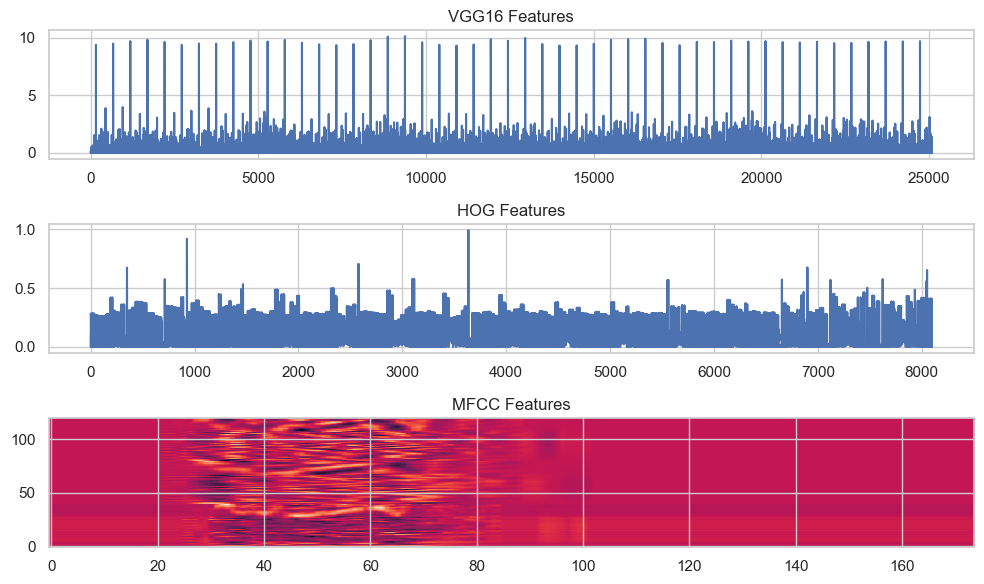

In [140]:
import os
import random
import cv2
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import joblib
from skimage.feature import hog
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load pre-trained models
facial_model = load_model('/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5')
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')

# Load VGG16 for feature extraction
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer('block5_pool').output)

# Freeze VGG16 layers
for layer in vgg_model.layers:
    layer.trainable = False

# Define HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True,
}

# Helper functions for feature extraction
def extract_frames(video_path, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_interval = fps // frame_rate

    while cap.isOpened():
        frame_id = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % frame_interval == 0:
            frames.append(frame)
    cap.release()
    return frames

def preprocess_frame(frame, target_size=(224, 224)):
    frame = cv2.resize(frame, target_size)
    frame = frame.astype('float32') / 255.0
    frame = np.expand_dims(frame, axis=0)
    return frame

def extract_audio(video_path, sr=16000):
    y, sr = librosa.load(video_path, sr=sr)
    return y, sr

def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

    if combined_features.shape[1] < max_length:
        padding = max_length - combined_features.shape[1]
        combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
    else:
        combined_features = combined_features[:, :max_length]

    combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                        (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
    return combined_features

def extract_hog_features(frame, target_size=(128, 128)):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, target_size)
    hog_features, _ = hog(resized_frame, **hog_params, visualize=True)
    return hog_features

def predict_facial_emotion(frames):
    predictions = []
    for frame in frames:
        preprocessed_frame = preprocess_frame(frame)
        vgg_features = vgg_model.predict(preprocessed_frame).flatten()
        hog_features = extract_hog_features(frame)
        combined_features = np.hstack((vgg_features, hog_features)).reshape(1, -1)
        pred = facial_model.predict(combined_features)
        predictions.append(pred)
    return np.mean(predictions, axis=0)

def predict_speech_emotion(audio, sr, segment_duration=2):
    segment_length = sr * segment_duration
    predictions = []
    for i in range(0, len(audio), segment_length):
        segment = audio[i:i + segment_length]
        if len(segment) < segment_length:
            continue
        mfcc_features = extract_mfcc_features(segment, sr)
        pred = speech_model.predict(np.expand_dims(mfcc_features.T, axis=0))
        predictions.append(pred)
    return np.mean(predictions, axis=0)

def fuse_predictions(face_probs, speech_probs, weights=(0.6, 0.4)):
    return weights[0] * face_probs + weights[1] * speech_probs

# Main execution
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

selected_emotion = input(f"Select an emotion from {emotions}: ")
assert selected_emotion in emotions, "Invalid emotion selected."

# Collect videos for the selected emotion
emotion_dir = os.path.join(video_data_directory, selected_emotion)
videos = [os.path.join(emotion_dir, file) for file in os.listdir(emotion_dir) if file.endswith('.mp4')]

selected_video = random.choice(videos)
frames = extract_frames(selected_video)
audio, sr = extract_audio(selected_video)

# Predictions
face_probs = predict_facial_emotion(frames)
speech_probs = predict_speech_emotion(audio, sr)
fused_probs = fuse_predictions(face_probs, speech_probs)

# Decode predictions
face_emotion = le.inverse_transform([np.argmax(face_probs)])[0]
speech_emotion = le.inverse_transform([np.argmax(speech_probs)])[0]
fused_emotion = le.inverse_transform([np.argmax(fused_probs)])[0]

print(f"Original Emotion: {selected_emotion}")
print(f"Facial Model Prediction: {face_emotion}")
print(f"Speech Model Prediction: {speech_emotion}")
print(f"Fused Model Prediction: {fused_emotion}")

# Visualizations
plt.figure(figsize=(10, 6))

# VGG16 Features
vgg_features = vgg_model.predict(preprocess_frame(frames[0])).flatten()
plt.subplot(3, 1, 1)
plt.plot(vgg_features)
plt.title("VGG16 Features")

# HOG Features
hog_features = extract_hog_features(frames[0])
plt.subplot(3, 1, 2)
plt.plot(hog_features)
plt.title("HOG Features")

# MFCC Features
mfcc_features = extract_mfcc_features(audio, sr)
plt.subplot(3, 1, 3)
plt.imshow(mfcc_features, aspect='auto', origin='lower')
plt.title("MFCC Features")

plt.tight_layout()
plt.show()


# COMBINED VISUALIZATIONS FOR REPORT

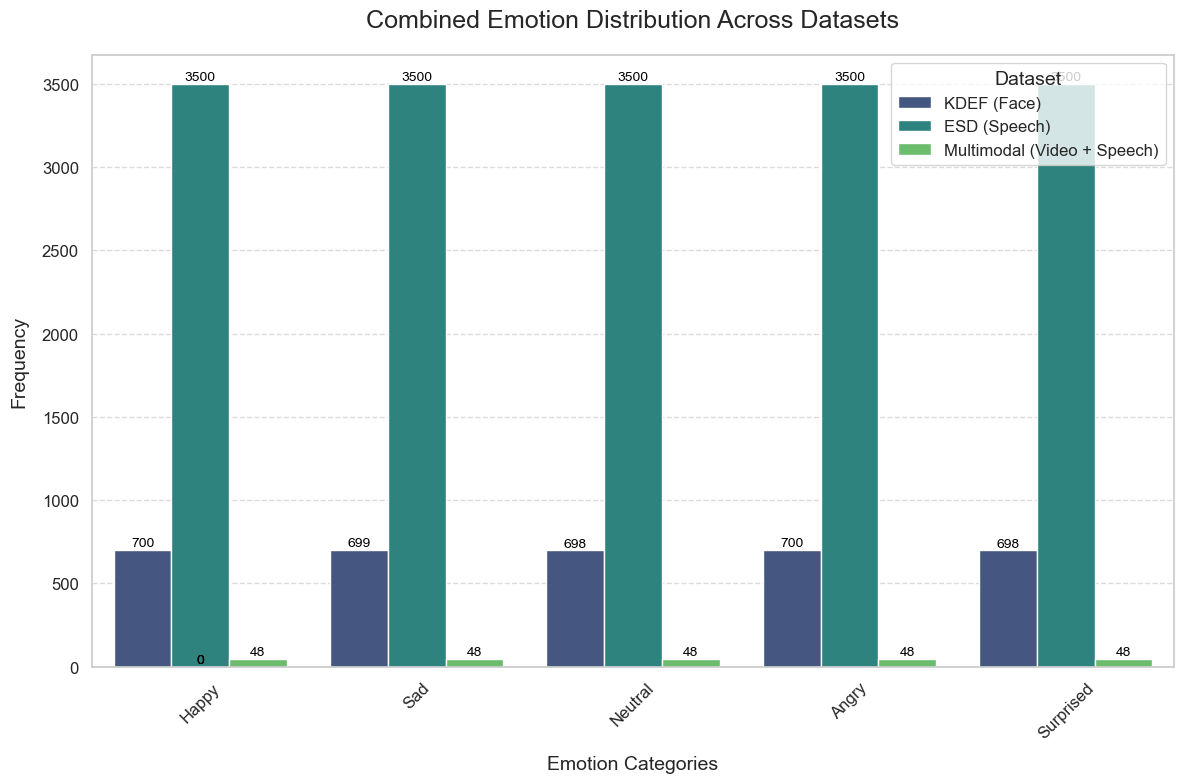

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize column names in each DataFrame
image_df = image_df.rename(columns={'image_label': 'Emotion'})
speech_df = speech_df.rename(columns={'speech_label': 'Emotion'})
multimodel_df = multimodel_df.rename(columns={'true_labels': 'Emotion'})

# Add dataset type for each DataFrame
image_df['Dataset'] = 'KDEF (Face)'
speech_df['Dataset'] = 'ESD (Speech)'
multimodel_df['Dataset'] = 'Multimodal (Video + Speech)'

# Concatenate all DataFrames
combined_df = pd.concat([image_df[['Emotion', 'Dataset']],
                         speech_df[['Emotion', 'Dataset']],
                         multimodel_df[['Emotion', 'Dataset']]], 
                        axis=0, ignore_index=True)

# Set theme
sns.set_theme(style="whitegrid")

# Create the count plot
plt.figure(figsize=(12, 8))  # Larger figure for combined data
ax = sns.countplot(data=combined_df, x='Emotion', hue='Dataset', palette="viridis")

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

# Add title and labels
plt.title('Combined Emotion Distribution Across Datasets', fontsize=18, pad=20)
plt.xlabel('Emotion Categories', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Move the legend to the upper right corner
plt.legend(loc='upper right', fontsize=12, title='Dataset', title_fontsize=14)

# Adjust layout
plt.tight_layout()

# Save the plot as an image
plt.savefig("combined_emotion_distribution.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


Skipped .DS_Store, as it is not in emotions list.

Face Dataset Loaded
Total valid files: 3495
Failed files: 0


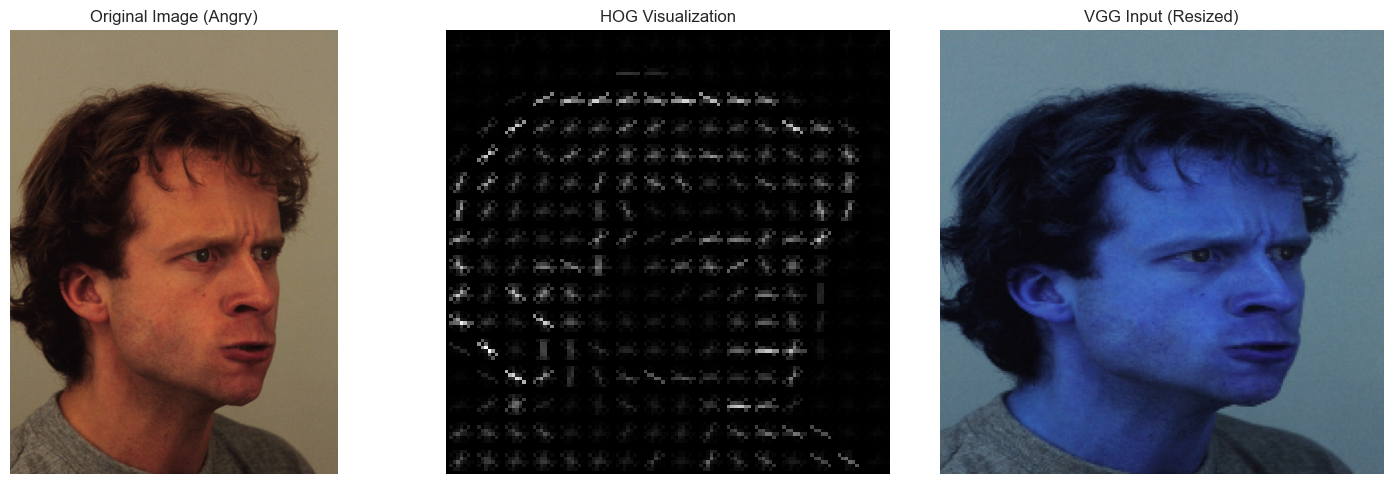

Emotion: Angry
Random Index: 2619
Selected Image Path: /Users/vinayadusumilli/MastersProject/FaceData/Angry/BM34ANHR.JPG
Original Image Shape: (762, 562, 3)
Gray Image Shape: (128, 128)
VGG Resized Shape: (224, 224, 3)


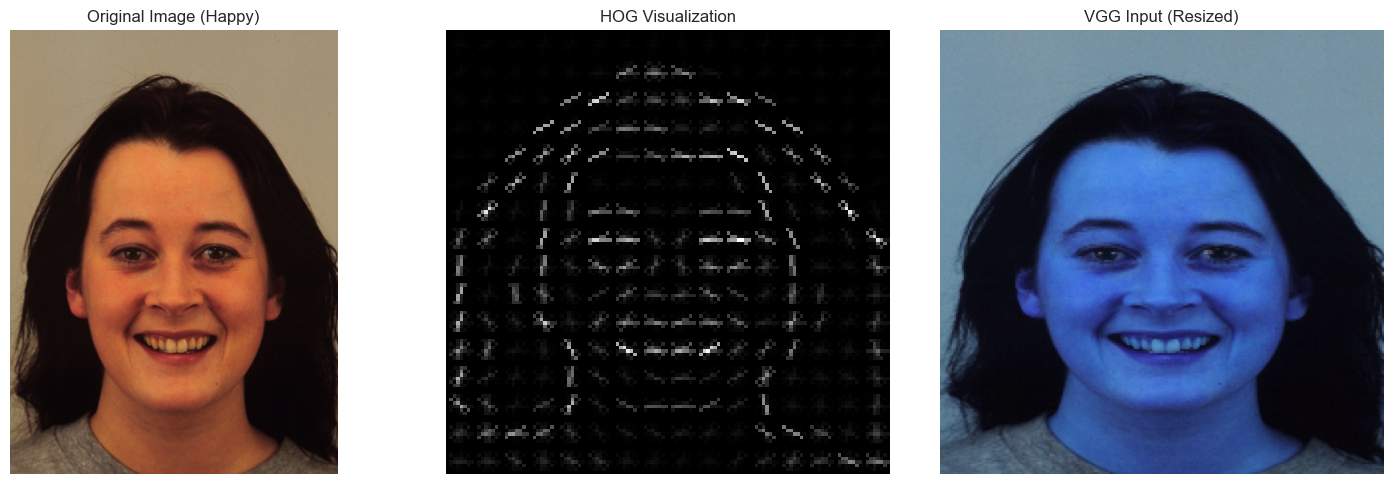

Emotion: Happy
Random Index: 608
Selected Image Path: /Users/vinayadusumilli/MastersProject/FaceData/Happy/AF14HAS.JPG
Original Image Shape: (762, 562, 3)
Gray Image Shape: (128, 128)
VGG Resized Shape: (224, 224, 3)


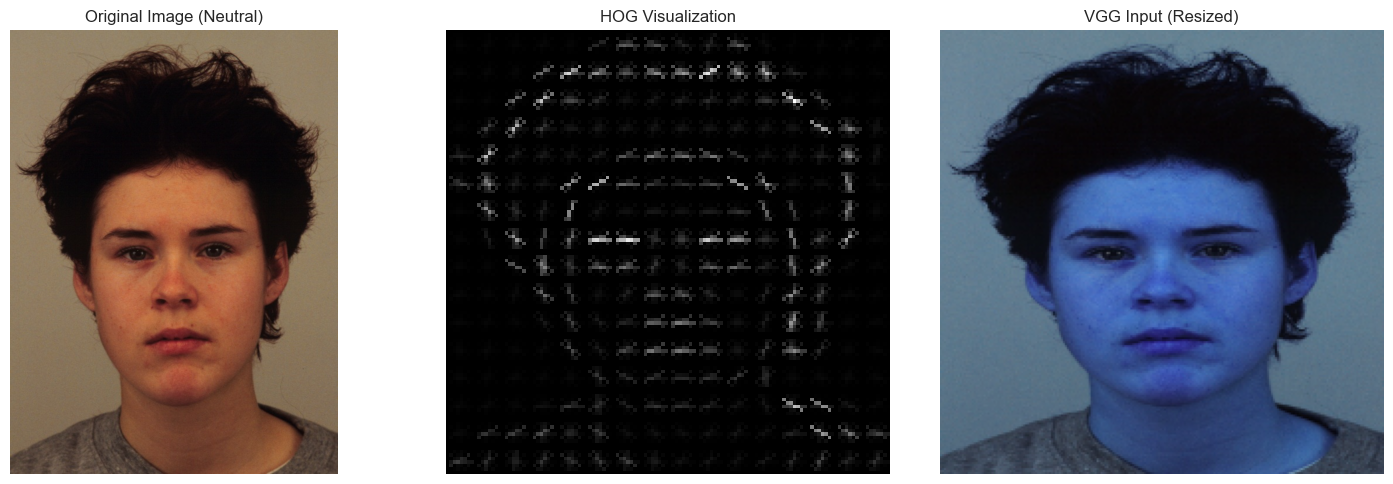

Emotion: Neutral
Random Index: 1816
Selected Image Path: /Users/vinayadusumilli/MastersProject/FaceData/Neutral/AF35NES.JPG
Original Image Shape: (762, 562, 3)
Gray Image Shape: (128, 128)
VGG Resized Shape: (224, 224, 3)


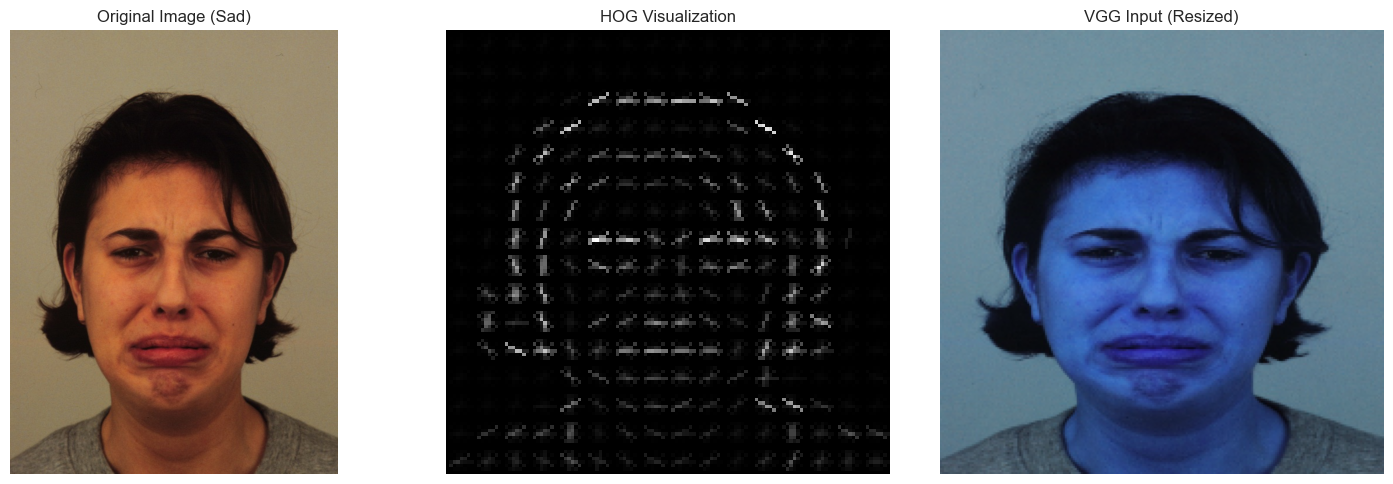

Emotion: Sad
Random Index: 1226
Selected Image Path: /Users/vinayadusumilli/MastersProject/FaceData/Sad/BF17SAS.JPG
Original Image Shape: (762, 562, 3)
Gray Image Shape: (128, 128)
VGG Resized Shape: (224, 224, 3)


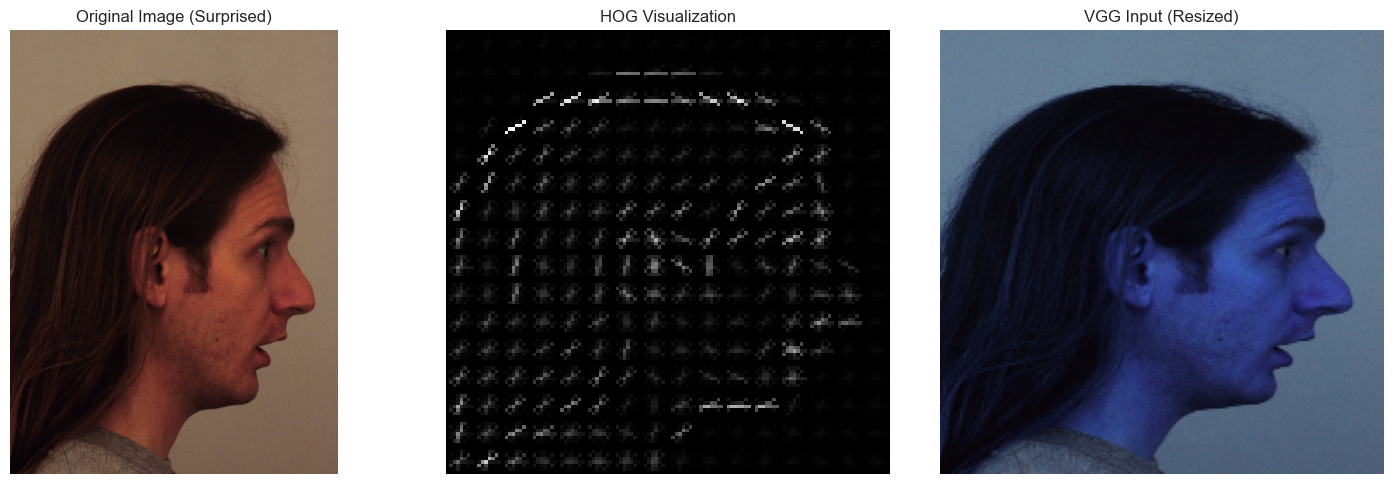

Emotion: Surprised
Random Index: 3469
Selected Image Path: /Users/vinayadusumilli/MastersProject/FaceData/Surprised/AM03SUFR.JPG
Original Image Shape: (762, 562, 3)
Gray Image Shape: (128, 128)
VGG Resized Shape: (224, 224, 3)


In [154]:
import os
import random
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2

# Face data directory
face_data_directory = '/Users/vinayadusumilli/MastersProject/FaceData'

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Lists to store data
hog_features = []
vgg_features = []
image_labels = []
image_paths = []
failed_images = []

# Iterate over each emotion folder
for label in os.listdir(face_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(face_data_directory, label)

        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process image files for face data
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        if os.path.getsize(file_path) > 0:  # Check for empty files
                            image_paths.append(file_path)
                            image_labels.append(label)
                        else:
                            failed_images.append(file_path)
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

# Summarize the dataset
print("\nFace Dataset Loaded")
print(f"Total valid files: {len(image_paths)}")
print(f"Failed files: {len(failed_images)}")

# Create a DataFrame
image_df = pd.DataFrame({
    'image_paths': image_paths,
    'image_label': image_labels
})

# Validate length consistency
assert len(image_paths) == len(image_labels), "Mismatch between image paths and labels!"

# Visualization function
def visualize_features_for_emotion(emotion, image_paths, image_labels, hog_params):
    """
    Visualizes the original image, HOG visualization, and VGG16 input for a randomly selected image of a specific emotion.

    Args:
        emotion (str): The emotion to visualize.
        image_paths (list): List of file paths to the original images.
        image_labels (list): List of emotion labels corresponding to images.
        hog_params (dict): Parameters for HOG feature extraction.

    Returns:
        None
    """
    # Find indices for images with the given emotion
    indices = [i for i, label in enumerate(image_labels) if label == emotion]
    if not indices:
        print(f"No images found for the specified emotion: {emotion}.")
        return

    # Randomly selecting one image
    random_index = random.choice(indices)
    image_path = image_paths[random_index]

    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Regenerate HOG visualization
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_resized = cv2.resize(gray_image, (128, 128))
    _, hog_visualization = hog(
        gray_resized,
        orientations=hog_params['orientations'],
        pixels_per_cell=hog_params['pixels_per_cell'],
        cells_per_block=hog_params['cells_per_block'],
        block_norm=hog_params['block_norm'],
        visualize=True,
        transform_sqrt=hog_params['transform_sqrt']
    )

    # Resize image for VGG input
    vgg_resized = cv2.resize(image, (224, 224))

    # Plot the original image, HOG visualization, and VGG input
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original_image)
    axs[0].set_title(f"Original Image ({emotion})")
    axs[0].axis('off')

    axs[1].imshow(hog_visualization, cmap='gray')
    axs[1].set_title("HOG Visualization")
    axs[1].axis('off')

    axs[2].imshow(vgg_resized)
    axs[2].set_title("VGG Input (Resized)")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Emotion: {emotion}")
    print(f"Random Index: {random_index}")
    print(f"Selected Image Path: {image_path}")
    print(f"Original Image Shape: {image.shape}")
    print(f"Gray Image Shape: {gray_resized.shape}")
    print(f"VGG Resized Shape: {vgg_resized.shape}")

# Visualize features for different emotions
for emotion in emotions:
    visualize_features_for_emotion(
        emotion=emotion,
        image_paths=image_paths,
        image_labels=image_labels,
        hog_params=hog_params
    )


In [162]:
import os
import random
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2

# Face data directory
face_data_directory = '/Users/vinayadusumilli/MastersProject/FaceData'

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Lists to store data
hog_features = []
vgg_features = []
image_labels = []
image_paths = []
failed_images = []

# Output directory for plots
output_dir = 'results/plots'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each emotion folder
for label in os.listdir(face_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(face_data_directory, label)

        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process image files for face data
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        if os.path.getsize(file_path) > 0:  # Check for empty files
                            image_paths.append(file_path)
                            image_labels.append(label)
                        else:
                            failed_images.append(file_path)
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

# Summarize the dataset
print("\nFace Dataset Loaded")
print(f"Total valid files: {len(image_paths)}")
print(f"Failed files: {len(failed_images)}")

# Create a DataFrame
image_df = pd.DataFrame({
    'image_paths': image_paths,
    'image_label': image_labels
})

# Validate length consistency
assert len(image_paths) == len(image_labels), "Mismatch between image paths and labels!"

# Visualization function
def visualize_all_features(emotions, image_paths, image_labels, hog_params, output_path):
    """
    Visualizes the original image, HOG visualization, and VGG16 input for randomly selected images of each emotion and saves as a single plot.

    Args:
        emotions (list): List of emotions to visualize.
        image_paths (list): List of file paths to the original images.
        image_labels (list): List of emotion labels corresponding to images.
        hog_params (dict): Parameters for HOG feature extraction.
        output_path (str): Path to save the combined visualization plot.

    Returns:
        None
    """
    fig, axs = plt.subplots(len(emotions), 3, figsize=(15, 5 * len(emotions)))

    for idx, emotion in enumerate(emotions):
        # Find indices for images with the given emotion
        indices = [i for i, label in enumerate(image_labels) if label == emotion]
        if not indices:
            print(f"No images found for the specified emotion: {emotion}.")
            continue

        # Randomly selecting one image
        random_index = random.choice(indices)
        image_path = image_paths[random_index]

        # Load the original image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Regenerate HOG visualization
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray_image, (128, 128))
        _, hog_visualization = hog(
            gray_resized,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block'],
            block_norm=hog_params['block_norm'],
            visualize=True,
            transform_sqrt=hog_params['transform_sqrt']
        )

        # Resize image for VGG input
        vgg_resized = cv2.resize(image, (224, 224))

        # Plot the original image, HOG visualization, and VGG input
        axs[idx, 0].imshow(original_image)
        axs[idx, 0].set_title(f"Original Image ({emotion})")
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(hog_visualization, cmap='gray')
        axs[idx, 1].set_title("HOG Visualization")
        axs[idx, 1].axis('off')

        axs[idx, 2].imshow(vgg_resized)
        axs[idx, 2].set_title("VGG Input (Resized)")
        axs[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Combined visualization saved at {output_path}")

# Save combined visualizations for all emotions
output_path = os.path.join(output_dir, "combined_features_visualization.png")
visualize_all_features(emotions, image_paths, image_labels, hog_params, output_path)


Skipped .DS_Store, as it is not in emotions list.

Face Dataset Loaded
Total valid files: 3495
Failed files: 0
Combined visualization saved at results/plots/combined_features_visualization.png


In [164]:
import os
import random
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2
import numpy as np

# Face data directory
face_data_directory = '/Users/vinayadusumilli/MastersProject/FaceData'

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Lists to store data
hog_features = []
vgg_features = []
image_labels = []
image_paths = []
failed_images = []

# Output directory for plots
output_dir = 'results/plots'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each emotion folder
for label in os.listdir(face_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(face_data_directory, label)

        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process image files for face data
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        if os.path.getsize(file_path) > 0:  # Check for empty files
                            image_paths.append(file_path)
                            image_labels.append(label)
                        else:
                            failed_images.append(file_path)
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

# Summarize the dataset
print("\nFace Dataset Loaded")
print(f"Total valid files: {len(image_paths)}")
print(f"Failed files: {len(failed_images)}")

# Create a DataFrame
image_df = pd.DataFrame({
    'image_paths': image_paths,
    'image_label': image_labels
})

# Validate length consistency
assert len(image_paths) == len(image_labels), "Mismatch between image paths and labels!"

# Visualization and feature extraction function
def visualize_and_extract_features(emotions, image_paths, image_labels, hog_params, output_path):
    """
    Visualizes the original image, HOG visualization, and VGG16 input for randomly selected images of each emotion,
    saves as a single plot, and extracts sample features.

    Args:
        emotions (list): List of emotions to visualize.
        image_paths (list): List of file paths to the original images.
        image_labels (list): List of emotion labels corresponding to images.
        hog_params (dict): Parameters for HOG feature extraction.
        output_path (str): Path to save the combined visualization plot.

    Returns:
        pd.DataFrame: DataFrame containing extracted feature samples for each emotion.
    """
    fig, axs = plt.subplots(len(emotions), 3, figsize=(15, 5 * len(emotions)))
    feature_samples = []

    for idx, emotion in enumerate(emotions):
        # Find indices for images with the given emotion
        indices = [i for i, label in enumerate(image_labels) if label == emotion]
        if not indices:
            print(f"No images found for the specified emotion: {emotion}.")
            continue

        # Randomly selecting one image
        random_index = random.choice(indices)
        image_path = image_paths[random_index]

        # Load the original image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue

        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Regenerate HOG visualization and extract features
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray_image, (128, 128))
        hog_feature, hog_visualization = hog(
            gray_resized,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block'],
            block_norm=hog_params['block_norm'],
            visualize=True,
            transform_sqrt=hog_params['transform_sqrt']
        )

        # Resize image for VGG input
        vgg_resized = cv2.resize(image, (224, 224))
        vgg_feature = vgg_resized.flatten()

        # Collect feature samples
        feature_samples.append({
            "Emotion": emotion,
            "HOG Feature Sample": hog_feature[:10].tolist(),
            "VGG Feature Sample": vgg_feature[:10].tolist()
        })

        # Plot the original image, HOG visualization, and VGG input
        axs[idx, 0].imshow(original_image)
        axs[idx, 0].set_title(f"Original Image ({emotion})")
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(hog_visualization, cmap='gray')
        axs[idx, 1].set_title("HOG Visualization")
        axs[idx, 1].axis('off')

        axs[idx, 2].imshow(vgg_resized)
        axs[idx, 2].set_title("VGG Input (Resized)")
        axs[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Combined visualization saved at {output_path}")

    return pd.DataFrame(feature_samples)

# Save combined visualizations for all emotions and extract features
output_path = os.path.join(output_dir, "combined_features_visualization.png")
features_df = visualize_and_extract_features(emotions, image_paths, image_labels, hog_params, output_path)

# Print feature samples
print("\nExtracted Feature Samples:")
print(features_df)


Skipped .DS_Store, as it is not in emotions list.

Face Dataset Loaded
Total valid files: 3495
Failed files: 0
Combined visualization saved at results/plots/combined_features_visualization.png

Extracted Feature Samples:
     Emotion                                 HOG Feature Sample  \
0      Angry  [0.24270347805322579, 0.07718935961716562, 0.2...   
1      Happy  [0.2313748967695684, 0.02854635648563171, 0.15...   
2    Neutral  [0.2381038113600652, 0.09318233989712978, 0.17...   
3        Sad  [0.2323782684579806, 0.2323782684579806, 0.180...   
4  Surprised  [0.23568206120135796, 0.03724381425270842, 0.0...   

                                  VGG Feature Sample  
0  [103, 129, 146, 110, 133, 149, 111, 131, 144, ...  
1  [107, 136, 151, 100, 130, 145, 106, 137, 151, ...  
2  [123, 149, 161, 117, 147, 161, 115, 147, 163, ...  
3  [117, 140, 156, 120, 138, 155, 122, 137, 155, ...  
4  [106, 136, 152, 110, 133, 151, 110, 134, 153, ...  


In [177]:
import os
import random
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2

# Face data directory
face_data_directory = '/Users/vinayadusumilli/MastersProject/FaceData'

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# HOG parameters
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True
}

# Lists to store data
image_labels = []
image_paths = []
failed_images = []

# Output directory for plots
output_dir = 'results/plots'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each emotion folder
for label in os.listdir(face_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(face_data_directory, label)

        if os.path.isdir(emotion_dir):
            for file in os.listdir(emotion_dir):
                file_path = os.path.join(emotion_dir, file)
                # Process image files for face data
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    if os.path.getsize(file_path) > 0:  # Check for empty files
                        image_paths.append(file_path)
                        image_labels.append(label)
                    else:
                        failed_images.append(file_path)

# Summarize the dataset
print("\nFace Dataset Loaded")
print(f"Total valid files: {len(image_paths)}")
print(f"Failed files: {len(failed_images)}")

# Create a DataFrame
image_df = pd.DataFrame({
    'image_paths': image_paths,
    'image_label': image_labels
})

# Validate length consistency
assert len(image_paths) == len(image_labels), "Mismatch between image paths and labels!"

# Visualization and feature extraction function
def visualize_and_extract_features(emotions, image_paths, image_labels, hog_params, output_path):
    fig, axs = plt.subplots(len(emotions), 3, figsize=(15, 5 * len(emotions)))
    feature_samples = []

    for idx, emotion in enumerate(emotions):
        # Find indices for images with the given emotion
        indices = [i for i, label in enumerate(image_labels) if label == emotion]
        if not indices:
            continue

        # Randomly selecting one image
        random_index = random.choice(indices)
        image_path = image_paths[random_index]

        # Load the original image
        image = cv2.imread(image_path)
        if image is None:
            continue

        original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Regenerate HOG visualization and extract features
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray_image, (128, 128))
        hog_feature, hog_visualization = hog(
            gray_resized,
            orientations=hog_params['orientations'],
            pixels_per_cell=hog_params['pixels_per_cell'],
            cells_per_block=hog_params['cells_per_block'],
            block_norm=hog_params['block_norm'],
            visualize=True,
            transform_sqrt=hog_params['transform_sqrt']
        )

        # Resize image for VGG input
        vgg_resized = cv2.resize(image, (224, 224))
        vgg_feature = vgg_resized.flatten()

        # Collect feature samples
        feature_samples.append({
            "Emotion": emotion,
            "HOG Feature Sample": hog_feature[:10].tolist(),
            "VGG Feature Sample": vgg_feature[:10].tolist()
        })

        # Plot the original image, HOG visualization, and VGG input
        axs[idx, 0].imshow(original_image)
        axs[idx, 0].set_title(f"Original Image ({emotion})")
        axs[idx, 0].axis('off')

        axs[idx, 1].imshow(hog_visualization, cmap='gray')
        axs[idx, 1].set_title("HOG Visualization")
        axs[idx, 1].axis('off')

        axs[idx, 2].imshow(vgg_resized)
        axs[idx, 2].set_title("VGG Input (Resized)")
        axs[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"Combined visualization saved at {output_path}")

    return pd.DataFrame(feature_samples)

# Save combined visualizations for all emotions and extract features
output_path = os.path.join(output_dir, "combined_features_visualization.png")
features_df = visualize_and_extract_features(emotions, image_paths, image_labels, hog_params, output_path)

# Combine the features into a single DataFrame for display
features_table = pd.DataFrame({
    'Emotion': [sample['Emotion'] for sample in features_df.to_dict('records')],
    'HOG Feature Sample': [', '.join(map(str, sample['HOG Feature Sample'])) for sample in features_df.to_dict('records')],
    'VGG Feature Sample': [', '.join(map(str, sample['VGG Feature Sample'])) for sample in features_df.to_dict('records')],
})

# Save the features table to a CSV file
features_table.to_csv('extracted_features_table.csv', index=False)
print("Feature table saved as 'extracted_features_table.csv'.")

# Print the features table
print("\nExtracted Feature Table:")
print(features_table)



Face Dataset Loaded
Total valid files: 3495
Failed files: 0
Combined visualization saved at results/plots/combined_features_visualization.png
Feature table saved as 'extracted_features_table.csv'.

Extracted Feature Table:
     Emotion                                 HOG Feature Sample  \
0      Angry  0.01943799101479542, 0.004538723558280014, 0.0...   
1      Happy  0.2298872421695161, 0.11022854118205885, 0.069...   
2    Neutral  0.24004680776971346, 0.11213935817183315, 0.16...   
3        Sad  0.19378374225752143, 0.12156436672178227, 0.06...   
4  Surprised  0.23676113553566908, 0.16447665454423951, 0.20...   

                                 VGG Feature Sample  
0  111, 134, 150, 110, 135, 151, 110, 136, 153, 108  
1    103, 129, 153, 98, 130, 153, 97, 128, 150, 102  
2  118, 136, 153, 118, 136, 154, 118, 138, 155, 115  
3  110, 136, 150, 109, 135, 151, 107, 133, 150, 108  
4  108, 128, 147, 109, 132, 148, 107, 132, 148, 108  


In [165]:
import os
from collections import Counter
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Speech data directory
data_directory = "/Users/vinayadusumilli/MastersProject/SpeechData"

speech_paths = []
speech_labels = []

# Iterating over each emotion folder and process the audio files
for label in os.listdir(data_directory):
    emotion_dir = os.path.join(data_directory, label)
    
    if os.path.isdir(emotion_dir):
        file_count = 0
        for file in os.listdir(emotion_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(emotion_dir, file)
                speech_paths.append(file_path)
                speech_labels.append(label)
                file_count += 1
        print(f"Processed folder: {label}, Files found: {file_count}")
    else:
        print(f"Skipping {label}: Not a directory.")

# Summary
print("\nDataset is Loaded")
print(f"Total files: {len(speech_paths)}")
print(f"Label distribution: {Counter(speech_labels)}")

# Create a DataFrame
speech_df = pd.DataFrame({
    'speech_paths': speech_paths,
    'speech_label': speech_labels
})

# Validate length consistency
assert len(speech_paths) == len(speech_labels), "Mismatch between audio paths and labels!"

# Visualization functions
def waveplot(data, sr, emotion, ax):
    ax.set_title(f"Waveform: {emotion}", size=14)
    librosa.display.waveshow(data, sr=sr, ax=ax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")

def spectrogram(data, sr, emotion, ax):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    img = librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma", ax=ax)
    ax.set_title(f"Spectrogram: {emotion}", size=14)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")
    return img

# Visualize all emotions in one figure
output_path = "results/speech_visualizations.png"
os.makedirs("results", exist_ok=True)
fig, axs = plt.subplots(len(speech_df['speech_label'].unique()), 2, figsize=(15, 5 * len(speech_df['speech_label'].unique())))

for i, emotion in enumerate(speech_df['speech_label'].unique()):
    path = speech_df[speech_df['speech_label'] == emotion]['speech_paths'].iloc[0]  # Get the first file path for the emotion
    data, sampling_rate = librosa.load(path, sr=16000)

    # Plot waveform
    waveplot(data, sampling_rate, emotion, axs[i, 0])

    # Plot spectrogram
    img = spectrogram(data, sampling_rate, emotion, axs[i, 1])
    fig.colorbar(img, ax=axs[i, 1], format="%+2.0f dB")

plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"Combined visualization saved at {output_path}")


Processed folder: Happy, Files found: 3500
Skipping .DS_Store: Not a directory.
Processed folder: Sad, Files found: 3500
Processed folder: Neutral, Files found: 3500
Processed folder: Angry, Files found: 3500
Processed folder: Surprised, Files found: 3500

Dataset is Loaded
Total files: 17500
Label distribution: Counter({'Happy': 3500, 'Sad': 3500, 'Neutral': 3500, 'Angry': 3500, 'Surprised': 3500})
Combined visualization saved at results/speech_visualizations.png


In [180]:
import os
from collections import Counter
import pandas as pd
import librosa
import numpy as np

# Speech data directory
data_directory = "/Users/vinayadusumilli/MastersProject/SpeechData"

speech_paths = []
speech_labels = []

# Iterating over each emotion folder and process the audio files
for label in os.listdir(data_directory):
    emotion_dir = os.path.join(emotion_dir, label)
    
    if os.path.isdir(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(emotion_dir, file)
                speech_paths.append(file_path)
                speech_labels.append(label)
    else:
        print(f"Skipping {label}: Not a directory.")

# Create a DataFrame
speech_df = pd.DataFrame({
    'speech_paths': speech_paths,
    'speech_label': speech_labels
})

# Select one file per label
unique_labels = speech_df['speech_label'].unique()
representative_files = speech_df.groupby('speech_label').first().reset_index()

# Function to extract features
def extract_audio_features(file_path):
    try:
        data, sr = librosa.load(file_path, sr=16000)
        
        # Extract features
        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=10).mean(axis=1)  # Top 10 MFCCs
        spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(data).mean()
        
        return {
            'MFCC_1': mfccs[0],
            'MFCC_2': mfccs[1],
            'MFCC_3': mfccs[2],
            'MFCC_4': mfccs[3],
            'MFCC_5': mfccs[4],
            'MFCC_6': mfccs[5],
            'MFCC_7': mfccs[6],
            'MFCC_8': mfccs[7],
            'MFCC_9': mfccs[8],
            'MFCC_10': mfccs[9],
            'Spectral_Centroid': spectral_centroid,
            'Zero_Crossing_Rate': zero_crossing_rate,
        }
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Extract features for representative files
features_list = []
for _, row in representative_files.iterrows():
    path = row['speech_paths']
    label = row['speech_label']
    features = extract_audio_features(path)
    if features:
        features['Label'] = label
        features_list.append(features)

# Create a DataFrame with features
features_df = pd.DataFrame(features_list)

# Display the feature table
print("\nExtracted Features (One per Label):")
print(features_df)

# Save the features as a CSV file
features_df.to_csv("results/representative_audio_features.csv", index=False)
print("Representative features saved as 'results/representative_audio_features.csv'.")


Skipping Happy: Not a directory.
Skipping .DS_Store: Not a directory.
Skipping Sad: Not a directory.
Skipping Neutral: Not a directory.
Skipping Angry: Not a directory.
Skipping Surprised: Not a directory.

Extracted Features (One per Label):
Empty DataFrame
Columns: []
Index: []
Representative features saved as 'results/representative_audio_features.csv'.


In [181]:
import os
from collections import Counter
import pandas as pd
import librosa
import numpy as np

# Speech data directory
data_directory = "/Users/vinayadusumilli/MastersProject/SpeechData"

speech_paths = []
speech_labels = []

# Iterating over each emotion folder and process the audio files
for label in os.listdir(data_directory):
    emotion_dir = os.path.join(data_directory, label)
    
    if os.path.isdir(emotion_dir):
        for file in os.listdir(emotion_dir):
            if file.lower().endswith('.wav'):
                file_path = os.path.join(emotion_dir, file)
                speech_paths.append(file_path)
                speech_labels.append(label)
    else:
        print(f"Skipping {label}: Not a directory.")

# Create a DataFrame
speech_df = pd.DataFrame({
    'speech_paths': speech_paths,
    'speech_label': speech_labels
})

# Validate length consistency
assert len(speech_paths) == len(speech_labels), "Mismatch between audio paths and labels!"

# Function to extract features
def extract_audio_features(file_path):
    try:
        data, sr = librosa.load(file_path, sr=16000)
        
        # Extract features
        mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=10).mean(axis=1)  # Top 10 MFCCs
        spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(data).mean()
        
        return {
            'MFCC_1': mfccs[0],
            'MFCC_2': mfccs[1],
            'MFCC_3': mfccs[2],
            'MFCC_4': mfccs[3],
            'MFCC_5': mfccs[4],
            'MFCC_6': mfccs[5],
            'MFCC_7': mfccs[6],
            'MFCC_8': mfccs[7],
            'MFCC_9': mfccs[8],
            'MFCC_10': mfccs[9],
            'Spectral_Centroid': spectral_centroid,
            'Zero_Crossing_Rate': zero_crossing_rate,
        }
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

# Select one file per label and extract features
features_list = []
for label in speech_df['speech_label'].unique():
    representative_file = speech_df[speech_df['speech_label'] == label]['speech_paths'].iloc[0]
    features = extract_audio_features(representative_file)
    if features:
        features['Label'] = label
        features_list.append(features)

# Create a DataFrame with features
features_df = pd.DataFrame(features_list)

# Display the feature table
print("\nExtracted Features (One per Label):")
print(features_df)

# Save the features as a CSV file
features_df.to_csv("results/representative_audio_features.csv", index=False)
print("Representative features saved as 'results/representative_audio_features.csv'.")


Skipping .DS_Store: Not a directory.

Extracted Features (One per Label):
       MFCC_1     MFCC_2     MFCC_3     MFCC_4     MFCC_5     MFCC_6  \
0 -443.595703  52.926956 -15.867807  28.630779  -1.497275 -12.576574   
1 -390.093567  84.913078   4.279269  23.026646   1.158692  11.559284   
2 -455.065033  67.321342  25.174225  23.727406  11.582384  10.664998   
3 -345.648560  58.190342 -29.773712   2.280216 -28.142681  -3.213748   
4 -348.989594  51.536564 -17.422073   4.669753 -22.908020 -19.814178   

      MFCC_7     MFCC_8    MFCC_9   MFCC_10  Spectral_Centroid  \
0  -1.775840 -23.875380 -1.565211 -4.368305        2085.408734   
1   2.365340   4.723543  1.548584  6.202133        1384.008494   
2 -10.818310  -3.407797  2.058788 -2.133247        1727.554405   
3   2.210498  -0.948666  8.092078 -1.187119        1574.086938   
4 -22.031061 -11.545718  0.326417  1.266744        1862.156746   

   Zero_Crossing_Rate      Label  
0            0.130954      Happy  
1            0.075943     

In [171]:
import os
import cv2
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import joblib

# Video data directory
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Lists to store paths and labels
true_labels = []
video_paths = []

# Iterate over each emotion folder
for label in os.listdir(video_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(video_data_directory, label)
        
        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process video files
                    if file.lower().endswith(('.mp4')):
                        if os.path.getsize(file_path) > 0:
                            video_paths.append(file_path)
                            true_labels.append(label)
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

print("Dataset Loaded")
print(f"Total files: {len(video_paths)}")

# Create a DataFrame
multimodel_df = pd.DataFrame({
    'video_paths': video_paths,
    'true_labels': true_labels
})

# Validate length consistency
assert len(video_paths) == len(true_labels), "Mismatch between video paths and labels!"

# Load pre-trained models
facial_model = load_model("/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5")
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')

# Recompile models with metrics to resolve warnings
facial_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
speech_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load label encoder
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')
print("Loaded classes:", le.classes_)

# Load pre-trained VGG16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_combined_features(frame):
    """
    Extract combined features (VGG16 + padding or additional features).

    Args:
        frame (np.ndarray): Input frame of shape (H, W, C).

    Returns:
        np.ndarray: Combined feature vector of shape (33188,).
    """
    resized_frame = cv2.resize(frame, (224, 224))
    resized_frame = preprocess_input(resized_frame.astype('float32'))
    vgg16_features = vgg16.predict(np.expand_dims(resized_frame, axis=0)).flatten()

    # Pad or concatenate additional features to match 33188
    additional_features = np.zeros(33188 - len(vgg16_features))
    combined_features = np.concatenate([vgg16_features, additional_features])

    return combined_features

# Visualization function
def visualize_multimodal(video_path, facial_model, speech_model, le, save_path):
    """
    Visualizes multimodal predictions: frames and audio features with predictions.

    Args:
        video_path (str): Path to the video file.
        facial_model: Pre-trained facial emotion recognition model.
        speech_model: Pre-trained speech emotion recognition model.
        le: Label encoder for speech model.
        save_path (str): Path to save the visualization.

    Returns:
        None
    """
    # Extract frames and audio
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    audio, sr = librosa.load(video_path, sr=16000)

    # Facial model prediction using combined features
    combined_features = extract_combined_features(frame)
    facial_pred = np.argmax(facial_model.predict(np.expand_dims(combined_features, axis=0)), axis=1)
    facial_emotion = emotions[facial_pred[0]]

    # Speech model prediction
    mfcc_features = extract_mfcc_features(audio, sr=sr)
    speech_pred = np.argmax(speech_model.predict(mfcc_features), axis=1)
    speech_emotion = le.inverse_transform(speech_pred)[0]

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Frame with facial emotion
    axs[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title(f"Facial Emotion: {facial_emotion}", size=14)
    axs[0, 0].axis('off')

    # Waveform with speech emotion
    axs[1, 0].set_title(f"Speech Emotion: {speech_emotion}", size=14)
    librosa.display.waveshow(audio, sr=sr, ax=axs[1, 0])
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Amplitude")

    # Spectrogram
    x = librosa.stft(audio)
    xdb = librosa.amplitude_to_db(abs(x))
    img = librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma", ax=axs[1, 1])
    fig.colorbar(img, ax=axs[1, 1], format="%+2.0f dB")
    axs[1, 1].set_title("Spectrogram", size=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Visualization saved at {save_path}")

# Test visualization for a sample video
sample_video_path = multimodel_df['video_paths'].iloc[0]
visualization_save_path = "results/multimodal_visualization.png"
os.makedirs("results", exist_ok=True)
visualize_multimodal(sample_video_path, facial_model, speech_model, le, visualization_save_path)

# Extract MFCC features
def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

    if combined_features.shape[1] < max_length:
        padding = max_length - combined_features.shape[1]
        combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
    else:
        combined_features = combined_features[:, :max_length]

    combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                        (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
    return np.expand_dims(combined_features.T, axis=0)


Skipped .DS_Store, as it is not in emotions list.
Dataset Loaded
Total files: 240


Loaded classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprised']


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1286/4093394000.py:113: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path, sr=16000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Visualization saved at results/multimodal_visualization.png


In [173]:
import os
import cv2
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from skimage.feature import hog
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import joblib

# Video data directory
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Lists to store paths and labels
true_labels = []
video_paths = []

# Iterate over each emotion folder
for label in os.listdir(video_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(video_data_directory, label)
        
        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process video files
                    if file.lower().endswith(('.mp4')):
                        if os.path.getsize(file_path) > 0:
                            video_paths.append(file_path)
                            true_labels.append(label)
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

print("Dataset Loaded")
print(f"Total files: {len(video_paths)}")

# Create a DataFrame
multimodel_df = pd.DataFrame({
    'video_paths': video_paths,
    'true_labels': true_labels
})

# Validate length consistency
assert len(video_paths) == len(true_labels), "Mismatch between video paths and labels!"

# Load pre-trained models
facial_model = load_model("/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5")
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')

# Recompile models with metrics to resolve warnings
facial_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
speech_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load label encoder
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')
print("Loaded classes:", le.classes_)

# Load pre-trained VGG16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_combined_features(frame):
    """
    Extract combined features (VGG16 + padding or additional features).

    Args:
        frame (np.ndarray): Input frame of shape (H, W, C).

    Returns:
        np.ndarray: Combined feature vector of shape (33188,).
    """
    resized_frame = cv2.resize(frame, (224, 224))
    resized_frame = preprocess_input(resized_frame.astype('float32'))
    vgg16_features = vgg16.predict(np.expand_dims(resized_frame, axis=0)).flatten()

    # Pad or concatenate additional features to match 33188
    additional_features = np.zeros(33188 - len(vgg16_features))
    combined_features = np.concatenate([vgg16_features, additional_features])

    return combined_features

# Visualization function

def visualize_multimodal(video_path, facial_model, speech_model, le, save_path):
    """
    Visualizes multimodal predictions: frames and audio features with predictions.

    Args:
        video_path (str): Path to the video file.
        facial_model: Pre-trained facial emotion recognition model.
        speech_model: Pre-trained speech emotion recognition model.
        le: Label encoder for speech model.
        save_path (str): Path to save the visualization.

    Returns:
        None
    """
    # Extract frames and audio
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    audio, sr = librosa.load(video_path, sr=16000)

    # Facial model prediction using combined features
    combined_features = extract_combined_features(frame)
    facial_pred = np.argmax(facial_model.predict(np.expand_dims(combined_features, axis=0)), axis=1)
    facial_emotion = emotions[facial_pred[0]]

    # Speech model prediction
    mfcc_features = extract_mfcc_features(audio, sr=sr)
    speech_pred = np.argmax(speech_model.predict(mfcc_features), axis=1)
    speech_emotion = le.inverse_transform(speech_pred)[0]

    # HOG visualization
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (128, 128))
    hog_features, hog_image = hog(resized_frame, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Frame with facial emotion
    axs[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title(f"Facial Emotion: {facial_emotion}", size=14)
    axs[0, 0].axis('off')

    # HOG Visualization
    axs[0, 1].imshow(hog_image, cmap='gray')
    axs[0, 1].set_title("HOG Visualization", size=14)
    axs[0, 1].axis('off')

    # Waveform with speech emotion
    axs[1, 0].set_title(f"Speech Emotion: {speech_emotion}", size=14)
    librosa.display.waveshow(audio, sr=sr, ax=axs[1, 0])
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Amplitude")

    # Spectrogram
    x = librosa.stft(audio)
    xdb = librosa.amplitude_to_db(abs(x))
    img = librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma", ax=axs[1, 1])
    fig.colorbar(img, ax=axs[1, 1], format="%+2.0f dB")
    axs[1, 1].set_title("Spectrogram", size=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Visualization saved at {save_path}")

# Test visualization for a sample video
sample_video_path = multimodel_df['video_paths'].iloc[0]
visualization_save_path = "results/multimodal_visualization.png"
os.makedirs("results", exist_ok=True)
visualize_multimodal(sample_video_path, facial_model, speech_model, le, visualization_save_path)

# Extract MFCC features
def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

    if combined_features.shape[1] < max_length:
        padding = max_length - combined_features.shape[1]
        combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
    else:
        combined_features = combined_features[:, :max_length]

    combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                        (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
    return np.expand_dims(combined_features.T, axis=0)


Skipped .DS_Store, as it is not in emotions list.
Dataset Loaded
Total files: 240


Loaded classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprised']


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1286/1834294211.py:115: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path, sr=16000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Visualization saved at results/multimodal_visualization.png


In [174]:
import os
import cv2
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from skimage.feature import hog
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import joblib

# Video data directory
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Lists to store paths and labels
true_labels = []
video_paths = []

# Iterate over each emotion folder
for label in os.listdir(video_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(video_data_directory, label)
        
        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process video files
                    if file.lower().endswith(('.mp4')):
                        if os.path.getsize(file_path) > 0:
                            video_paths.append(file_path)
                            true_labels.append(label)
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

print("Dataset Loaded")
print(f"Total files: {len(video_paths)}")

# Create a DataFrame
multimodel_df = pd.DataFrame({
    'video_paths': video_paths,
    'true_labels': true_labels
})

# Validate length consistency
assert len(video_paths) == len(true_labels), "Mismatch between video paths and labels!"

# Load pre-trained models
facial_model = load_model("/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5")
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')

# Recompile models with metrics to resolve warnings
facial_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
speech_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load label encoder
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')
print("Loaded classes:", le.classes_)

# Load pre-trained VGG16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_combined_features(frame):
    """
    Extract combined features (VGG16 + padding or additional features).

    Args:
        frame (np.ndarray): Input frame of shape (H, W, C).

    Returns:
        np.ndarray: Combined feature vector of shape (33188,).
    """
    resized_frame = cv2.resize(frame, (224, 224))
    resized_frame = preprocess_input(resized_frame.astype('float32'))
    vgg16_features = vgg16.predict(np.expand_dims(resized_frame, axis=0)).flatten()

    # Pad or concatenate additional features to match 33188
    additional_features = np.zeros(33188 - len(vgg16_features))
    combined_features = np.concatenate([vgg16_features, additional_features])

    return combined_features

# Visualization function

def visualize_multimodal(video_path, facial_model, speech_model, le, save_path):
    """
    Visualizes multimodal predictions: frames and audio features with predictions.

    Args:
        video_path (str): Path to the video file.
        facial_model: Pre-trained facial emotion recognition model.
        speech_model: Pre-trained speech emotion recognition model.
        le: Label encoder for speech model.
        save_path (str): Path to save the visualization.

    Returns:
        None
    """
    # Extract frames and audio
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    audio, sr = librosa.load(video_path, sr=16000)

    # Facial model prediction using combined features
    combined_features = extract_combined_features(frame)
    facial_pred = np.argmax(facial_model.predict(np.expand_dims(combined_features, axis=0)), axis=1)
    facial_emotion = emotions[facial_pred[0]]

    # Speech model prediction
    mfcc_features = extract_mfcc_features(audio, sr=sr)
    speech_pred = np.argmax(speech_model.predict(mfcc_features), axis=1)
    speech_emotion = le.inverse_transform(speech_pred)[0]

    # HOG visualization
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (128, 128))
    hog_features, hog_image = hog(resized_frame, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Frame with facial emotion
    axs[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title(f"Facial Emotion: {facial_emotion}", size=14)
    axs[0, 0].axis('off')

    # HOG Visualization
    axs[0, 1].imshow(hog_image, cmap='gray')
    axs[0, 1].set_title("HOG Visualization", size=14)
    axs[0, 1].axis('off')

    # Waveform with speech emotion
    axs[1, 0].set_title(f"Speech Emotion: {speech_emotion}", size=14)
    librosa.display.waveshow(audio, sr=sr, ax=axs[1, 0])
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Amplitude")

    # Spectrogram
    x = librosa.stft(audio)
    xdb = librosa.amplitude_to_db(abs(x))
    img = librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma", ax=axs[1, 1])
    fig.colorbar(img, ax=axs[1, 1], format="%+2.0f dB")
    axs[1, 1].set_title("Spectrogram", size=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Visualization saved at {save_path}")

# Test visualization for a sample video
import random
random_video_index = random.randint(0, len(multimodel_df) - 1)
sample_video_path = multimodel_df['video_paths'].iloc[random_video_index]
random_video_label = multimodel_df['true_labels'].iloc[random_video_index]
visualization_save_path = f"results/multimodal_visualization_{random_video_label}_{random_video_index}.png"
os.makedirs("results", exist_ok=True)
visualize_multimodal(sample_video_path, facial_model, speech_model, le, visualization_save_path)

# Extract MFCC features
def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

    if combined_features.shape[1] < max_length:
        padding = max_length - combined_features.shape[1]
        combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
    else:
        combined_features = combined_features[:, :max_length]

    combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                        (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
    return np.expand_dims(combined_features.T, axis=0)


Skipped .DS_Store, as it is not in emotions list.
Dataset Loaded
Total files: 240


Loaded classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprised']


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1286/1467736697.py:115: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path, sr=16000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Visualization saved at results/multimodal_visualization_Happy_26.png


In [175]:
import os
import cv2
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
from skimage.feature import hog
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import joblib

# Video data directory
video_data_directory = "/Users/vinayadusumilli/MastersProject/multimodelvideo"

# Emotions
emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprised']

# Lists to store paths and labels
true_labels = []
video_paths = []

# Iterate over each emotion folder
for label in os.listdir(video_data_directory):
    if label in emotions:  # Check if the folder corresponds to an emotion
        emotion_dir = os.path.join(video_data_directory, label)
        
        if os.path.isdir(emotion_dir):
            try:
                for file in os.listdir(emotion_dir):
                    file_path = os.path.join(emotion_dir, file)
                    # Process video files
                    if file.lower().endswith(('.mp4')):
                        if os.path.getsize(file_path) > 0:
                            video_paths.append(file_path)
                            true_labels.append(label)
                        else:
                            print(f"Skipped empty file: {file_path}")
            except Exception as e:
                print(f"Error processing files in {emotion_dir}: {e}")
    else:
        print(f"Skipped {label}, as it is not in emotions list.")

print("Dataset Loaded")
print(f"Total files: {len(video_paths)}")

# Create a DataFrame
multimodel_df = pd.DataFrame({
    'video_paths': video_paths,
    'true_labels': true_labels
})

# Validate length consistency
assert len(video_paths) == len(true_labels), "Mismatch between video paths and labels!"

# Load pre-trained models
facial_model = load_model("/Users/vinayadusumilli/MastersProject/results/face_emotion_recognition_model.h5")
speech_model = load_model('/Users/vinayadusumilli/MastersProject/results/speech_emotion_recognition_model.h5')

# Recompile models with metrics to resolve warnings
facial_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
speech_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load label encoder
le = joblib.load('/Users/vinayadusumilli/MastersProject/results/speech_label_encoder.pkl')
print("Loaded classes:", le.classes_)

# Load pre-trained VGG16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_combined_features(frame):
    """
    Extract combined features (VGG16 + padding or additional features).

    Args:
        frame (np.ndarray): Input frame of shape (H, W, C).

    Returns:
        np.ndarray: Combined feature vector of shape (33188,).
    """
    resized_frame = cv2.resize(frame, (224, 224))
    resized_frame = preprocess_input(resized_frame.astype('float32'))
    vgg16_features = vgg16.predict(np.expand_dims(resized_frame, axis=0)).flatten()

    # Pad or concatenate additional features to match 33188
    additional_features = np.zeros(33188 - len(vgg16_features))
    combined_features = np.concatenate([vgg16_features, additional_features])

    return combined_features

# Visualization function

def visualize_multimodal(video_path, facial_model, speech_model, le, save_path):
    """
    Visualizes multimodal predictions: frames and audio features with predictions.

    Args:
        video_path (str): Path to the video file.
        facial_model: Pre-trained facial emotion recognition model.
        speech_model: Pre-trained speech emotion recognition model.
        le: Label encoder for speech model.
        save_path (str): Path to save the visualization.

    Returns:
        None
    """
    # Extract frames and audio
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    audio, sr = librosa.load(video_path, sr=16000)

    # Facial model prediction using combined features
    combined_features = extract_combined_features(frame)
    facial_pred = np.argmax(facial_model.predict(np.expand_dims(combined_features, axis=0)), axis=1)
    facial_emotion = emotions[facial_pred[0]]

    # Speech model prediction
    mfcc_features = extract_mfcc_features(audio, sr=sr)
    speech_pred = np.argmax(speech_model.predict(mfcc_features), axis=1)
    speech_emotion = le.inverse_transform(speech_pred)[0]

    # HOG visualization
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized_frame = cv2.resize(gray_frame, (128, 128))
    hog_features, hog_image = hog(resized_frame, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

    # Visualization
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Frame with facial emotion
    axs[0, 0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[0, 0].set_title(f"Facial Emotion: {facial_emotion}", size=14)
    axs[0, 0].axis('off')

    # HOG Visualization
    axs[0, 1].imshow(hog_image, cmap='gray')
    axs[0, 1].set_title("HOG Visualization", size=14)
    axs[0, 1].axis('off')

    # Waveform with speech emotion
    axs[1, 0].set_title(f"Speech Emotion: {speech_emotion}", size=14)
    librosa.display.waveshow(audio, sr=sr, ax=axs[1, 0])
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Amplitude")

    # Spectrogram
    x = librosa.stft(audio)
    xdb = librosa.amplitude_to_db(abs(x))
    img = librosa.display.specshow(xdb, sr=sr, x_axis="time", y_axis="hz", cmap="magma", ax=axs[1, 1])
    fig.colorbar(img, ax=axs[1, 1], format="%+2.0f dB")
    axs[1, 1].set_title("Spectrogram", size=14)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Visualization saved at {save_path}")

# Test visualization for a sample video
import random
random_video_index = random.randint(0, len(multimodel_df) - 1)
sample_video_path = multimodel_df['video_paths'].iloc[random_video_index]
random_video_label = multimodel_df['true_labels'].iloc[random_video_index]
visualization_save_path = f"results/multimodal_visualization_{random_video_label}_{random_video_index}.png"
os.makedirs("results", exist_ok=True)
visualize_multimodal(sample_video_path, facial_model, speech_model, le, visualization_save_path)

# Extract MFCC features
def extract_mfcc_features(audio, sr=16000, n_mfcc=40, max_length=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    combined_features = np.vstack([mfccs, delta_mfccs, delta2_mfccs])

    if combined_features.shape[1] < max_length:
        padding = max_length - combined_features.shape[1]
        combined_features = np.pad(combined_features, ((0, 0), (0, padding)), mode='constant')
    else:
        combined_features = combined_features[:, :max_length]

    combined_features = (combined_features - np.mean(combined_features, axis=1, keepdims=True)) / \
                        (np.std(combined_features, axis=1, keepdims=True) + 1e-6)
    return np.expand_dims(combined_features.T, axis=0)


Skipped .DS_Store, as it is not in emotions list.
Dataset Loaded
Total files: 240


Loaded classes: ['Angry' 'Happy' 'Neutral' 'Sad' 'Surprised']


/var/folders/jj/sm_h1bgj7jz9_4y724qt2c5r0000gn/T/ipykernel_1286/1467736697.py:115: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(video_path, sr=16000)
/opt/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Visualization saved at results/multimodal_visualization_Happy_19.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

# Save plot locally
plot_filename = "facial_confusion_matrix.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')  # High-quality image

# Show the plot
plt.show()

print(f"Confusion matrix saved as {plot_filename}")
